In [1]:
import sys
import os
code_path = os.path.abspath('../src')
if code_path not in sys.path:
    sys.path.insert(0,code_path)
module_path = os.path.abspath('../src/clai/tellina-baseline/src')
if module_path not in sys.path:
    sys.path.insert(0,module_path)

In [2]:
import argparse

from main_utils import str2bool, get_device
from reader.datamodule import DataModule
from model.transformer import Transformer

parser = argparse.ArgumentParser()
parser.add_argument('--seed',type = int,default=1)
parser.add_argument('--mode',type=str , default='train')
parser.add_argument('--device',default='auto')
parser.add_argument('--checkpoint_path',type=str,default='')
parser.add_argument('--verbose',type=str2bool,default = False)
parser.add_argument('--log_graph',type=str2bool,default=False)
parser.add_argument('--log_embeddings',type=str2bool,default=False)
parser.add_argument('--guidance_distribution',type=str2bool,default=False)
parser.add_argument('--n_training_examples', type = int, default=-1)
parser.add_argument('--gradient_clip_val',type=float,default=2.754)
parser.add_argument('--gain',type=float,default=0.6)
parser.add_argument('--multigpu',type=str2bool,default=False)
parser = DataModule.add_model_specific_args(parser)
parser = Transformer.add_model_specific_args(parser)

args,unparsed = parser.parse_known_args()
args.device = get_device(args)

Setting bashlex grammar using file: /home/shikharb/HSE-Translation/src/clai/tellina-baseline/src/bashlint/grammar/grammar100.txt
Bashlint grammar set up (148 utilities)



In [3]:
# split=0
# model_dir = f'/home/shikharb/HSE-Translation/run/split.{split}.-1'
# model_path = os.path.join(model_dir, os.listdir(model_dir)[0])
# print(model_path)

# from main import build_model, set_translator
# import torch
# from reader.parse_tree import ParseTreeNode

# dm = DataModule(args)
# dm.setup()
# print('evaluation with subtree cut height=',dm.subtree_cut_height)

# model = build_model(args,dm)

# model_loaded = torch.load(model_path, map_location=args.device)
# model.load_state_dict(model_loaded['state_dict'])
# model.eval()
# model.freeze()
# set_translator(args, model, dm)

# from main_utils import check_path
# from main import get_results
# import pickle

# result_path = f'/home/shikharb/HSE-Translation/run/predictions/split.{split}.{args.n_training_examples}/'
# check_path(result_path,exist_ok=True)

# results = get_results(model,dm.test_dataloader())
# with open(f'{result_path}result_test.{args.split}.pkl','wb') as f:
#     pickle.dump(results,f)
# print('Dumped test results')

# import numpy as np
# all_met  = np.array(results['all_metric'])

# Visualize

In [4]:
import pickle
import os
c=0
attr_records = []
for filename in os.listdir('/home/shikharb/HSE-Translation/run/attribution/test_attr/'):
    if filename.startswith('test5k_attr'):
        with open('/home/shikharb/HSE-Translation/run/attribution/test_attr/' + filename,'rb') as f:
            rec = pickle.load(f)
            attr_records.append(rec)
len(attr_records)

188

In [4]:
import pickle
# file_path = '/home/shikharb/HSE-Translation/run/attribution/attribution_records_test.sos.hund_steps.pkl'
file_path = '/home/shikharb/HSE-Translation/run/attribution/debugging_2_10ksteps_test.pkl'

with open(file_path,'rb') as f:
    attr_records = pickle.load(f)
#list of list of (attr,err,translation) objects , outer list = # of batches, inner list = # of max time step-1 in the corresponding batch

len(attr_records)

309

In [5]:
# import torch
# c=0
# for attr_record_batch in attr_records:
#     print(len(attr_record_batch))
#     print('C',c)
#     written_once=False
#     for attr_record_ts in attr_record_batch:
#         attr, err, translation = attr_record_ts
#         if not written_once:
#             print(err)
#             for pred,score in zip(translation[0].pred,translation[0].pred_score):
#                 print(pred, score)
#             print('--'*40)
#             print(translation[0].truth[0],'<-----TRUTH')
#             print(translation[0].inv_phrasing)
#             written_once=True
#         flag=True
#         if c in [8,9]:
#             print(attr.sum(-1)/torch.norm(attr.sum(-1)))
#             flag=False
#         if flag:
#             break
#     c+=1
#     print('==='*30)
#     print()
#     if c==20:
#         break

In [52]:
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_attribution(attribution_matrix, error, invocation, cmd, save_fig_name=None):
    X = cmd
    Y = []
    for phrase in invocation:
        if len(phrase)>0:
            Y.append(' '.join(phrase))
        else:
            print('EMPTY PHRASESE:::',invocation)
            assert False
    x_l = len(X)
    y_l = len(Y)
    print(X)
    
#     print(attribution_matrix.T)
    attribution_matrix = attribution_matrix.T
    attribution_matrix = attribution_matrix[:y_l,:x_l]
#     attribution_matrix[attribution_matrix<0] = 0
#     error = error[:-1]
#     print(error.shape, attribution_matrix.shape)
#     mask_attr = np.absolute(error) > 0.05
#     assert mask_attr.shape[0] == attribution_matrix.shape[1]
#     attribution_matrix[:,mask_attr] = 0.0
#     print(attribution_matrix.shape, x_l, y_l)
    ax = sns.heatmap(attribution_matrix, xticklabels = X, yticklabels = Y,cmap="YlGnBu",annot=True)#,vmin = 0.0, vmax = 1.0,cmap="binary_r")##,cmap="YlGnBu")
    if save_fig_name is not None:
        plt.savefig(save_fig_name)
    plt.show()
    return ax

def create_attribution_matrix(attr_lst_per_ts):
    #returns time step X max_p_cnt from time step sized list of max_p_cnt, max_p_len matrices
    attrib = []
    for attr in attr_lst_per_ts:
        attr = attr.mean(-1)
        attr = attr/torch.norm(attr)
        attrib.append(attr.detach().cpu().numpy())
    return np.array(attrib)
    

In [53]:
import matplotlib.pyplot as plt

#nested :: batch over full data ---> timestep over batch max timestep-1 --> each element is tuple(attr,err,translation) == attr
# attr shape is [batch_size, max_phrase_count, max_phrase_len]
attr_full_data = []
err_full_data = []
invocation_phrases_full_data = []
cmd_full_data = []
pred_full_data = []

for attr_record_batch,trans in attr_records:
    attr_ex_ts = None
    err_ex_ts = None
    for attr_record_ts in attr_record_batch:
        attr, err = attr_record_ts
        batch_size =  attr.shape[0]
        if attr_ex_ts is None:
            attr_ex_ts = [[] for b in range(batch_size)] #list of list of attributions per example per time step
            err_ex_ts = [[] for b in range(batch_size)]
        for b in range(batch_size):
            attr_i = attr[b] #attr for bth example in batch at time step ts
            attr_ex_ts[b].append(attr_i)
            err_ex_ts[b].append(err[b].detach().cpu().item())
    attr = [create_attribution_matrix(A) for A in attr_ex_ts]  
    attr_full_data.extend(attr)
    err_full_data.extend(np.array(err_ex_ts))
    #####
    invocation_phrases_full_data.extend([T.inv_phrasing for T in trans])
    cmd_full_data.extend([T.truth[0] for T in trans])
    pred_full_data.extend([T.pred[0] for T in trans])
#     print('=='*30)

In [54]:
def plot_fig(idx,attr_full_data = attr_full_data,err_full_data = err_full_data,invocation_phrases_full_data=invocation_phrases_full_data,cmd_full_data=cmd_full_data, save_fig_name = None):
    x_size = len(cmd_full_data[idx])
    y_size = len(invocation_phrases_full_data[idx])
    plt.figure(1,figsize=(x_size,y_size))
    ax = plot_attribution(attr_full_data[idx], err_full_data[idx], invocation_phrases_full_data[idx],cmd_full_data[idx], save_fig_name=save_fig_name)
    return ax

0
['find', 'Path', '-name', 'Regex']


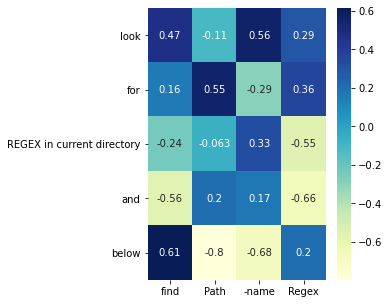

------------------------------------------------------------------------------------------------------------------------
1
['find', 'Path', '-name', 'Regex']


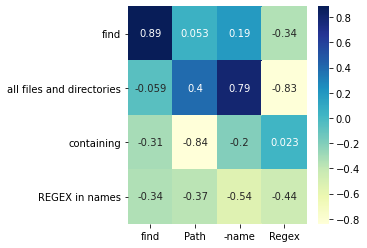

------------------------------------------------------------------------------------------------------------------------
2
['ln', '-s', 'File', 'Regex']


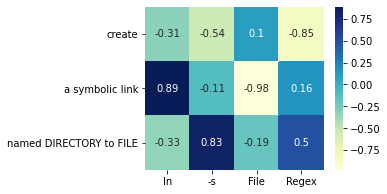

------------------------------------------------------------------------------------------------------------------------
3
['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']


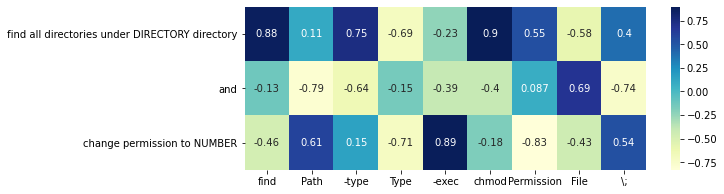

------------------------------------------------------------------------------------------------------------------------
4
['echo', '-n', 'Regex', '|', 'md5sum']


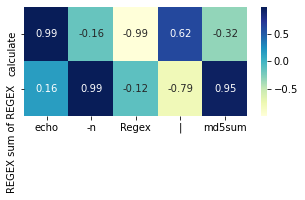

------------------------------------------------------------------------------------------------------------------------
5
['find', 'Path', '-name', 'Regex']


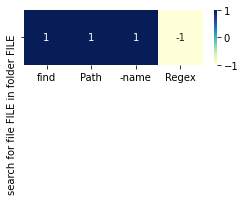

------------------------------------------------------------------------------------------------------------------------
6
['find', 'Path', '-group', 'Regex']


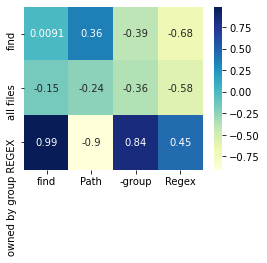

------------------------------------------------------------------------------------------------------------------------
7
['sort', '|', 'uniq', '-c']


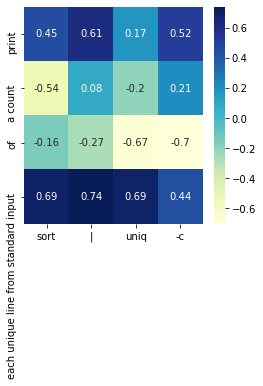

------------------------------------------------------------------------------------------------------------------------
8
['find', 'Path', '-path', 'Regex', '-prune', '-or', '-print']


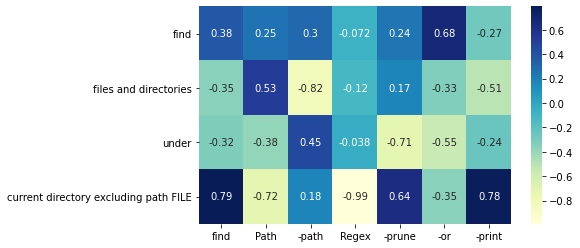

------------------------------------------------------------------------------------------------------------------------
9
['readlink', '-f', 'File']


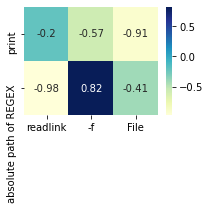

------------------------------------------------------------------------------------------------------------------------
10
['find', 'Path', '-type', 'Type', '!', '-perm', 'Permission']


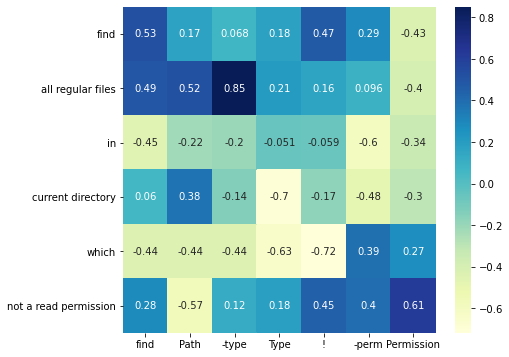

------------------------------------------------------------------------------------------------------------------------
11
['find', 'Path', '-name', 'Regex', '-type', 'Type']


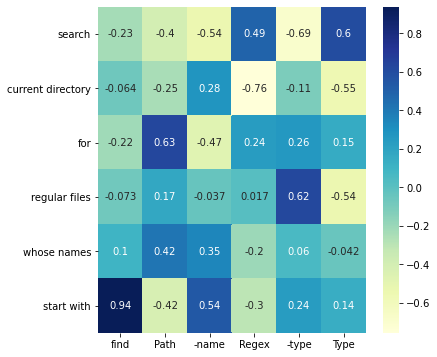

------------------------------------------------------------------------------------------------------------------------
12
['find', 'Path', '-type', 'Type', '-name', 'Regex']


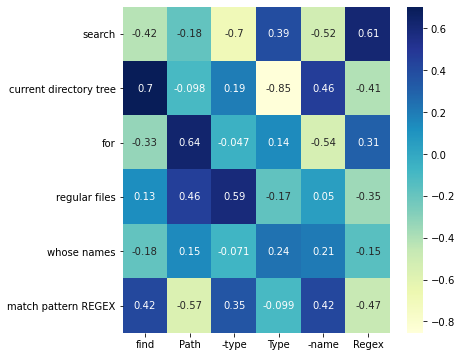

------------------------------------------------------------------------------------------------------------------------
13
['readlink', '-f', 'File']


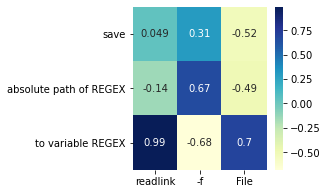

------------------------------------------------------------------------------------------------------------------------
14
['find', 'Path', '-name', 'Regex', '|', 'grep', '-f', '<(sed', 'Program', 'File)']


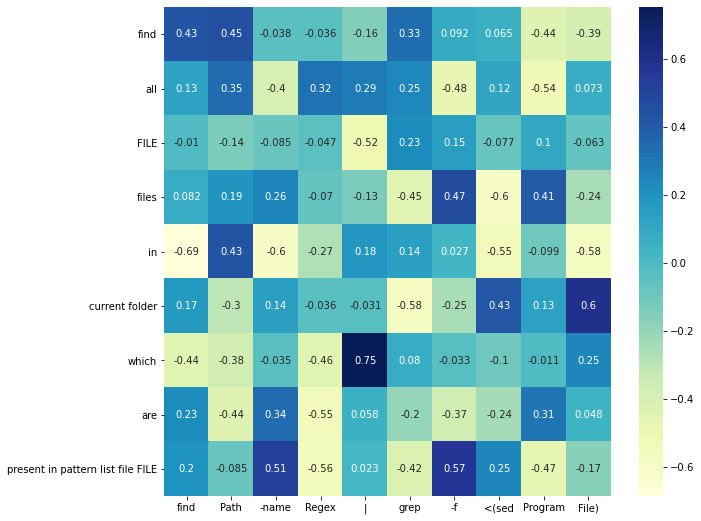

------------------------------------------------------------------------------------------------------------------------
15
['find', 'Path', '-type', 'Type']


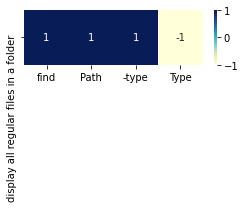

------------------------------------------------------------------------------------------------------------------------
16
['find', 'Path', '-name', 'Regex', '-ls']


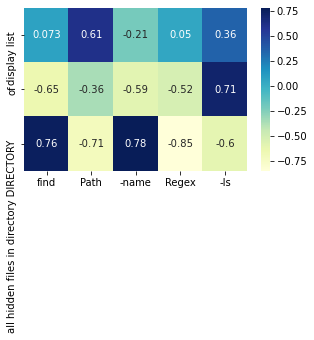

------------------------------------------------------------------------------------------------------------------------
17
['find', 'Path', '-mtime', 'Timespan']


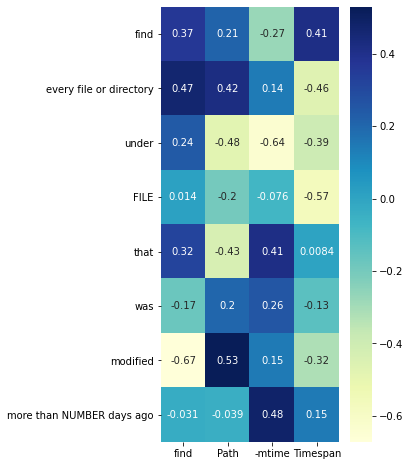

------------------------------------------------------------------------------------------------------------------------
18
['find', 'Path', '-type', 'Type']


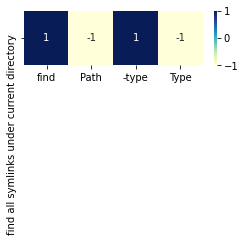

------------------------------------------------------------------------------------------------------------------------
19
['readlink', '-f', 'File']


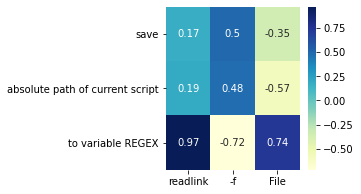

------------------------------------------------------------------------------------------------------------------------
20
['ifconfig', 'Regex', '|', 'grep', 'Regex']


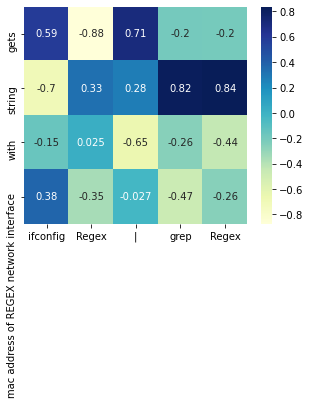

------------------------------------------------------------------------------------------------------------------------
21
['split', '-l', 'Quantity', 'File', 'Regex']


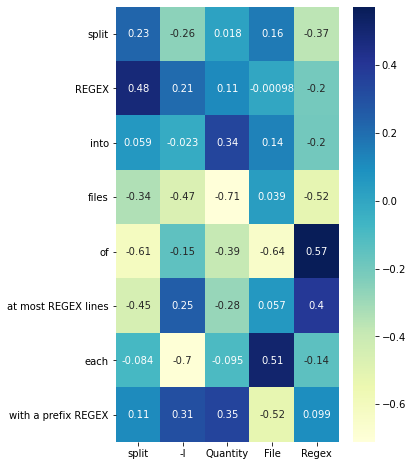

------------------------------------------------------------------------------------------------------------------------
22
['find', 'Path', '\\(', '-name', 'Regex', '-prune', '\\)', '-and', '\\(', '-name', 'Regex', '-prune', '\\)', '-or', '\\(', '-name', 'Regex', '-print', '\\)']


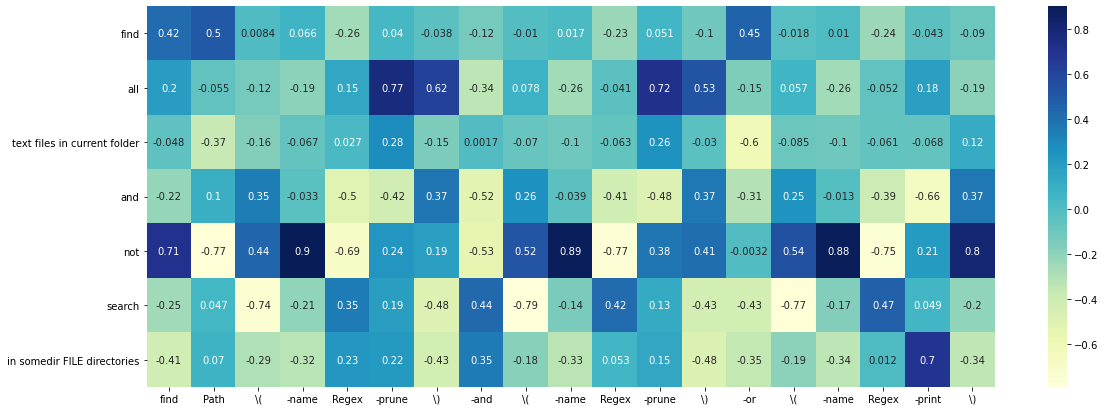

------------------------------------------------------------------------------------------------------------------------
23
['find', 'Path', '-name', 'Regex', '!', '-name', 'Regex', '-prune']


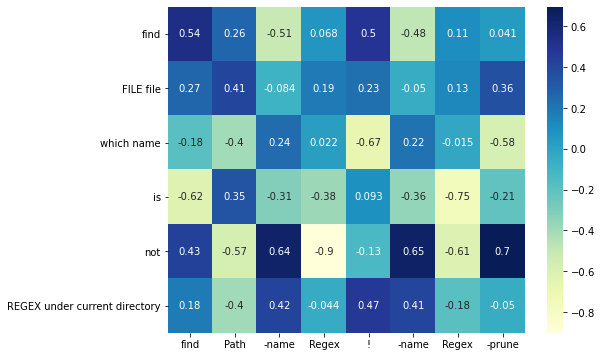

------------------------------------------------------------------------------------------------------------------------
24
['sort', '-u', 'File', 'File']


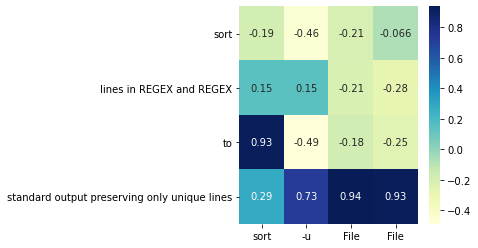

------------------------------------------------------------------------------------------------------------------------
25
['find', 'Path', '!', '-name', 'Regex', '-prune']


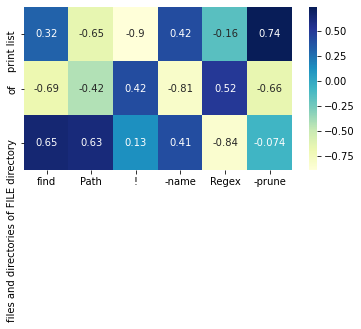

------------------------------------------------------------------------------------------------------------------------
26
['echo', 'Regex', '|', 'rev', '|', 'cut', '-d', 'Regex', '-f', 'Number', '|', 'rev']


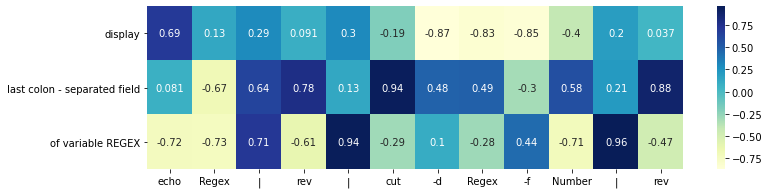

------------------------------------------------------------------------------------------------------------------------
27
['find', 'Path', '-perm', 'Permission']


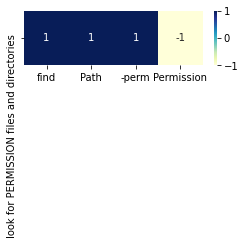

------------------------------------------------------------------------------------------------------------------------
28
['ping', '-c', 'Quantity', 'Regex']


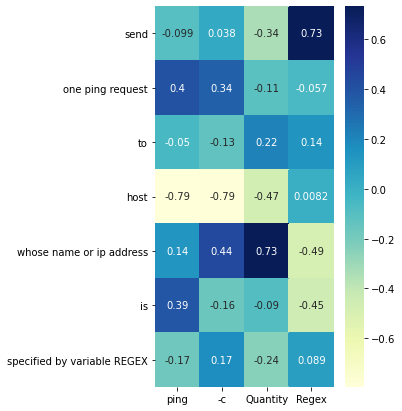

------------------------------------------------------------------------------------------------------------------------
29
['find', 'Path', '-name', 'Regex']


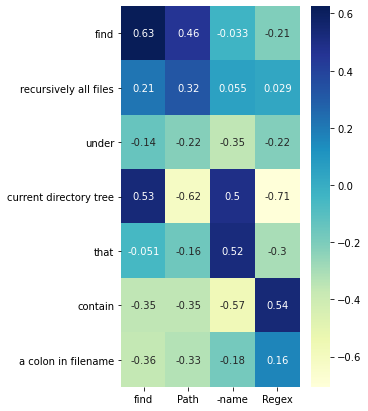

------------------------------------------------------------------------------------------------------------------------
30
['find', 'Path', '-type', 'Type', '-inum', 'Quantity', '-exec', 'mv', 'File', 'File', '\\;']


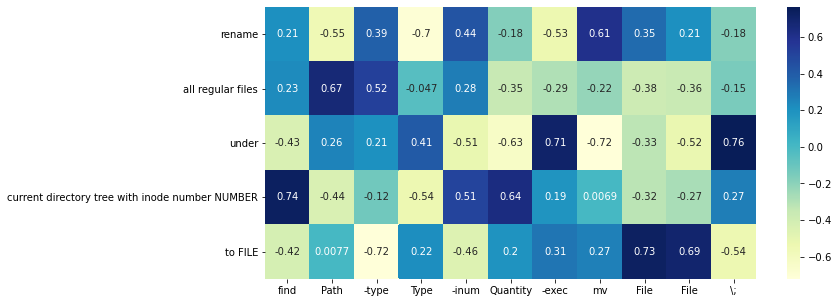

------------------------------------------------------------------------------------------------------------------------
31
['find', 'Path', '-cmin', 'Quantity']


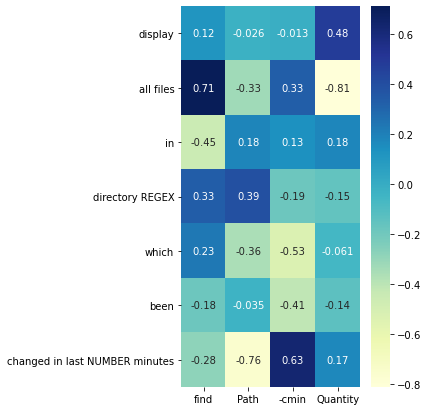

------------------------------------------------------------------------------------------------------------------------
32
['yes', '|', 'head', '-n', 'Quantity', '|', 'awk', 'Program']


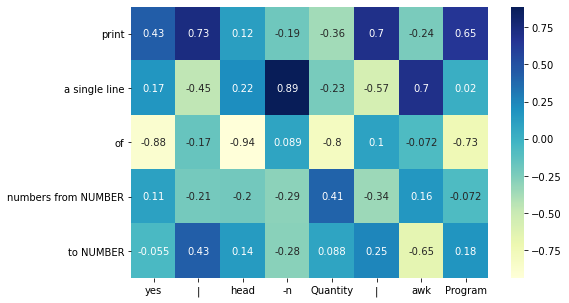

------------------------------------------------------------------------------------------------------------------------
33
['chgrp', '-R', 'Regex', 'File']


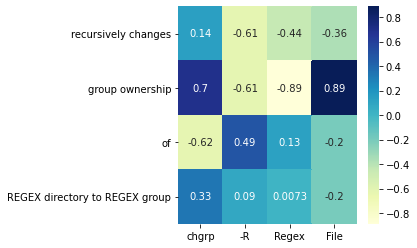

------------------------------------------------------------------------------------------------------------------------
34
['find', 'Path', '-user', 'Regex']


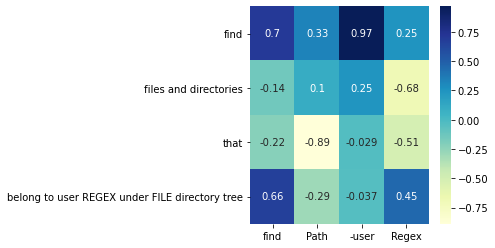

------------------------------------------------------------------------------------------------------------------------
35
['find', 'Path', '-type', 'Type', '-perm', 'Permission']


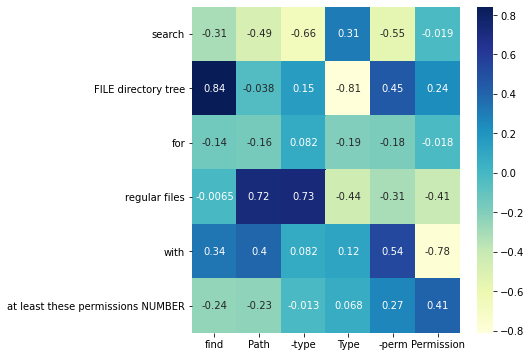

------------------------------------------------------------------------------------------------------------------------
36
['find', 'Path', '-type', 'Type', '-and', '!', '-name', 'Regex', '-or', '-name', 'Regex', '-and', '!', '-prune']


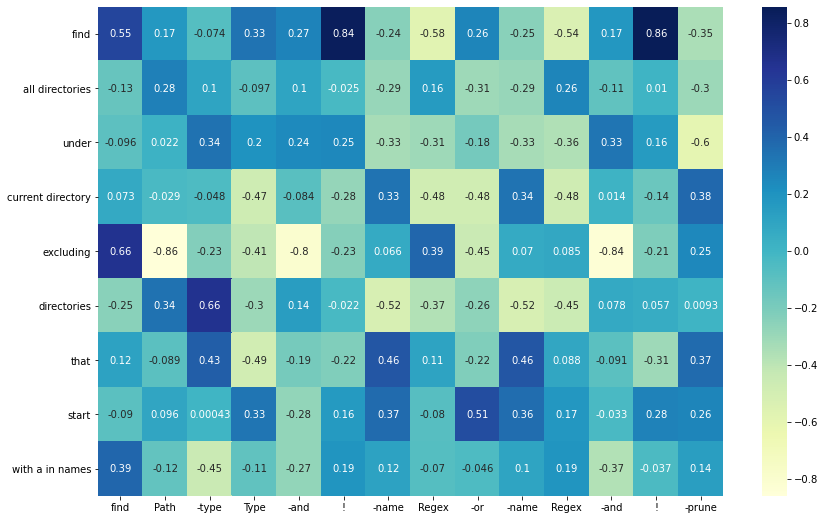

------------------------------------------------------------------------------------------------------------------------
37
['find', 'Path', '-size', 'Size']


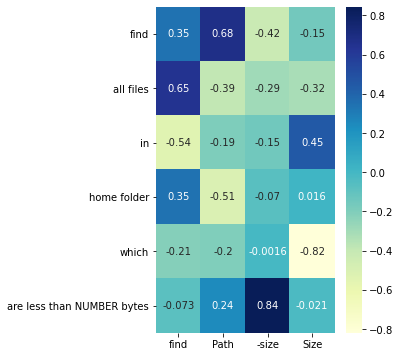

------------------------------------------------------------------------------------------------------------------------
38
['find', 'Path', '-type', 'Type', '-empty']


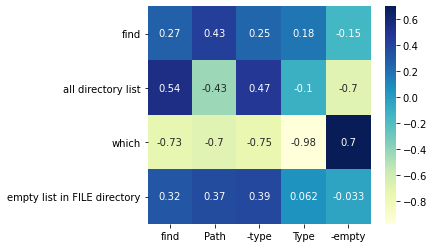

------------------------------------------------------------------------------------------------------------------------
39
['find', 'Path', 'Path', 'Path', '-name', 'Regex', '-type', 'Type']


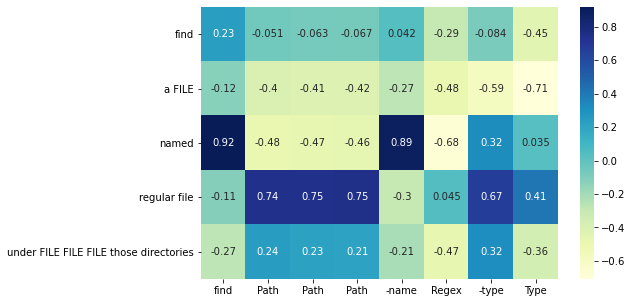

------------------------------------------------------------------------------------------------------------------------
40
['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']


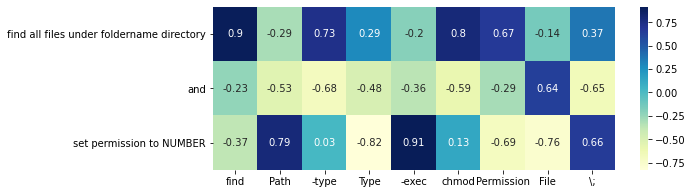

------------------------------------------------------------------------------------------------------------------------
41
['find', 'Path', '-wholename', 'Regex', '-prune', '-or', '-type', 'Type', '-perm', 'Permission', '-exec', 'ls', '-l', 'File', '\\;']


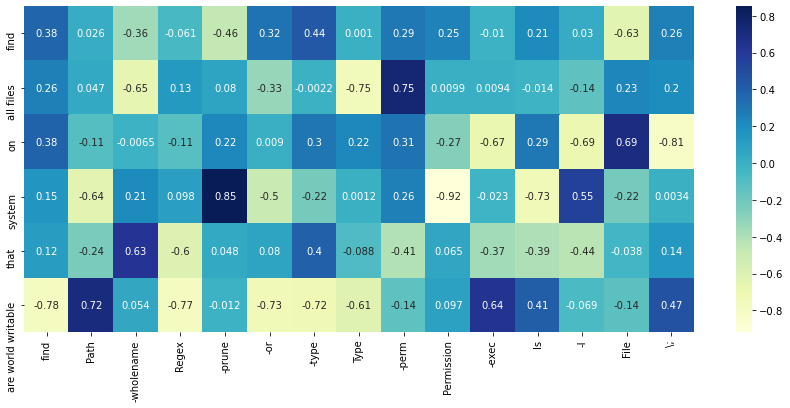

------------------------------------------------------------------------------------------------------------------------
42
['uname', '-a']


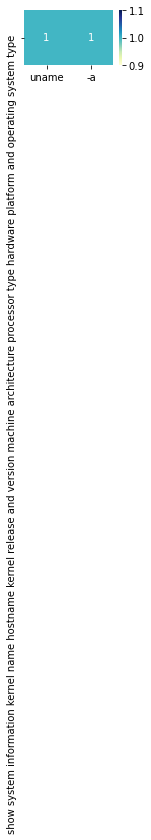

------------------------------------------------------------------------------------------------------------------------
43
['awk', 'Program', 'Program']


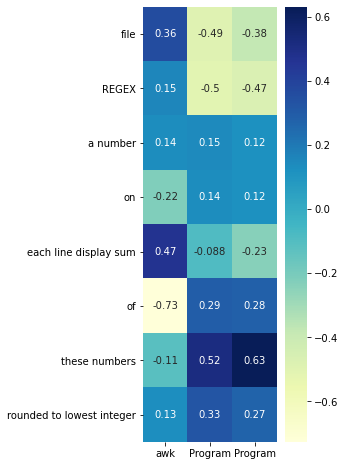

------------------------------------------------------------------------------------------------------------------------
44
['read', '-n', 'Quantity', 'Regex']


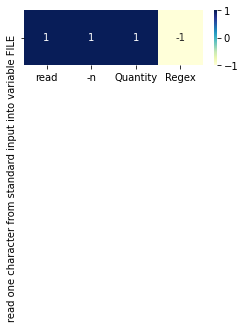

------------------------------------------------------------------------------------------------------------------------
45
['find', 'Path', '-mmin', 'Quantity']


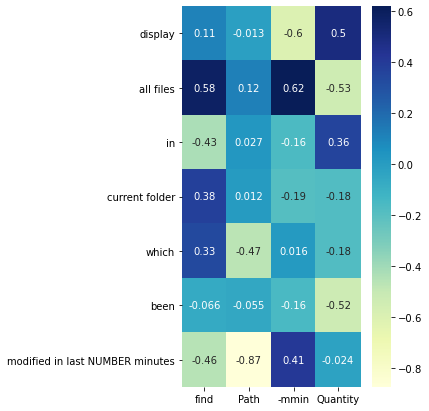

------------------------------------------------------------------------------------------------------------------------
46
['read', '-r', 'Regex']


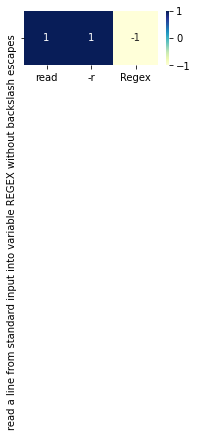

------------------------------------------------------------------------------------------------------------------------
47
['find', 'Path', '!', '\\(', '-name', 'Regex', '-prune', '\\)', '-type', 'Type', '-mtime', 'Timespan', '-print0']


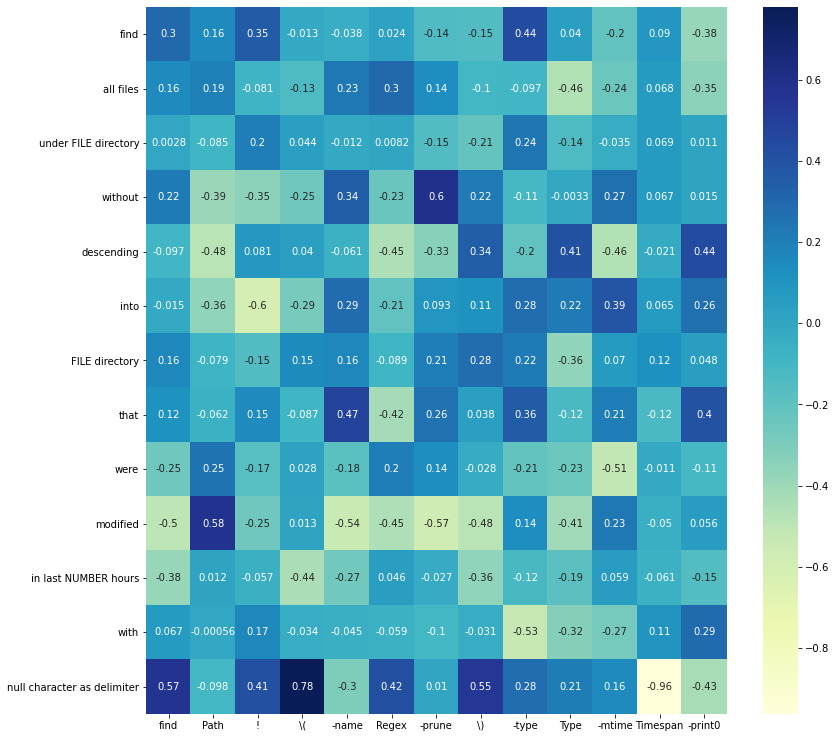

------------------------------------------------------------------------------------------------------------------------
48
['find', 'Path', '-type', 'Type', '-size', 'Size']


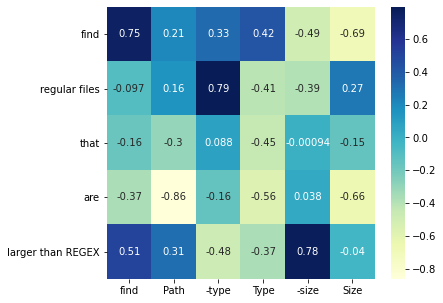

------------------------------------------------------------------------------------------------------------------------
49
['find', 'Path', '-type', 'Type', '-iwholename', 'Regex', '-exec', 'grep', '-H', 'Regex', 'File', '\\;']


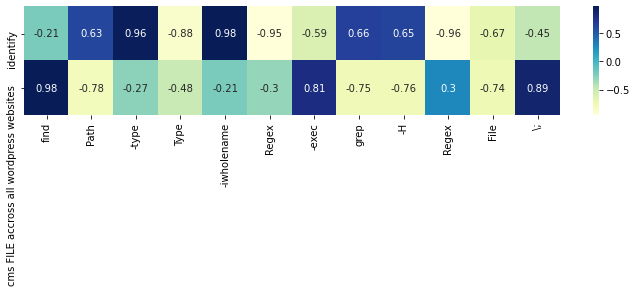

------------------------------------------------------------------------------------------------------------------------
50
['find', 'Path', '-inum', 'Quantity', '-exec', 'rm', 'File', '\\;']


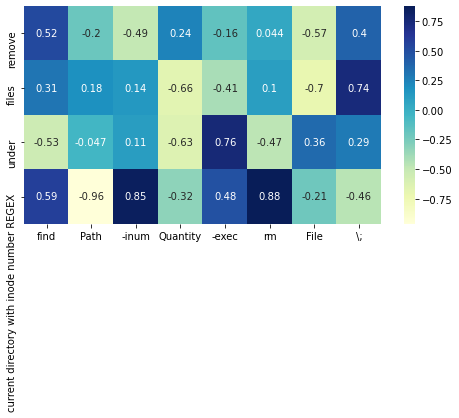

------------------------------------------------------------------------------------------------------------------------
51
['find', 'Path', '-name', 'Regex']


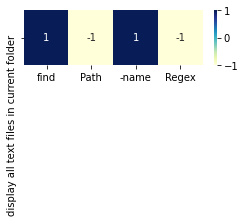

------------------------------------------------------------------------------------------------------------------------
52
['chmod', 'Permission', 'File', 'File', 'File']


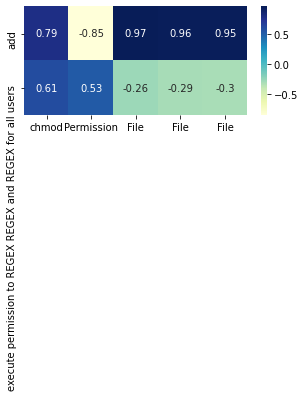

------------------------------------------------------------------------------------------------------------------------
53
['find', 'Path', '-name', 'Regex', '-type', 'Type']


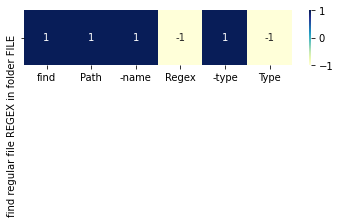

------------------------------------------------------------------------------------------------------------------------
54
['find', 'Path', 'Path', '-f', '-amin', 'Quantity']


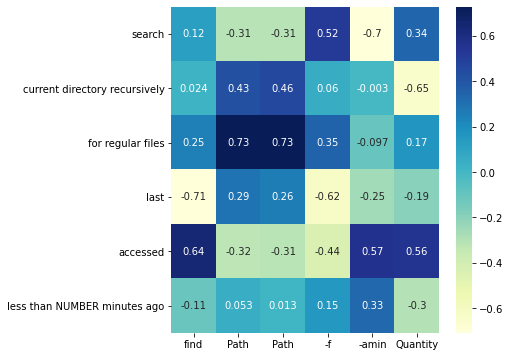

------------------------------------------------------------------------------------------------------------------------
55
['chmod', '-R', 'Permission', 'File']


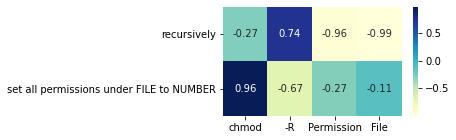

------------------------------------------------------------------------------------------------------------------------
56
['find', 'Path', '-type', 'Type']


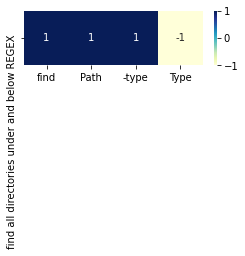

------------------------------------------------------------------------------------------------------------------------
57
['find', 'Path', '-perm', 'Permission', '-type', 'Type', '-exec', 'ls', '-l', 'File', '\\;']


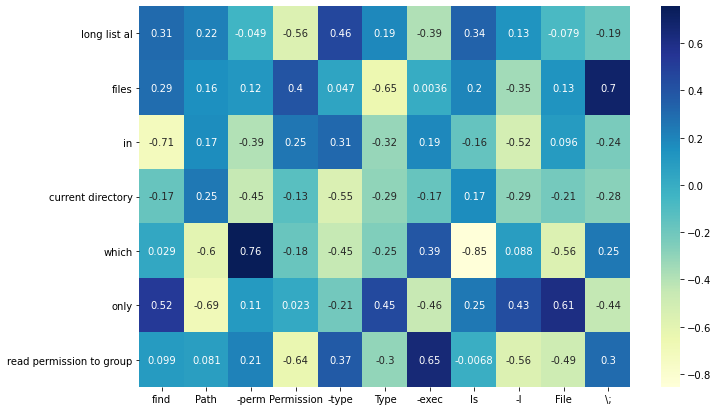

------------------------------------------------------------------------------------------------------------------------
58
['find', 'Path', '-newerct', 'Regex', '-print']


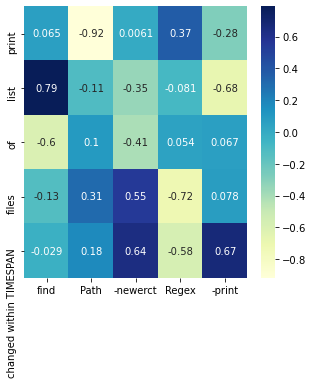

------------------------------------------------------------------------------------------------------------------------
59
['find', 'Path', '-type', 'Type', '-and', '-mmin', 'Quantity']


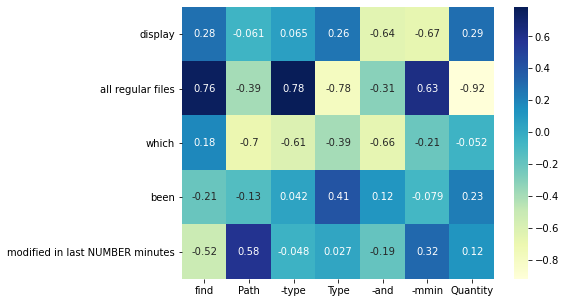

------------------------------------------------------------------------------------------------------------------------
60
['find', 'Path', '-iname', 'Regex']


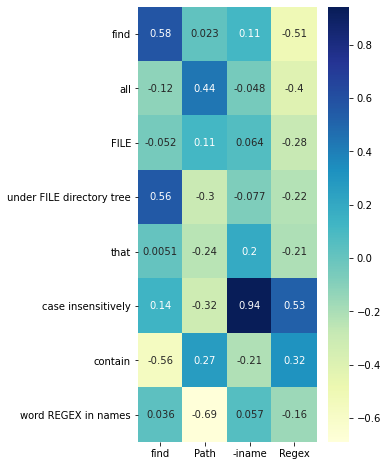

------------------------------------------------------------------------------------------------------------------------
61
['chmod', 'Permission', 'File']


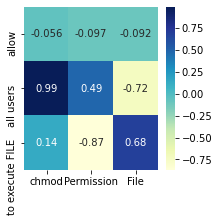

------------------------------------------------------------------------------------------------------------------------
62
['find', 'Path', '-type', 'Type']


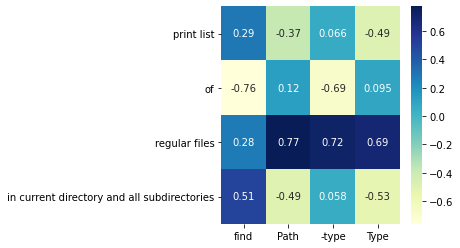

------------------------------------------------------------------------------------------------------------------------
63
['find', 'Path', '-type', 'Type', '-size', 'Size', '-exec', 'ls', '-l', '-h', 'File', '\\;', '|', 'awk', 'Program']


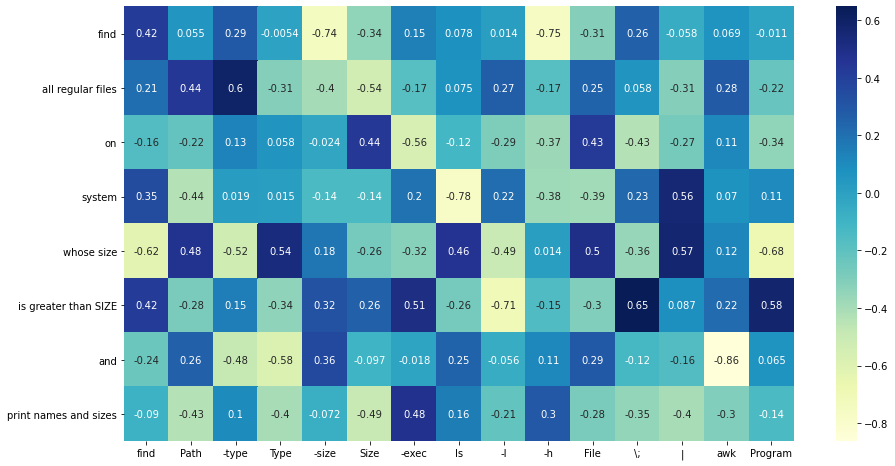

------------------------------------------------------------------------------------------------------------------------
64
['column', '-t', '-s', 'Regex', 'File']


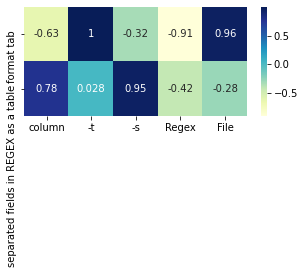

------------------------------------------------------------------------------------------------------------------------
65
['rev', 'File']


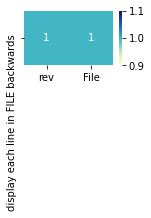

------------------------------------------------------------------------------------------------------------------------
66
['find', 'Path', '-type', 'Type', '-empty']


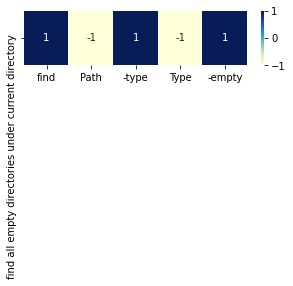

------------------------------------------------------------------------------------------------------------------------
67
['find', 'Path', '-name', 'Regex']


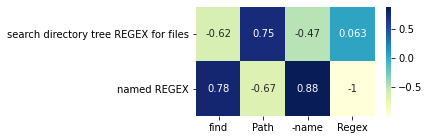

------------------------------------------------------------------------------------------------------------------------
68
['find', 'Path', '-name', 'Regex']


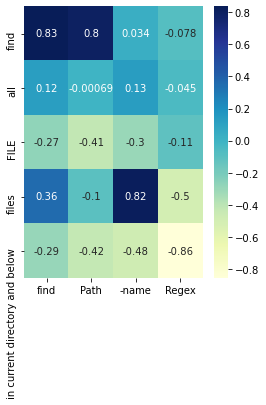

------------------------------------------------------------------------------------------------------------------------
69
['find', 'Path', '-size', 'Size']


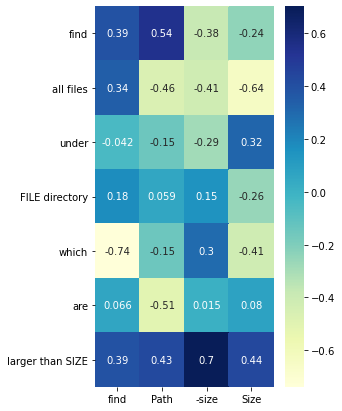

------------------------------------------------------------------------------------------------------------------------
70
['find', 'Path', '-atime', 'Timespan']


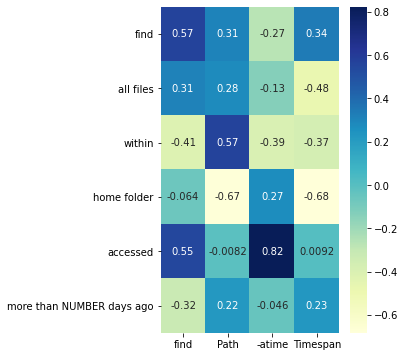

------------------------------------------------------------------------------------------------------------------------
71
['find', 'Path', '-name', 'Regex', '|', 'xargs', '-I', 'ReservedWord', 'rename', 'Regex', 'ReservedWord']


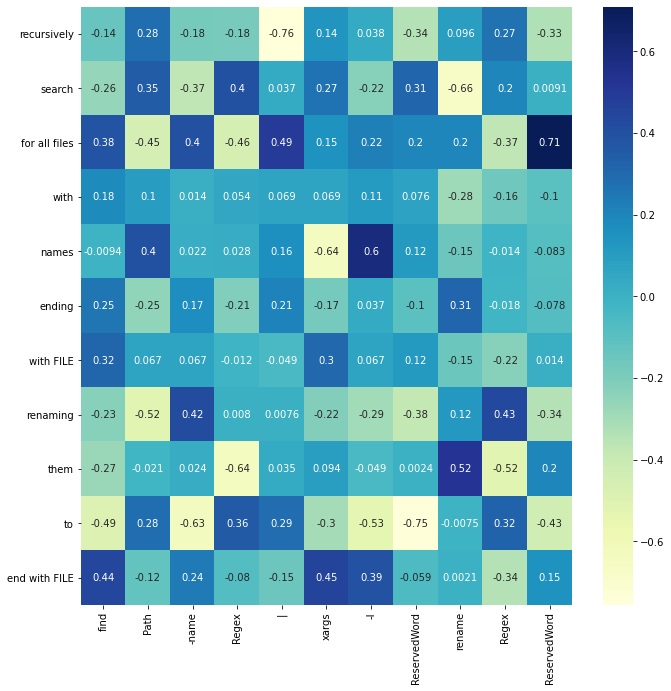

------------------------------------------------------------------------------------------------------------------------
72
['mount', '-o', 'Option', 'Regex']


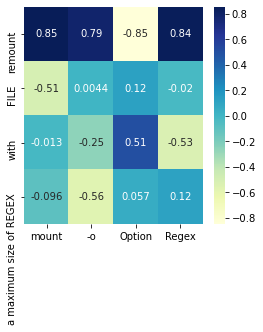

------------------------------------------------------------------------------------------------------------------------
73
['find', 'Path', '-name', 'Regex', '|', 'grep', 'Regex']


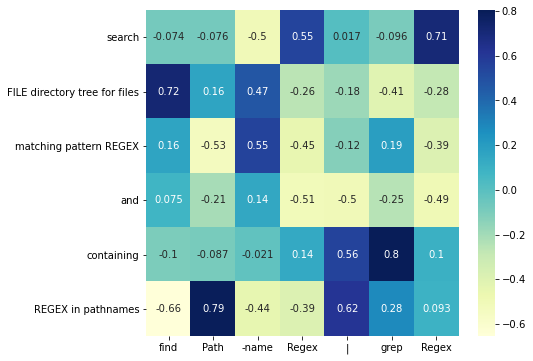

------------------------------------------------------------------------------------------------------------------------
74
['ln', '-f', '-s', 'File', 'Regex']


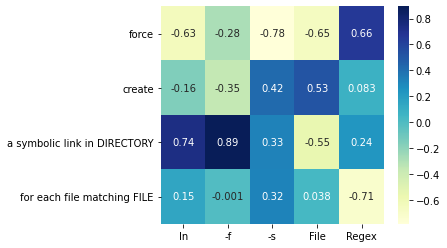

------------------------------------------------------------------------------------------------------------------------
75
['find', 'Path', '-iname', 'Regex']


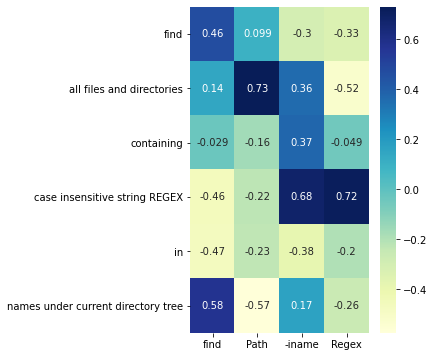

------------------------------------------------------------------------------------------------------------------------
76
['file', 'File', '|', 'grep', 'Regex']


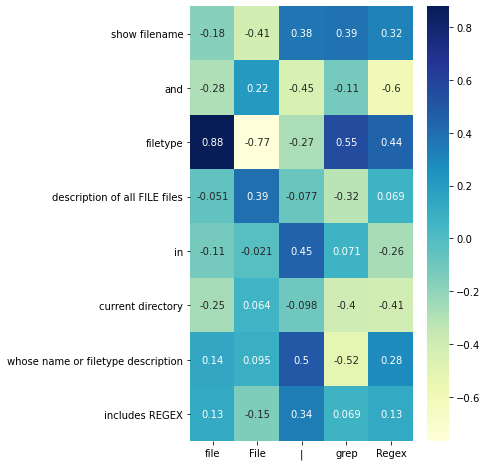

------------------------------------------------------------------------------------------------------------------------
77
['gzip', 'Regex']


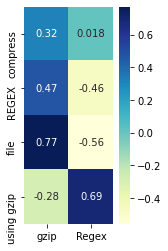

------------------------------------------------------------------------------------------------------------------------
78
['find', 'Path', '-type', 'Type', '-perm', 'Permission', '-print']


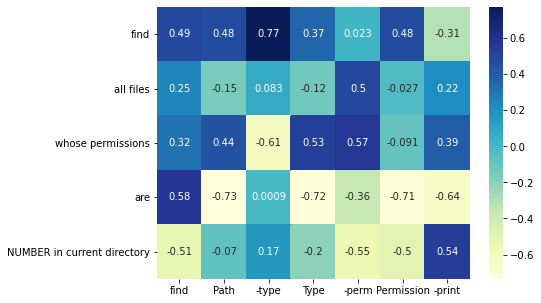

------------------------------------------------------------------------------------------------------------------------
79
['chmod', 'Permission', 'File', 'File']


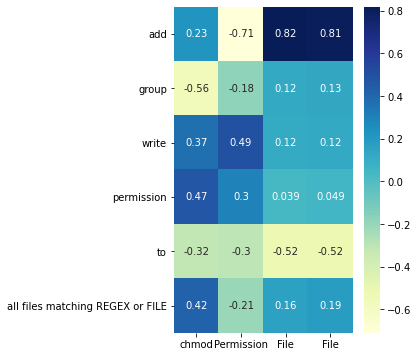

------------------------------------------------------------------------------------------------------------------------
80
['find', 'Path', '-iname', 'Regex']


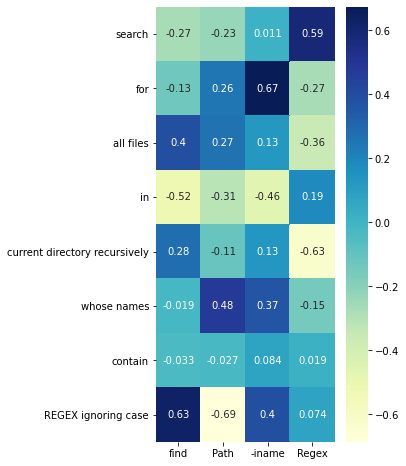

------------------------------------------------------------------------------------------------------------------------
81
['chown', 'Regex', '-R', 'File']


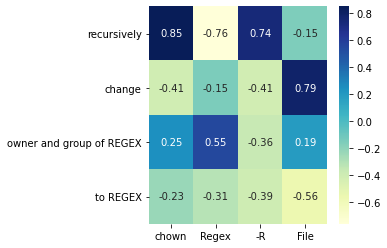

------------------------------------------------------------------------------------------------------------------------
82
['chgrp', 'Regex', 'File']


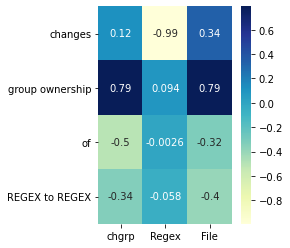

------------------------------------------------------------------------------------------------------------------------
83
['find', 'Path', '-atime', 'Timespan']


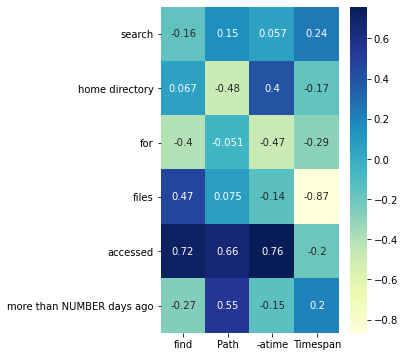

------------------------------------------------------------------------------------------------------------------------
84
['find', 'Path', '-name', 'Regex', '-exec', 'grep', '-l', 'Regex', 'File', '\\;']


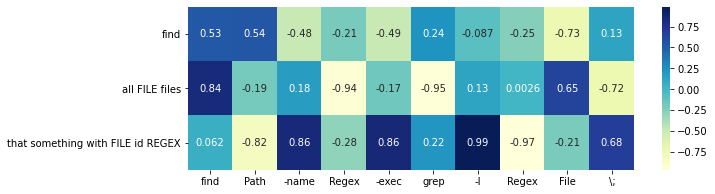

------------------------------------------------------------------------------------------------------------------------
85
['find', 'Path', '-size', 'Size']


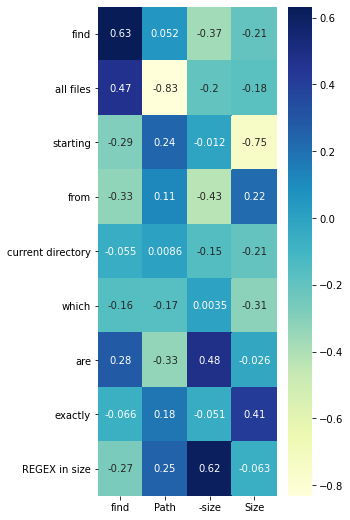

------------------------------------------------------------------------------------------------------------------------
86
['curl', 'Regex', '|', 'sh']


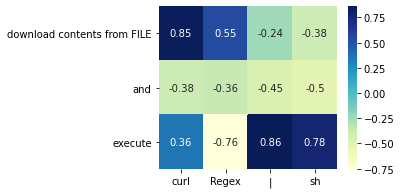

------------------------------------------------------------------------------------------------------------------------
87
['find', 'Path', '-name', 'Regex']


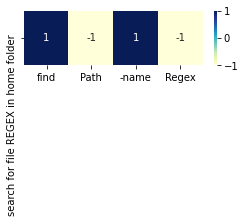

------------------------------------------------------------------------------------------------------------------------
88
['find', 'Path', '-size', 'Size']


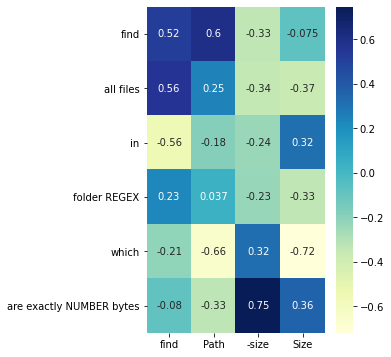

------------------------------------------------------------------------------------------------------------------------
89
['find', 'Path', '-type', 'Type', '-exec', 'grep', 'Regex', 'File', '\\;']


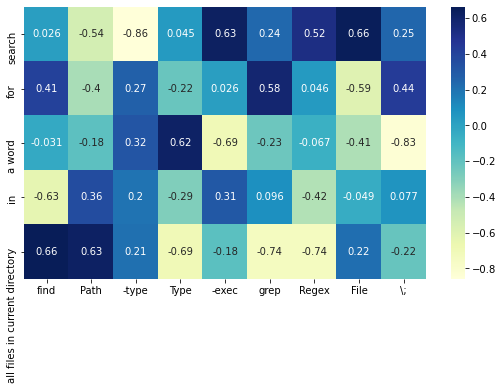

------------------------------------------------------------------------------------------------------------------------
90
['find', 'Path', '-name', 'Regex']


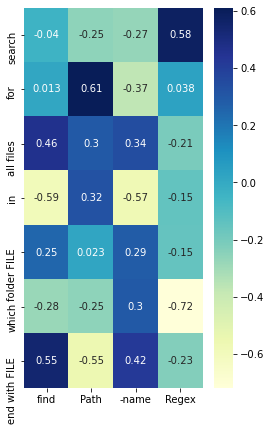

------------------------------------------------------------------------------------------------------------------------
91
['history', '|', 'awk', 'Program']


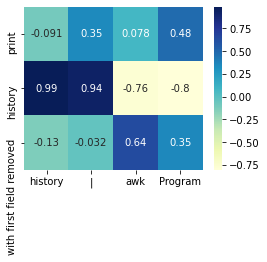

------------------------------------------------------------------------------------------------------------------------
92
['find', 'Path', '-perm', 'Permission', '-exec', 'chmod', 'Permission', 'File', '\\;']


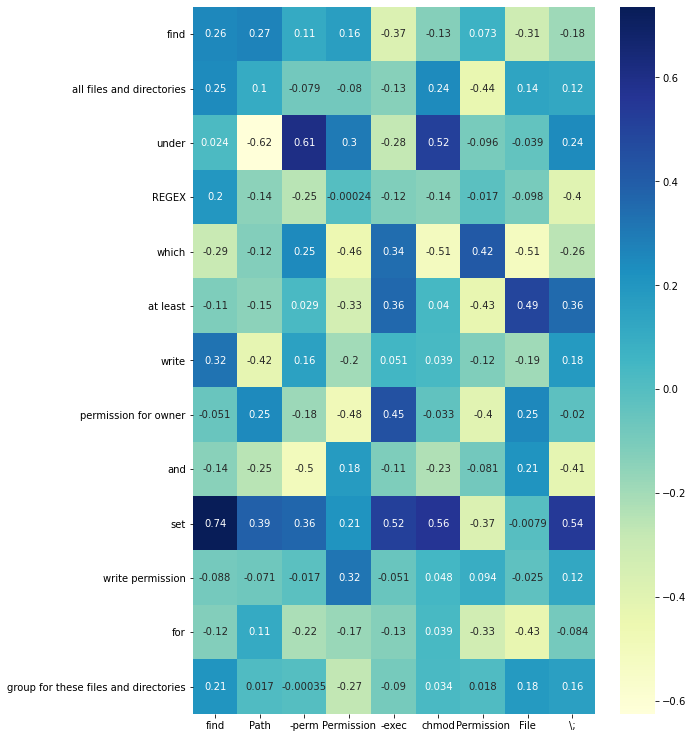

------------------------------------------------------------------------------------------------------------------------
93
['find', 'Path', '-mtime', 'Timespan']


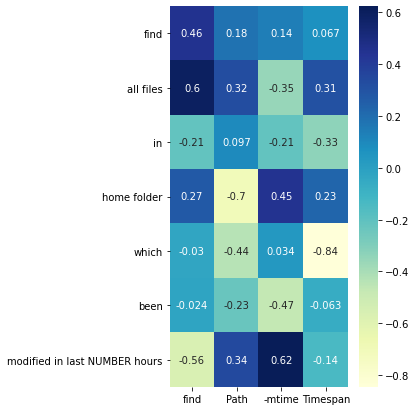

------------------------------------------------------------------------------------------------------------------------
94
['ln', '-f', 'File', 'Regex']


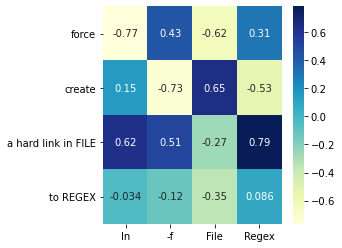

------------------------------------------------------------------------------------------------------------------------
95
['diff', '-y', 'File', 'File']


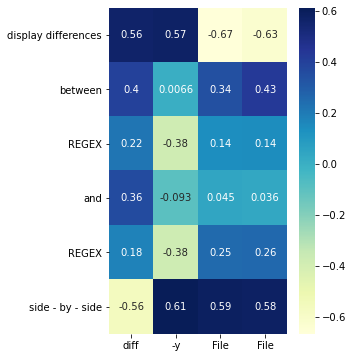

------------------------------------------------------------------------------------------------------------------------
96
['find', 'Path', '-name', 'Regex', '-exec', 'chmod', 'Permission', 'File', '\\;']


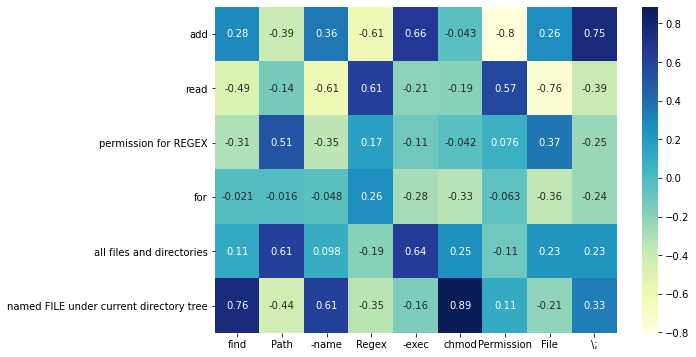

------------------------------------------------------------------------------------------------------------------------
97
['find', 'Path', '-type', 'Type', '-atime', 'Timespan']


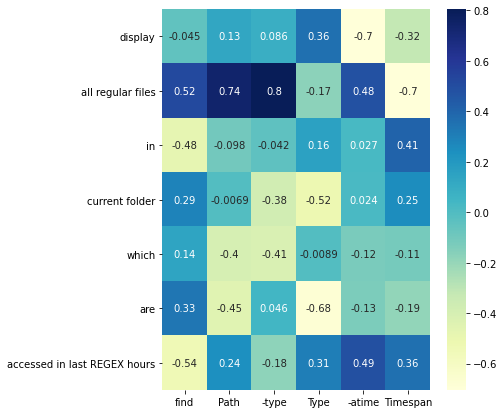

------------------------------------------------------------------------------------------------------------------------
98
['find', 'Path', '-user', 'Regex']


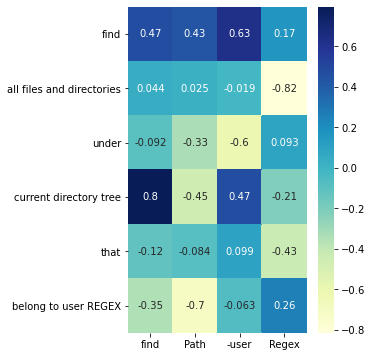

------------------------------------------------------------------------------------------------------------------------
99
['df', '-h', 'File']


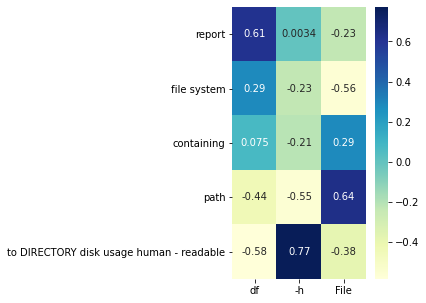

------------------------------------------------------------------------------------------------------------------------


In [58]:
import pandas as pd

df = {'attribution_id':[],'n_utilities':[],'n_flags':[],'n_arguments':[],'utils_correct':[],'flags_correct':[],'args_correct':[]}
c=0
for i in range(len(pred_full_data)):
    print(i)
    image_save_path = 'attribution_images/'+str(i)+'.png'
    plot_fig(i, save_fig_name= image_save_path)
    im = plt.imread(image_save_path)
    df['attribution_id'].append(i)
    df['n_utilities'].append(0)
    df['n_flags'].append(0)
    df['n_arguments'].append(0)
    df['utils_correct'].append(0)
    df['flags_correct'].append(0)
    df['args_correct'].append(0)
    print('------'*20)
    c+=1
    if c==100:
        break

In [60]:
df = pd.DataFrame(df)
df.to_csv('temp.csv',index=False)

In [56]:
from utils.metric_utils import compute_metric
matching_indices = []
i=0
for i in range(1031):
    pred,cmd = pred_full_data[i], cmd_full_data[i]
    pred = ' '.join(pred)
    cmd = ' '.join(cmd)
    if compute_metric(pred,1,cmd,{'u1':1.0,'u2':1.0})==1:
        matching_indices.append(i)
    i+=1

['file', 'File', '|', 'grep', 'Regex']


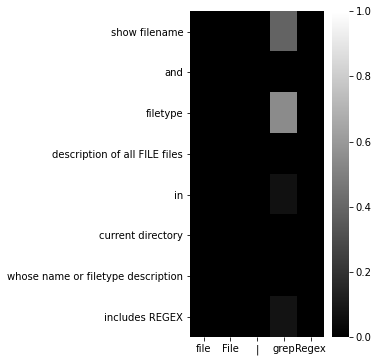

['file', 'File', '|', 'grep', 'Regex']
['find', 'Path', '-type', 'Type', '-inum', 'Quantity', '-exec', 'mv', 'File', 'File', '\\;']


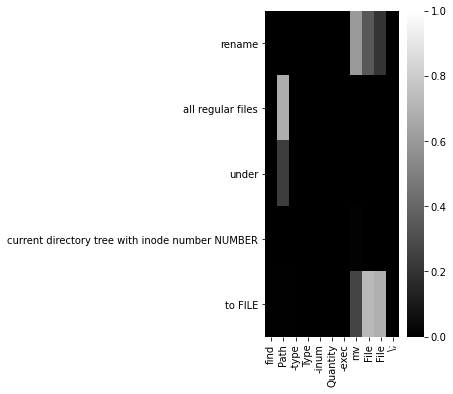

['find', 'Path', '-type', 'Type', '-inum', 'Quantity', '-exec', 'mv', 'File', '\\;']
['find', 'Path', '-perm', 'Permission']


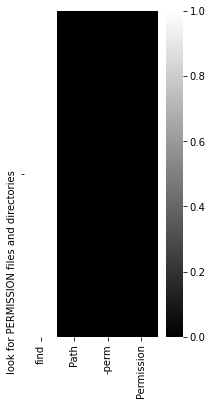

['find', 'Path', '-perm', 'Permission']
['find', 'Path', '-inum', 'Quantity', '-exec', 'rm', '-i', 'File', '\\;']


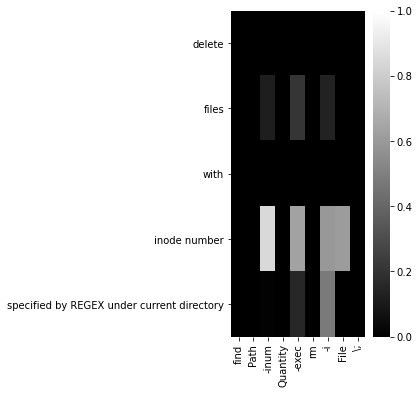

['find', 'Path', '-inum', 'Quantity', '-exec', 'rm', '-i', 'File', '\\;']
['find', 'Path', '-perm', 'Permission']


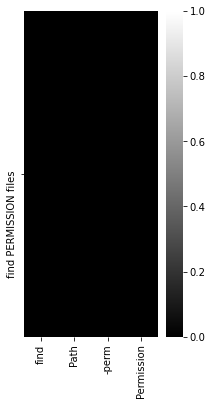

['find', 'Path', '-perm', 'Permission']
['find', 'Path', '-name', 'Regex']


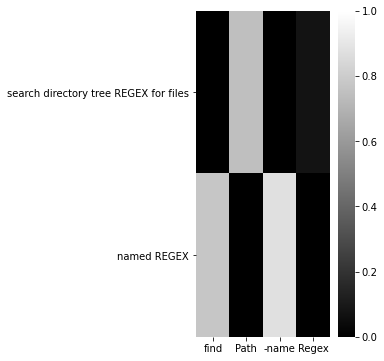

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-cmin', 'Quantity']


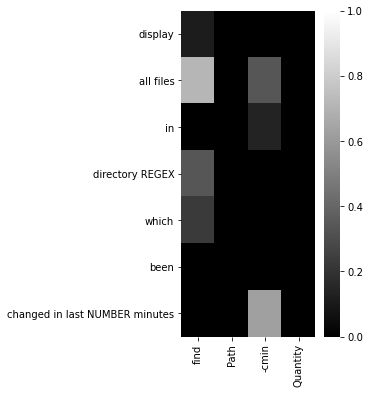

['find', 'Path', '-cmin', 'Quantity']
['sort', '-u', 'File', 'File']


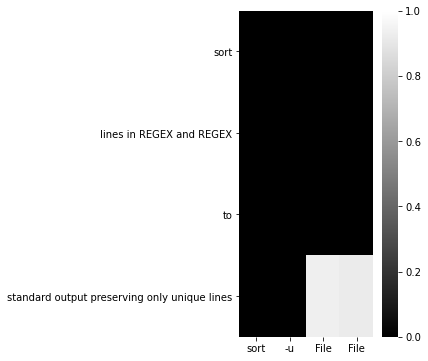

['sort', '-u', 'File']
['ln', '-s', 'File', 'Regex']


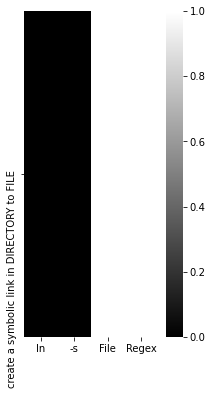

['ln', '-s', 'File', 'Regex']
['find', 'Path', '-perm', 'Permission']


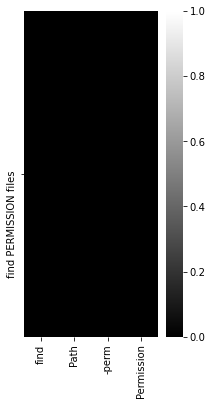

['find', 'Path', '-perm', 'Permission']
['find', 'Path', '-size', 'Size']


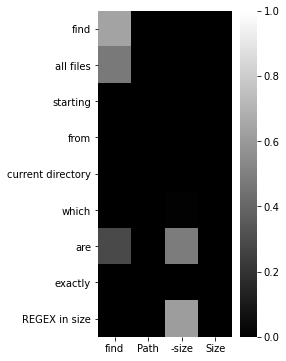

['find', 'Path', '-size', 'Size']
['find', 'Path', '-type', 'Type', '-not', '-name', 'Regex', '-not', '-name', 'Regex', '|', 'xargs', '-I', 'ReservedWord', 'rm', 'ReservedWord']


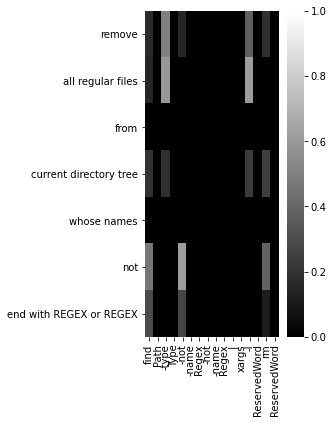

['find', 'Path', '-type', 'Type', '-not', '-name', 'Regex', '-or', '-not', '-name', 'Regex', '|', 'xargs', '-I', 'ReservedWord', 'rm', 'ReservedWord']
['awk', 'Program', 'Program']


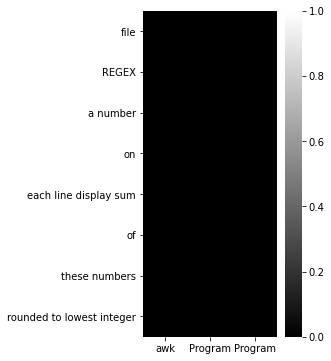

['awk', 'Program', 'Program']
['find', 'Path', 'Path', '-f', '-amin', 'Quantity']


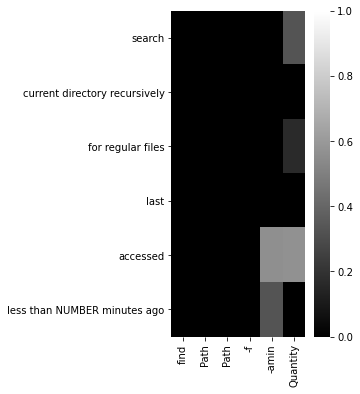

['find', 'Path', '-f', '-amin', 'Quantity']
['mkdir', 'Directory']


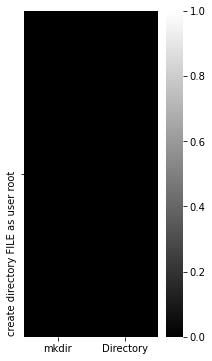

['mkdir', 'Directory']
['find', 'Path', '-name', 'Regex']


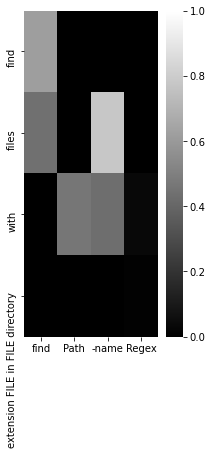

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-name', 'Regex', '-type', 'Type']


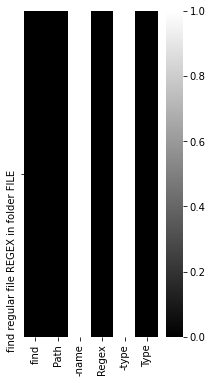

['find', 'Path', '-type', 'Type', '-name', 'Regex']
['find', 'Path', '-name', 'Regex']


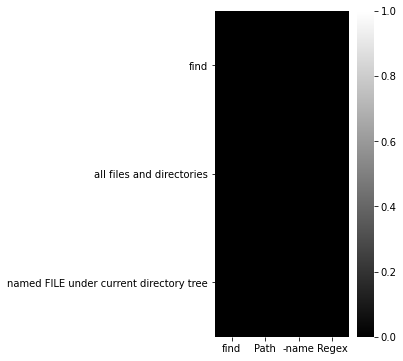

['find', 'Path', '-name', 'Regex']
['sort', '|', 'uniq', '-c']


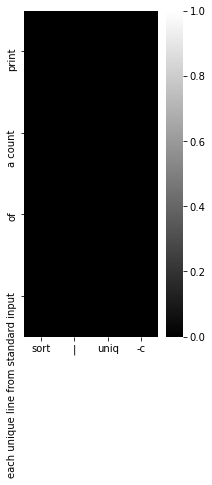

['sort', 'File', '|', 'uniq', '-c']
['chmod', 'Permission', 'File']


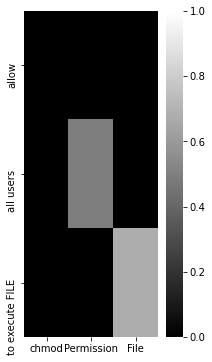

['chmod', 'Permission', 'File']
['find', 'Path', '-name', 'Regex', '|', 'xargs', '-I', 'ReservedWord', 'rm', 'ReservedWord']


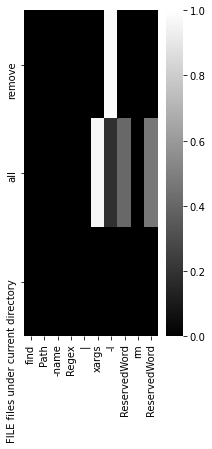

['find', 'Path', '-name', 'Regex', '|', 'xargs', '-I', 'ReservedWord', 'rm', 'ReservedWord']
['find', 'Path', '-name', 'Regex']


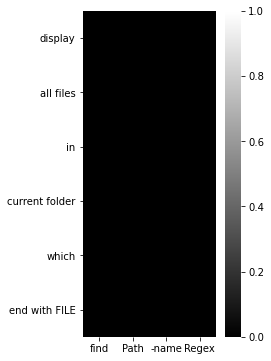

['find', 'Path', '-name', 'Regex']
['bzip2', '-k', '-v', 'File']


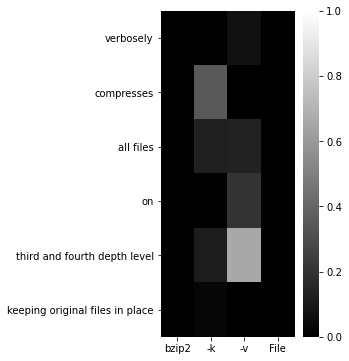

['bzip2', '-k', '-v', 'File']
['find', 'Path', '-group', 'Regex', '-perm', 'Permission', '-print']


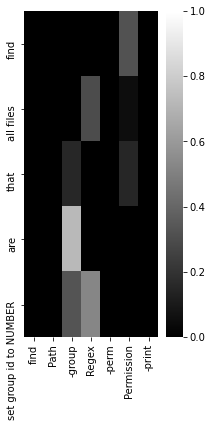

['find', 'Path', '-group', 'Regex', '-perm', 'Permission', '-print']
['find', 'Path', '-newerct', 'Regex', '-print']


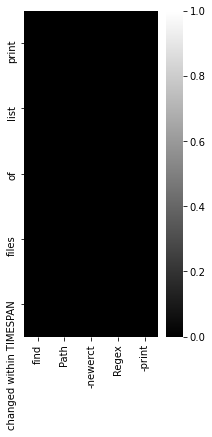

['find', 'Path', '-newerct', 'Regex', '-print']
['chown', 'Regex', '-R', 'File']


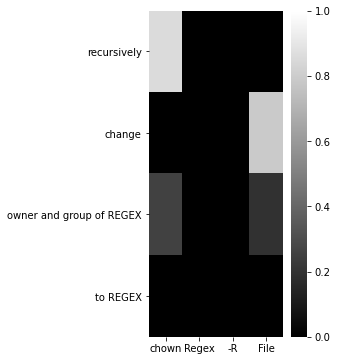

['chown', '-R', 'Regex', 'File']
['mktemp', '-u', '-t', 'Regex']


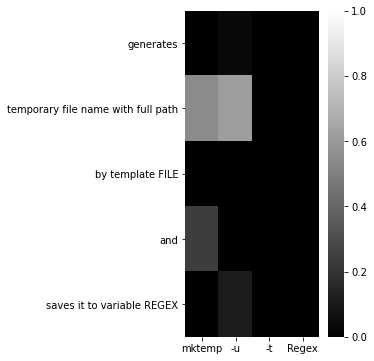

['mktemp', '-u', '-t', 'Regex']
['find', 'Path', '-perm', 'Permission', '-exec', 'chmod', 'Permission', 'File', '\\;']


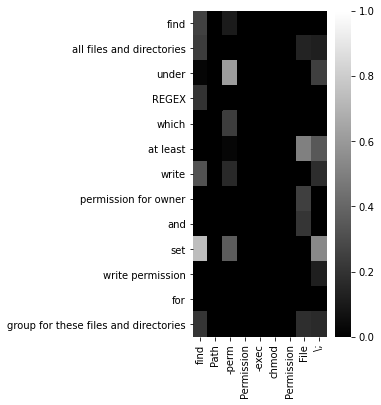

['find', 'Path', '-perm', 'Permission', '-exec', 'chmod', 'Permission', 'File', '\\;']
['find', 'Path', '-name', 'Regex', '-ls']


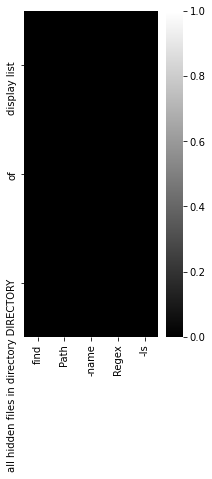

['find', 'Path', '-name', 'Regex', '-ls']
['find', 'Path', '-mtime', 'Timespan']


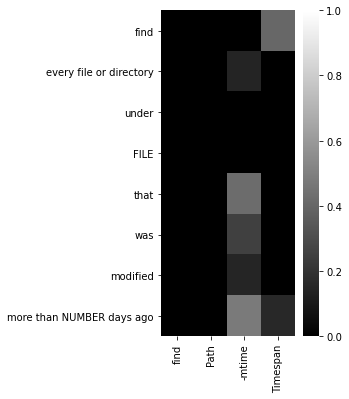

['find', 'Path', '-mtime', 'Timespan']
['find', 'Path', '-name', 'Regex']


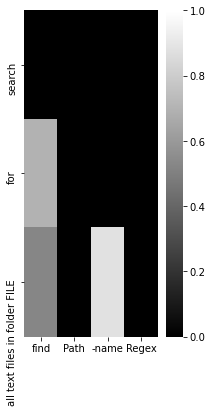

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-name', 'Regex']


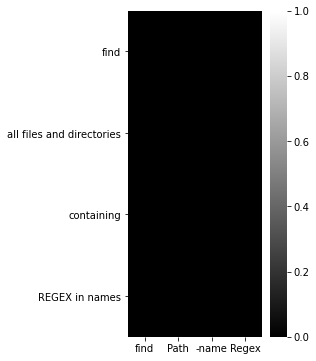

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-name', 'Regex']


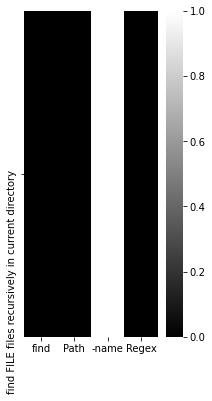

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-wholename', 'Regex', '-prune', '-or', '-type', 'Type', '-perm', 'Permission', '-exec', 'ls', '-l', 'File', '\\;']


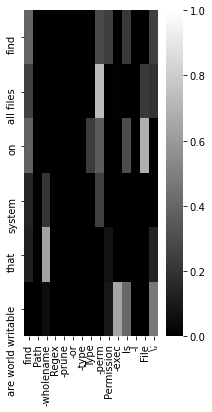

['find', 'Path', '-wholename', 'Regex', '-prune', '-or', '-type', 'Type', '-perm', 'Permission', '-exec', 'ls', '-l', 'File', '\\;']
['find', 'Path', '-mindepth', 'Quantity', '-maxdepth', 'Quantity', '-type', 'Type']


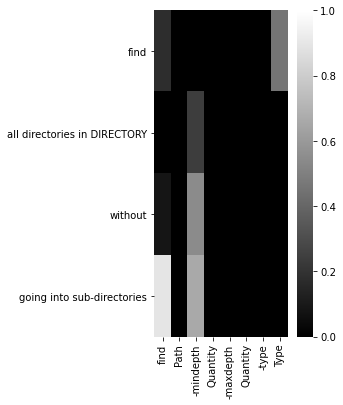

['find', 'Path', '-mindepth', 'Quantity', '-maxdepth', 'Quantity', '-type', 'Type']
['find', 'Path', '-iname', 'Regex']


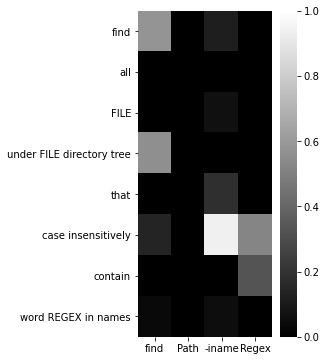

['find', 'Path', '-iname', 'Regex']
['find', 'Path', '-atime', 'Timespan', '-exec', 'rm', '-f', 'File', '\\;']


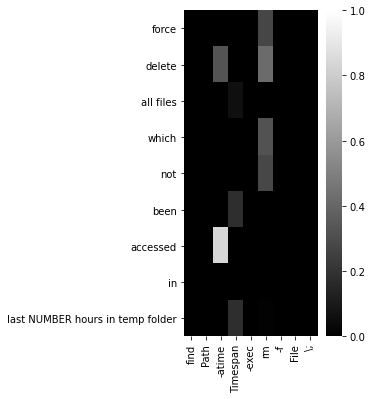

['find', 'Path', '-atime', 'Timespan', '-exec', 'rm', '-f', 'File', '\\;']
['rsync', '--iconv=Option', 'File', 'File']


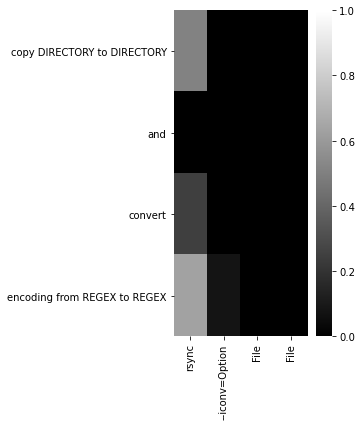

['rsync', '--iconv=Option', 'File']
['echo', '$(date)', 'Regex', '|', 'tee', '-a', 'File']


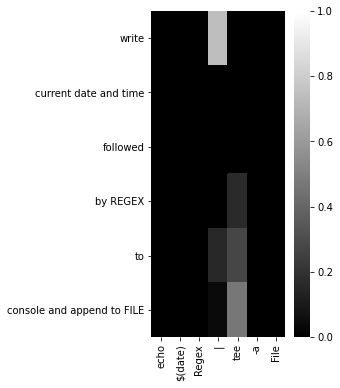

['echo', '$(date)', 'Regex', '|', 'tee', '-a', 'File']
['find', 'Path', '-type', 'Type', '-name', 'Regex', '-ctime', 'Timespan', '-exec', 'sed', '-i', 'Regex', '-e', 'Program', '-e', 'Program', 'Program', '\\;']


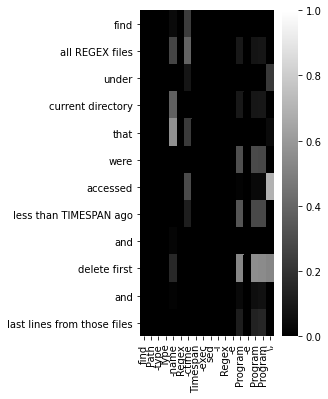

['find', 'Path', '-type', 'Type', '-name', 'Regex', '-ctime', 'Timespan', '-exec', 'sed', '-i', 'Regex', '-e', 'Program', 'File', '\\;']
['cp', '--remove-destination', '$(readlink', 'File)', 'File']


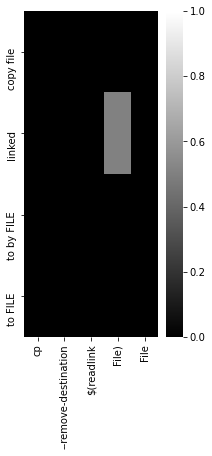

['cp', '--remove-destination', '$(readlink', 'File)', 'File']
['find', 'Path', '-type', 'Type', '-perm', 'Permission']


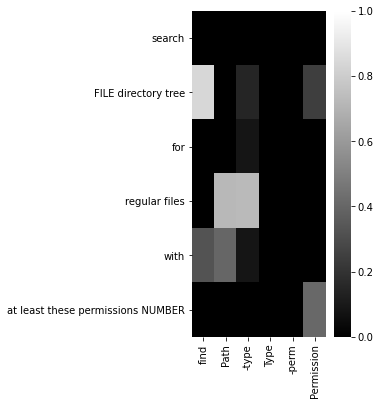

['find', 'Path', '-type', 'Type', '-perm', 'Permission']
['mkdir', '-p', 'Directory']


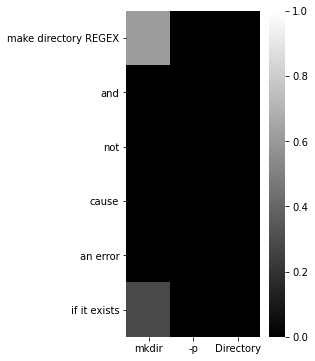

['mkdir', '-p', 'Directory']
['ssh', '-M', '-f', '-N', '-o', 'Option', 'Regex']


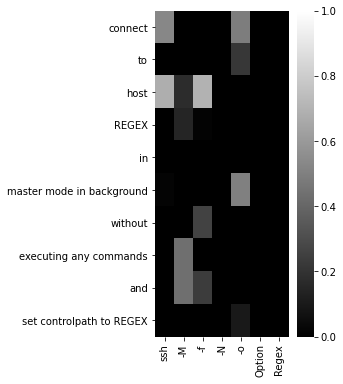

['ssh', '-o', 'Option', '-M', '-N', '-f', 'Regex']
['find', 'Path', '-name', 'Regex', '-prune']


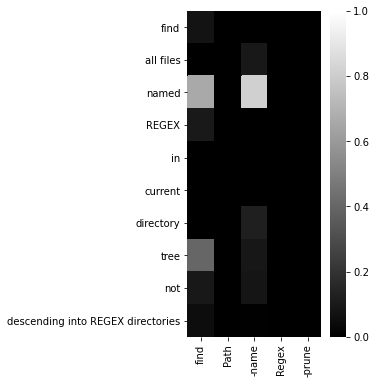

['find', 'Path', '-name', 'Regex', '-prune', '-or', '-name', 'Regex']
['readlink', '-f', 'File']


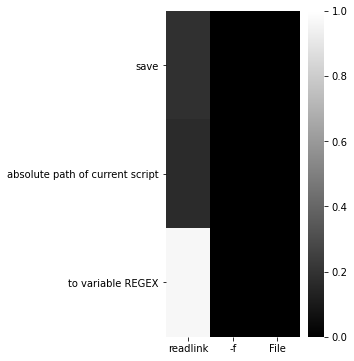

['readlink', '-f', 'File']
['find', 'Path', '-name', 'Regex']


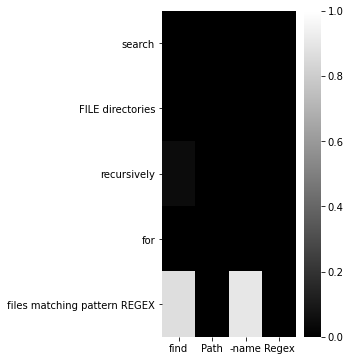

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-type', 'Type', '!', '-perm', 'Permission']


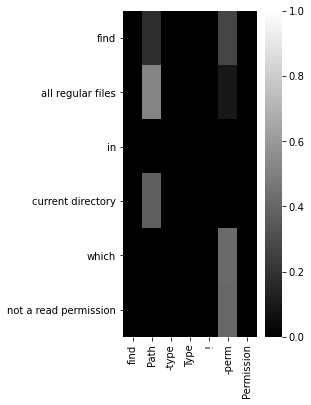

['find', 'Path', '-type', 'Type', '!', '-perm', 'Permission']
['find', 'Path', '-type', 'Type', '-perm', 'Permission', '-print']


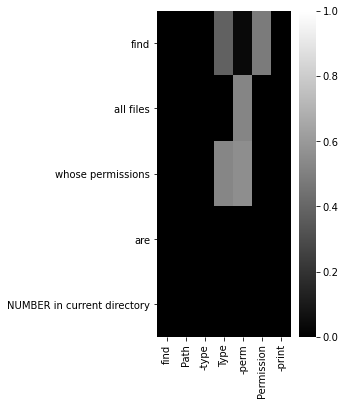

['find', 'Path', '-type', 'Type', '-perm', 'Permission', '-print']
['cd', '-P', 'Directory']


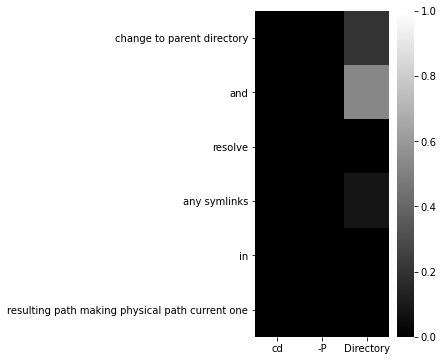

['cd', '-P', 'Directory']
['find', 'Path', '-name', 'Regex']


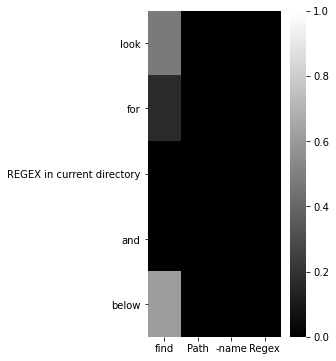

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-type', 'Type', '-and', '-mmin', 'Quantity']


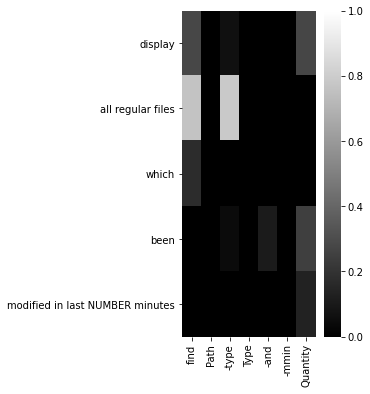

['find', 'Path', '-mmin', 'Quantity', '-type', 'Type']
['find', 'Path', '-name', 'Regex', '-exec', 'chmod', 'Permission', 'File', '\\;']


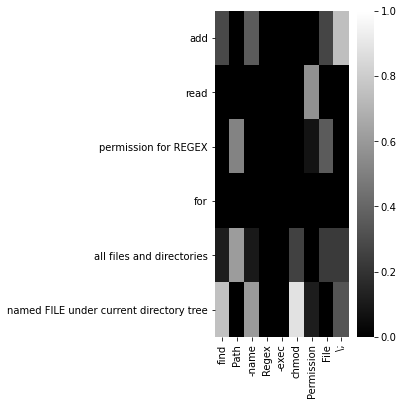

['find', 'Path', '-name', 'Regex', '-exec', 'chmod', 'Permission', 'File', '\\;']
['find', 'Path', '-type', 'Type', '-perm', 'Permission', '-print', '-exec', 'chmod', 'Permission', 'File', '\\;']


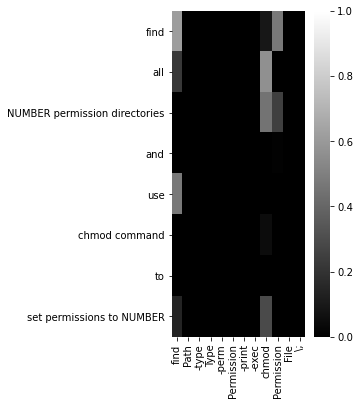

['find', 'Path', '-type', 'Type', '-perm', 'Permission', '-print', '-exec', 'chmod', 'Permission', 'File', '\\;']
['jobs', '-l']


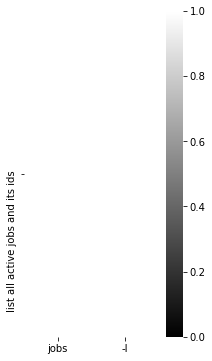

['jobs', '-l']
['find', 'Path', '-name', 'Regex']


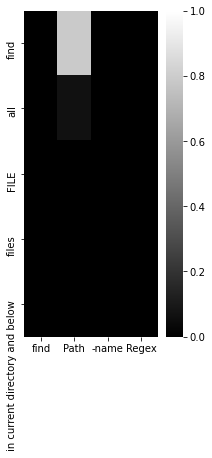

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-mtime', 'Timespan']


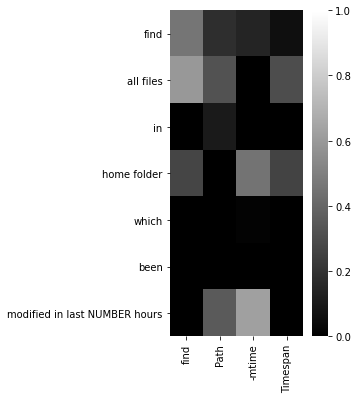

['find', 'Path', '-mtime', 'Timespan']
['mount', '-o', 'Option', 'Regex']


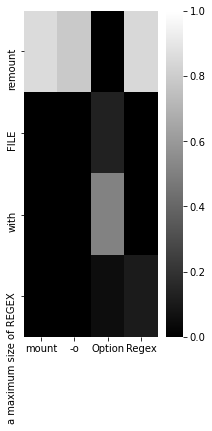

['mount', 'Regex', '-o', 'Option']
['find', 'Path', '-group', 'Regex']


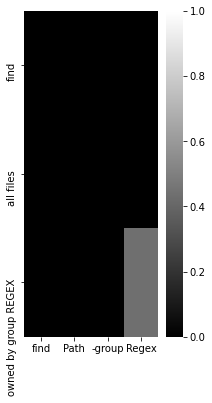

['find', 'Path', '-group', 'Regex']
['find', 'Path', '-newermt', 'Regex']


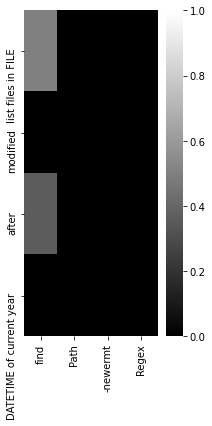

['find', 'Path', '-newermt', 'Regex']
['find', 'Path', '-type', 'Type', '|', 'xargs', '-I', 'ReservedWord', 'grep', 'Regex', 'ReservedWord']


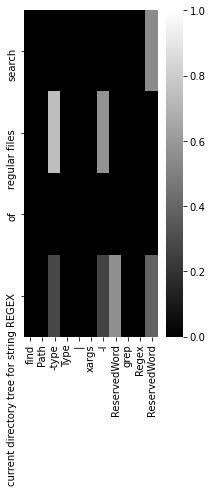

['find', 'Path', '-type', 'Type', '|', 'xargs', '-I', 'ReservedWord', 'grep', 'Regex', 'ReservedWord']
['find', 'Path', '-name', 'Regex']


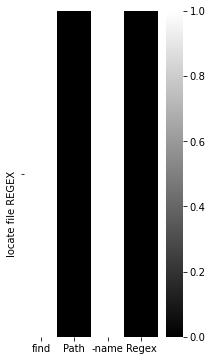

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-size', 'Size']


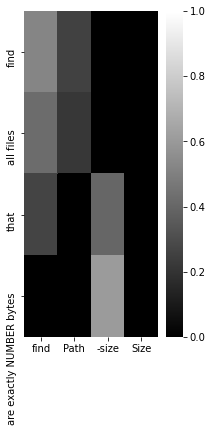

['find', 'Path', '-size', 'Size']
['mkdir', 'Directory']


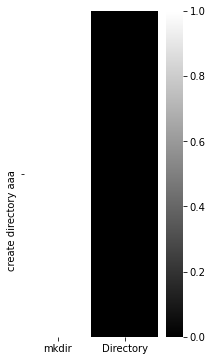

['mkdir', 'Directory']
['find', 'Path', '-mtime', 'Timespan']


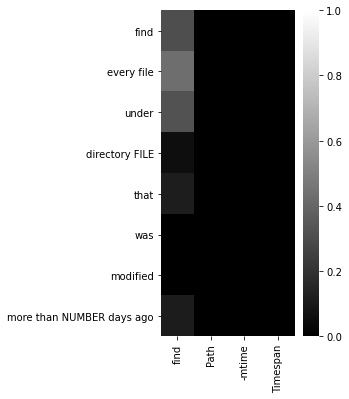

['find', 'Path', '-mtime', 'Timespan']
['rename', 'Regex', 'Regex']


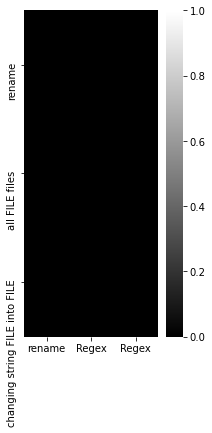

['rename', 'Regex']
['find', 'Path', '-type', 'Type', '-exec', 'grep', 'Regex', 'File', '\\;']


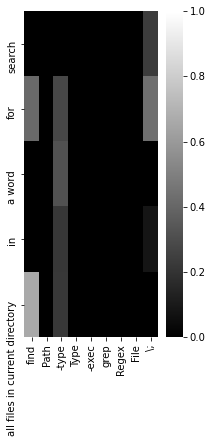

['find', 'Path', '-type', 'Type', '-exec', 'grep', 'Regex', 'File', '\\;']
['find', 'Path', '-name', 'Regex']


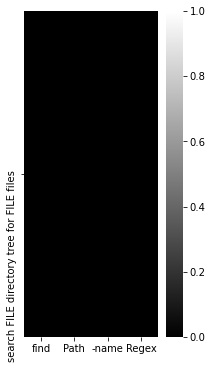

['find', 'Path', '-name', 'Regex']
['df', '-h', 'File']


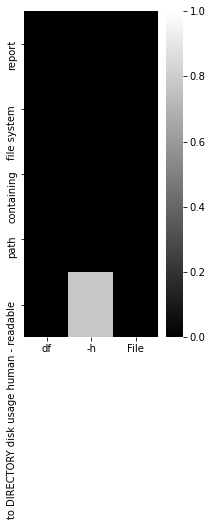

['df', '-h', 'File']
['chmod', 'Permission', 'File', 'File']


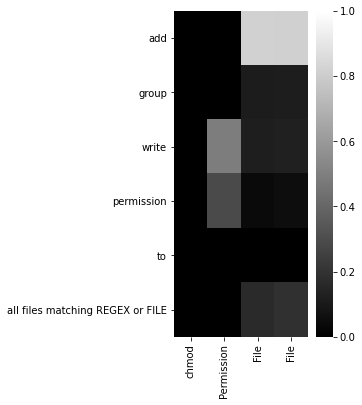

['chmod', 'Permission', 'File']
['find', 'Path', '\\(', '-name', 'Regex', '-prune', '\\)', '-and', '\\(', '-name', 'Regex', '-prune', '\\)', '-or', '\\(', '-name', 'Regex', '-print', '\\)']


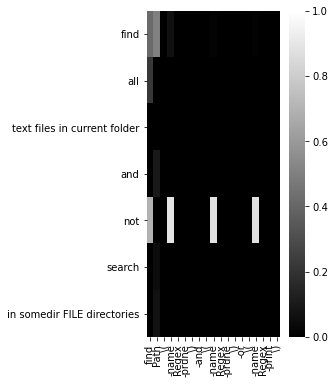

['find', 'Path', '-name', 'Regex', '-prune', '-or', '-name', 'Regex', '-print']
['find', 'Path', '-name', 'Regex']


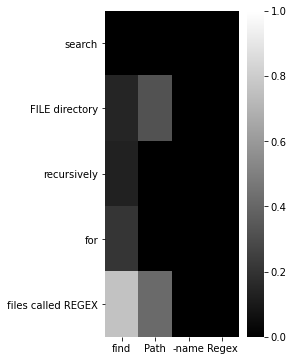

['find', 'Path', '-name', 'Regex']
['echo', 'Regex', '|', 'read', 'Regex']


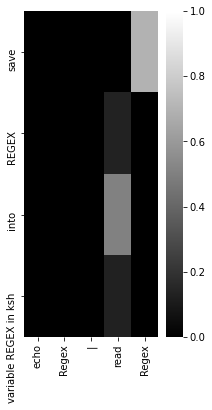

['echo', 'Regex', '|', 'read', 'Regex']
['find', 'Path', '-type', 'Type']


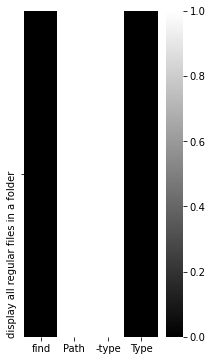

['find', 'Path', '-type', 'Type']
['find', 'Path', '-name', 'Regex']


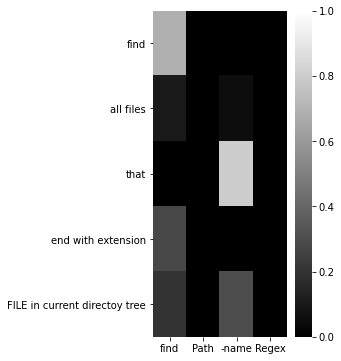

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-name', 'Regex', '-print0', '|', 'xargs', '-0', '-I', 'ReservedWord', 'mv', 'ReservedWord', 'File']


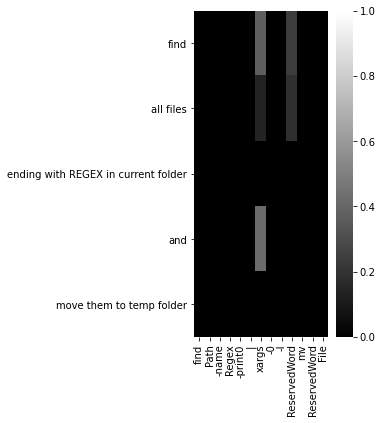

['find', 'Path', '-name', 'Regex', '-print0', '|', 'xargs', '-0', '-I', 'ReservedWord', 'mv', 'ReservedWord', 'File']
['find', 'Path', '-name', 'Regex', '|', 'xargs', '-I', 'ReservedWord', 'rename', 'Regex', 'ReservedWord']


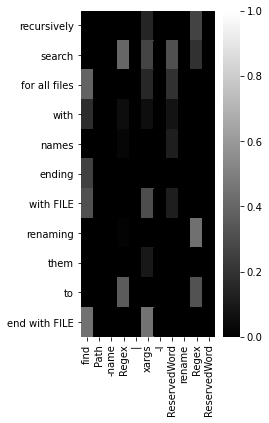

['find', 'Path', '-name', 'Regex', '|', 'xargs', '-I', 'ReservedWord', 'rename', 'Regex', 'ReservedWord']
['find', 'Path', '-size', 'Size']


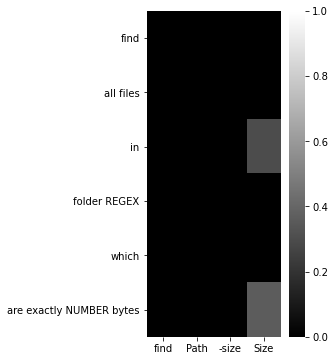

['find', 'Path', '-size', 'Size']
['rev', 'File']


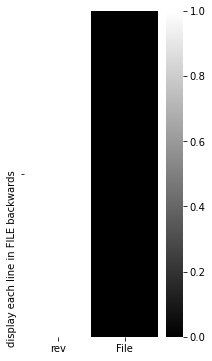

['rev', 'File']
['find', 'Path', '-type', 'Type', '-empty']


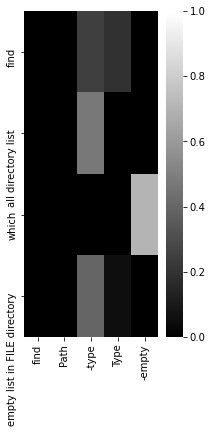

['find', 'Path', '-type', 'Type', '-empty']
['find', 'Path', '-size', 'Size']


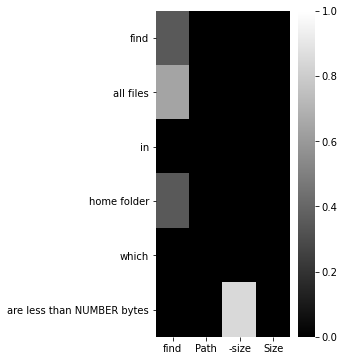

['find', 'Path', '-size', 'Size']
['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']


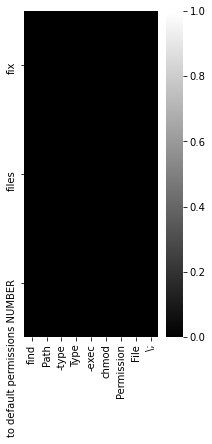

['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']
['echo', '-n', 'Regex', '|', 'md5sum']


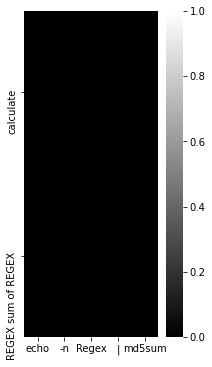

['echo', '-n', 'Regex', '|', 'md5sum']
['read', '-n', 'Quantity', 'Regex']


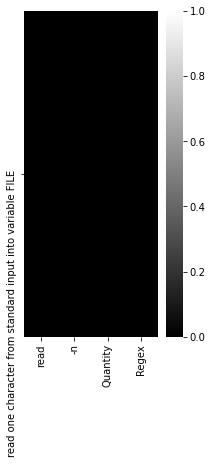

['read', '-n', 'Quantity']
['mkdir', 'Directory', 'Directory', 'Directory']


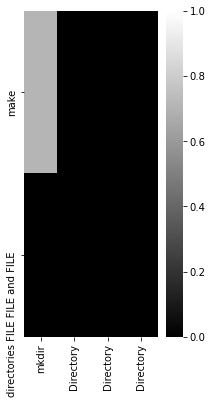

['mkdir', 'Directory']
['find', 'Path', '-type', 'Type', '-and', '!', '-name', 'Regex', '-or', '-name', 'Regex', '-and', '!', '-prune']


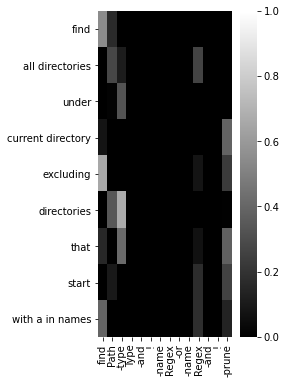

['find', 'Path', '-type', 'Type', '-and', '!', '-name', 'Regex', '-or', '!', '-prune']
['find', 'Path', '-type', 'Type', '-name', 'Regex']


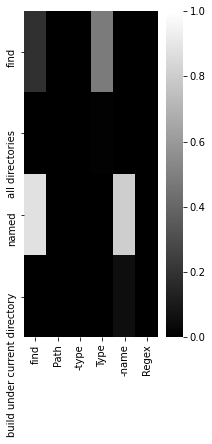

['find', 'Path', '-type', 'Type', '-name', 'Regex']
['cat', 'File', '|', 'paste', '-d', 'Regex', 'File', 'File']


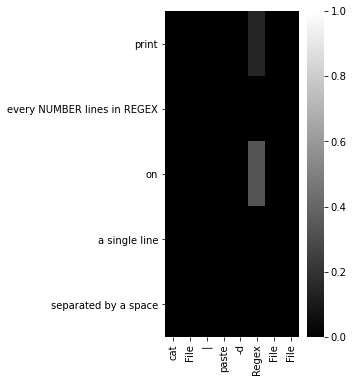

['cat', 'File', '|', 'paste', '-d', 'Regex', 'File']
['find', 'Path', '-empty', '-type', 'Type', '-delete']


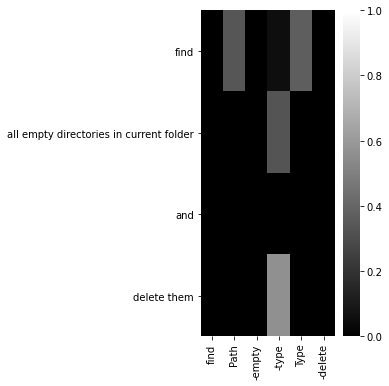

['find', 'Path', '-type', 'Type', '-empty', '-delete']
['df', '-h', 'File']


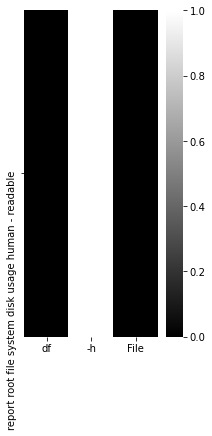

['df', '-h']
['find', 'Path', '-maxdepth', 'Quantity', '-type', 'Type']


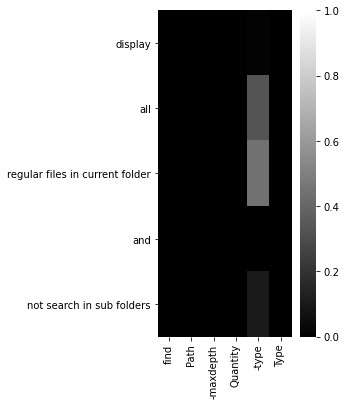

['find', 'Path', '-maxdepth', 'Quantity', '-type', 'Type']
['find', 'Path', '!', '-name', 'Regex', '-prune']


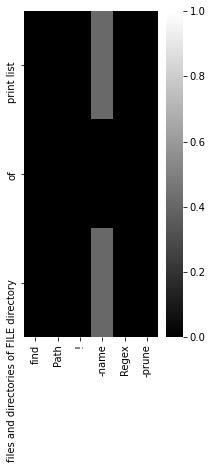

['find', 'Path', '!', '-name', 'Regex']
['find', 'Path', '-iname', 'Regex']


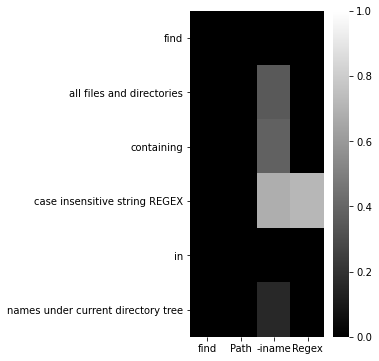

['find', 'Path', '-iname', 'Regex']
['find', 'Path']


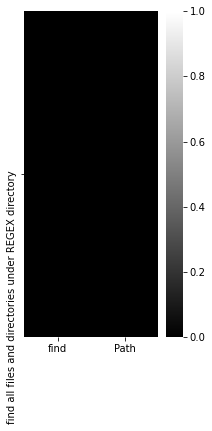

['find', 'Path']
['find', 'Path', '-user', 'Regex']


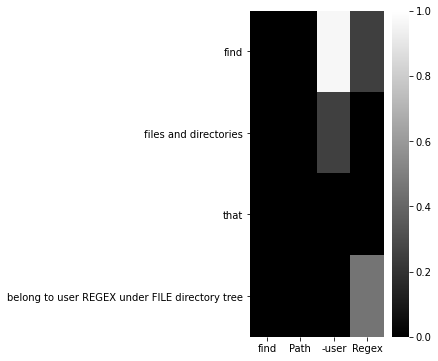

['find', 'Path', '-user', 'Regex']
['column', '-t', '-s', 'Regex', 'File']


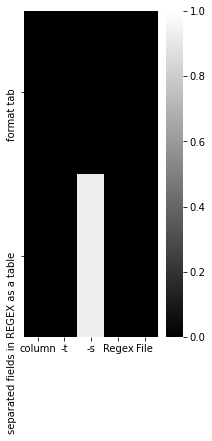

['column', '-t', '-s', 'Regex', 'File']
['find', 'Path', '-mtime', 'Timespan']


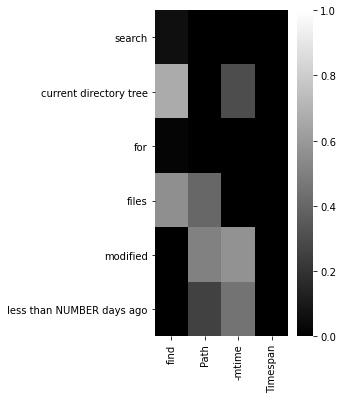

['find', 'Path', '-mtime', 'Timespan']
['find', 'Path', 'Path', '-type', 'Type']


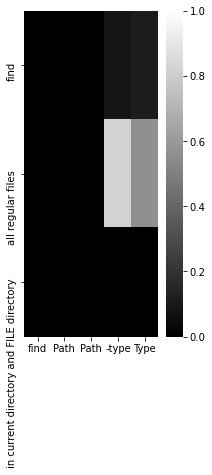

['find', 'Path', '-type', 'Type']
['find', 'Path', '-type', 'Type', '-mtime', 'Timespan', '-exec', 'compress', 'File', 'File', '\\;']


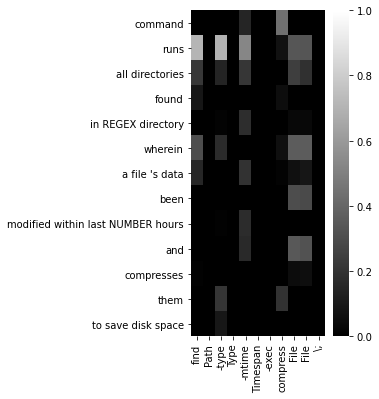

['find', 'Path', '-type', 'Type', '-mtime', 'Timespan', '-exec', 'compress', 'File', '\\;']
['find', 'Path', '-name', 'Regex', '!', '-name', 'Regex', '-prune']


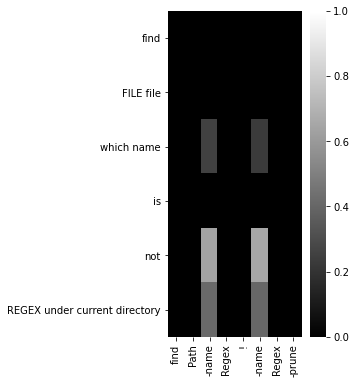

['find', 'Path', '-not', '-name', 'Regex']
['yes', '|', 'head', '-n', 'Quantity', '|', 'awk', 'Program']


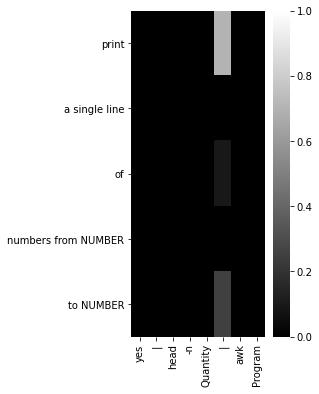

['yes', '|', 'head', '-n', 'Quantity', '|', 'awk', 'Program']
['chmod', '-R', 'Permission', 'File']


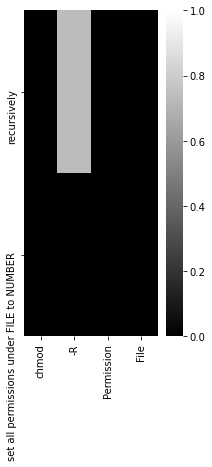

['chmod', 'Permission', '-R', 'File']
['find', 'Path', '-type', 'Type', '-size', 'Size']


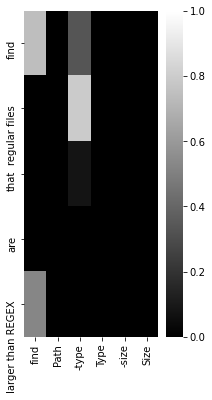

['find', 'Path', '-type', 'Type', '-size', 'Size']
['find', 'Path', '-type', 'Type']


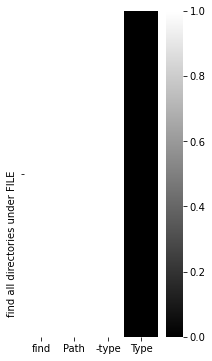

['find', 'Path', '-type', 'Type']
['find', 'Path', '-maxdepth', 'Quantity', '-type', 'Type']


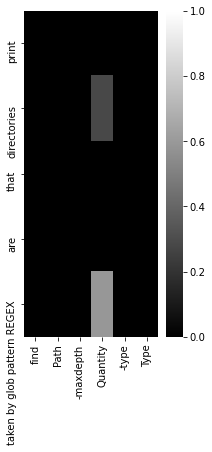

['find', 'Path', '-maxdepth', 'Quantity', '-type', 'Type']
['ln', '-f', '-s', 'File', 'Regex']


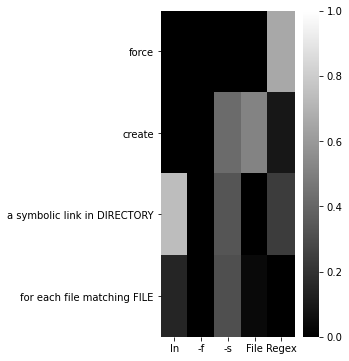

['ln', '-s', '-f', 'File', 'Regex']
['find', 'Path', '-name', 'Regex']


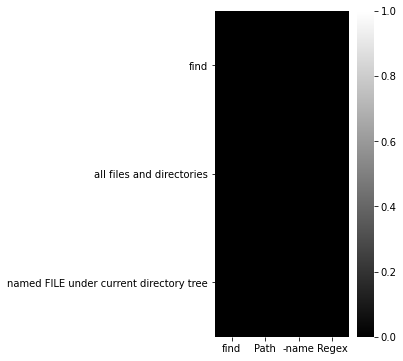

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-name', 'Regex']


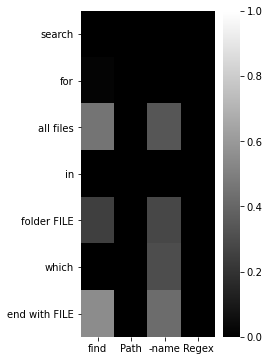

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-type', 'Type']


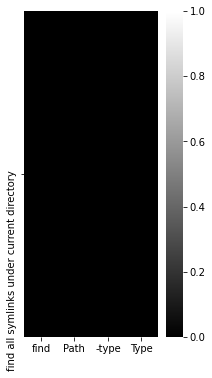

['find', 'Path', '-type', 'Type']
['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']


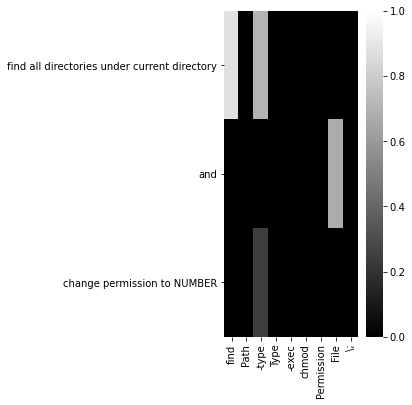

['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']
['find', 'Path', '-type', 'Type', '-name', 'Regex']


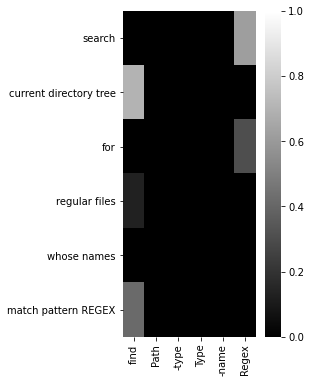

['find', 'Path', '-name', 'Regex', '-type', 'Type']
['find', 'Path', '-name', 'Regex']


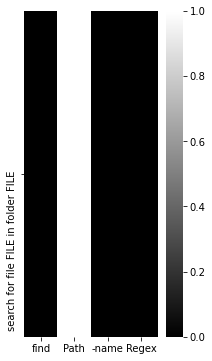

['find', 'Path', '-name', 'Regex']
['chmod', 'Permission', 'File', 'File', 'File']


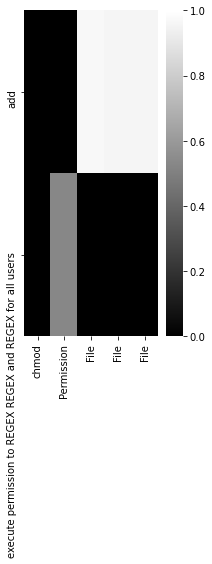

['chmod', 'Permission', 'File']
['ping', '-c', 'Quantity', 'Regex']


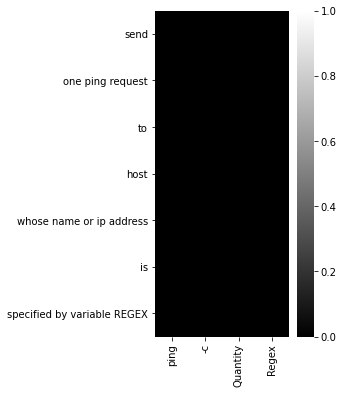

['ping', 'Regex', '-c', 'Quantity']
['ln', '-f', 'File', 'Regex']


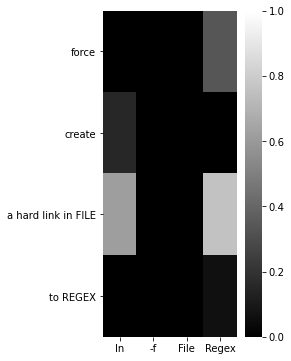

['ln', '-f', 'File', 'Regex']
['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']


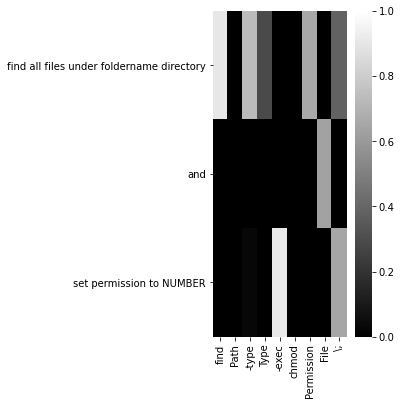

['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']
['find', 'Path', '-name', 'Regex']


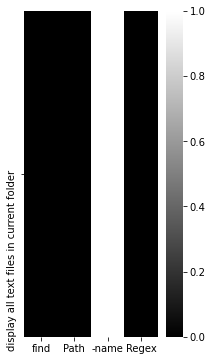

['find', 'Path', '-name', 'Regex']
['chown', 'Regex', 'File']


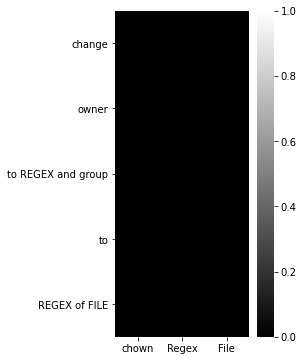

['chown', 'Regex', 'File']
['cal', '|', 'awk', 'Program']


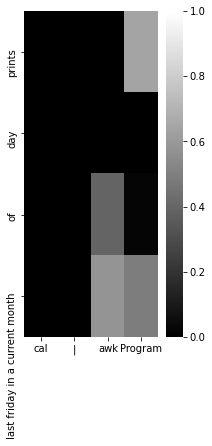

['cal', '|', 'awk', 'Program']
['find', 'Path', '-type', 'Type', '-empty']


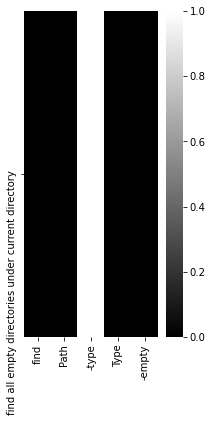

['find', 'Path', '-type', 'Type', '-empty']
['split', '-l', 'Quantity']


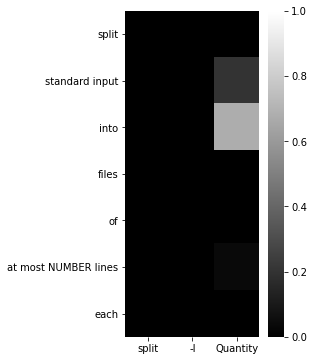

['split', '-l', 'Quantity', 'File']
['history', '|', 'awk', 'Program']


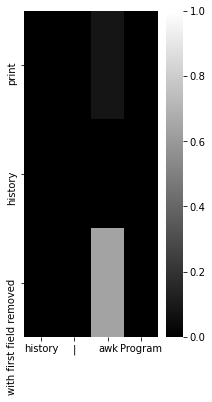

['history', '|', 'awk', 'Program']
['find', 'Path', '-type', 'Type', '-iname', 'Regex']


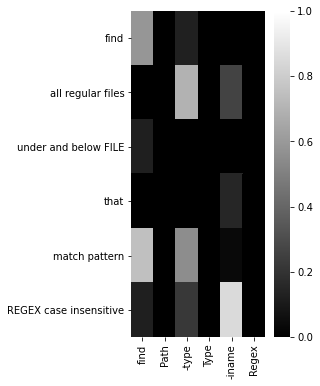

['find', 'Path', '-type', 'Type', '-iname', 'Regex']
['echo', 'Regex', '|', 'rev', '|', 'cut', '-d', 'Regex', '-f', 'Number', '|', 'rev']


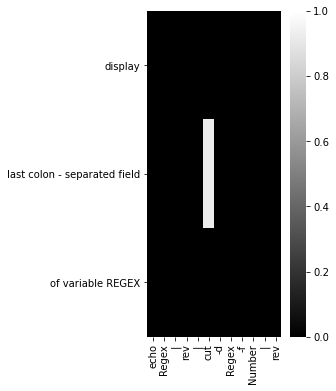

['echo', 'Regex', '|', 'rev', '|', 'cut', '-d', 'Regex', '-f', 'Number', '|', 'rev']
['echo', '-e', '$(echo', '-n', '-e', 'Regex', '|', 'wc', '-m)']


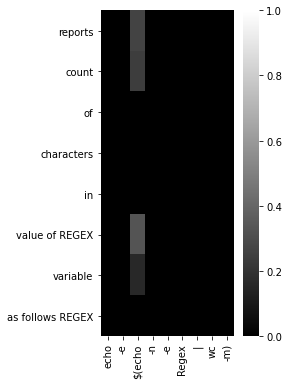

['echo', '-e', '$(echo', '-n', '-e', 'Regex', '|', 'wc', '-m)']
['read', '-p', 'Regex', 'Regex']


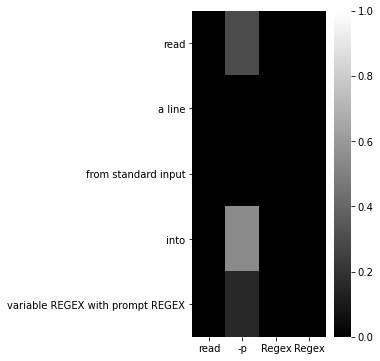

['read', '-p', 'Regex']
['find', 'Path', '-type', 'Type']


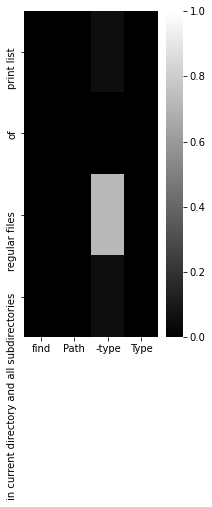

['find', 'Path', '-type', 'Type']
['find', 'Path', '-name', 'Regex']


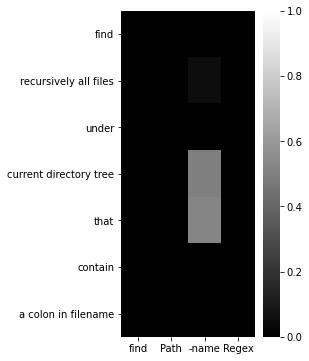

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-name', 'Regex', '-type', 'Type']


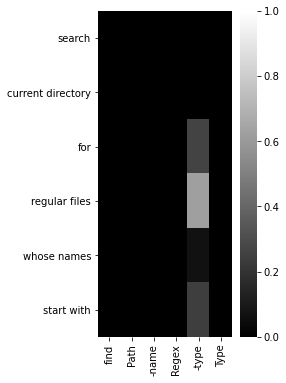

['find', 'Path', '-type', 'Type', '-name', 'Regex']
['find', 'Path', '-atime', 'Timespan']


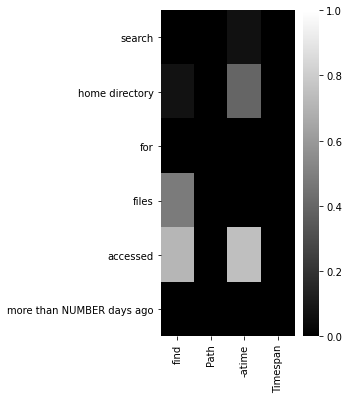

['find', 'Path', '-atime', 'Timespan']
['find', 'Path', '-name', 'Regex', '|', 'grep', 'Regex']


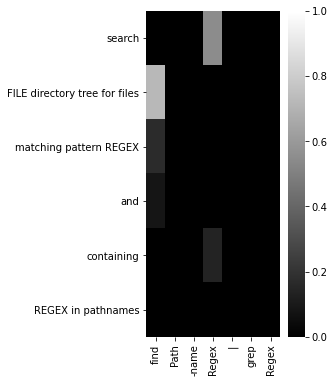

['find', 'Path', '-name', 'Regex', '|', 'grep', 'Regex']
['ssh-keygen', '-l', '-f', 'File']


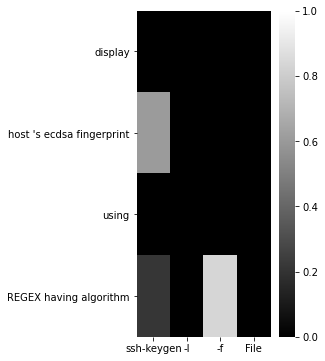

['ssh-keygen', '-l', 'File', '-f', 'File']
['find', 'Path', '-name', 'Regex']


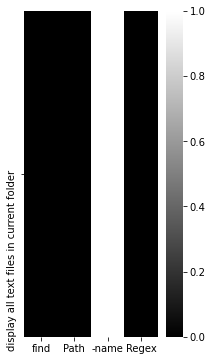

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-iname', 'Regex']


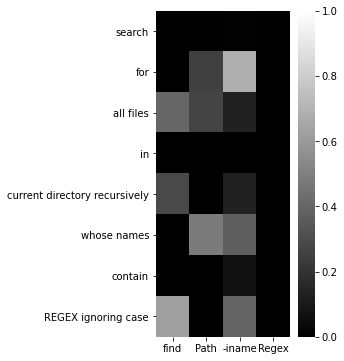

['find', 'Path', '-iname', 'Regex']
['find', 'Path', '-iname', 'Regex']


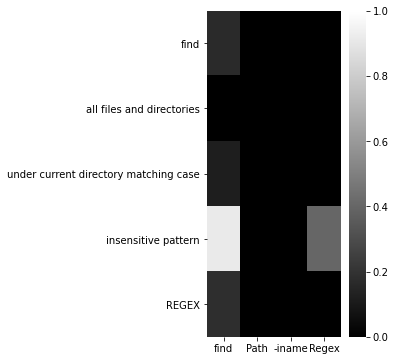

['find', 'Path', '-iname', 'Regex']
['find', 'Path', '-atime', 'Timespan']


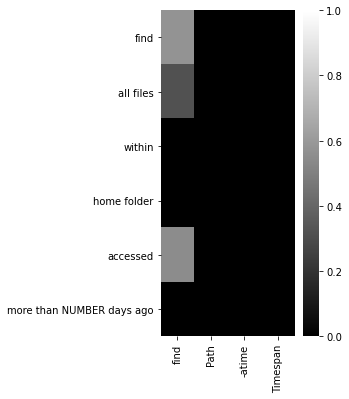

['find', 'Path', '-atime', 'Timespan']
['find', 'Path', '-mindepth', 'Quantity', '-name', 'Regex']


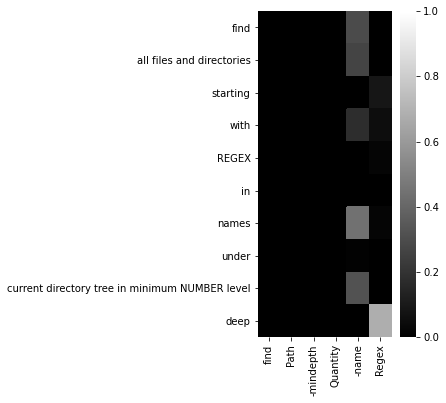

['find', 'Path', '-mindepth', 'Quantity', '-name', 'Regex']
['read', '-r', 'Regex']


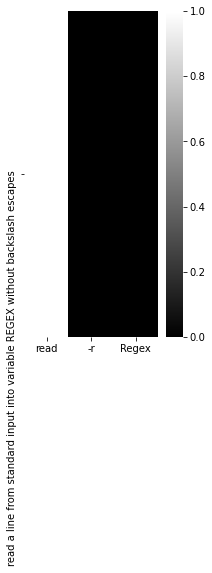

['read', '-r', 'Regex']
['gzip', 'Regex']


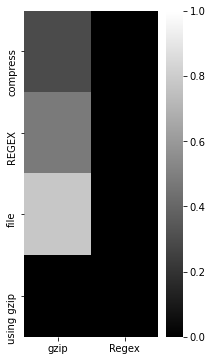

['gzip', 'Regex']
['find', 'Path', '-name', 'Regex', '-exec', 'grep', '-l', 'Regex', 'File', '\\;']


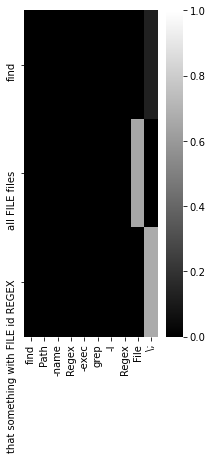

['find', 'Path', '-name', 'Regex', '-exec', 'grep', '-l', 'Regex', 'File', '\\;']
['chown', 'Regex', 'File', 'File']


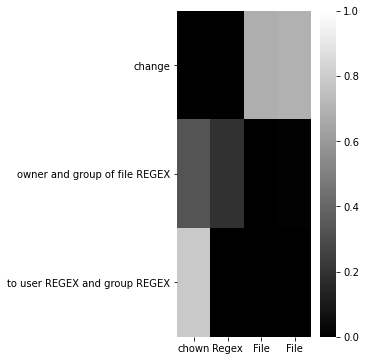

['chown', 'Regex', 'File']
['find', 'Path', 'Path', 'Path', '-name', 'Regex', '-type', 'Type']


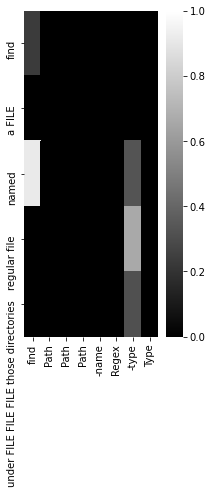

['find', 'Path', '-type', 'Type', '-name', 'Regex']
['find', 'Path', '-type', 'Type', '-iwholename', 'Regex', '-exec', 'grep', '-H', 'Regex', 'File', '\\;']


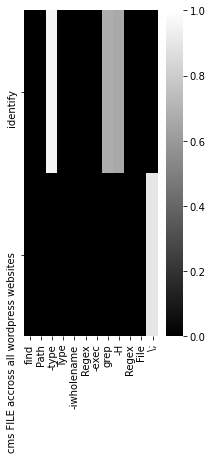

['find', 'Path', '-type', 'Type', '-iwholename', 'Regex', '-exec', 'grep', '-H', 'Regex', 'File', '\\;']
['find', 'Path', '-type', 'Type', '-atime', 'Timespan']


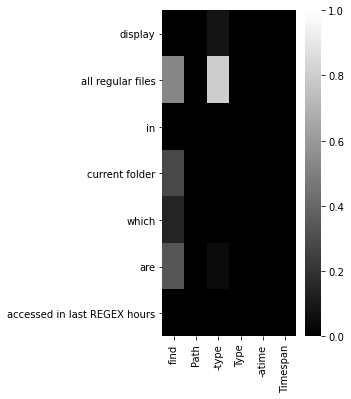

['find', 'Path', '-type', 'Type', '-atime', 'Timespan']
['find', 'Path', '-path', 'Regex', '-prune', '-or', '-print']


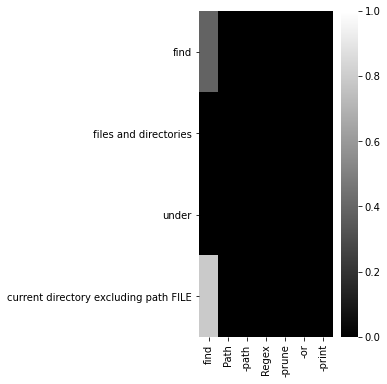

['find', 'Path', '-path', 'Regex', '-prune', '-or', '-print']
['find', 'Path', '-name', 'Regex']


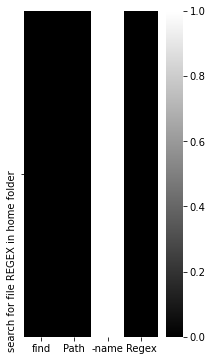

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-perm', 'Permission', '-type', 'Type', '-exec', 'ls', '-l', 'File', '\\;']


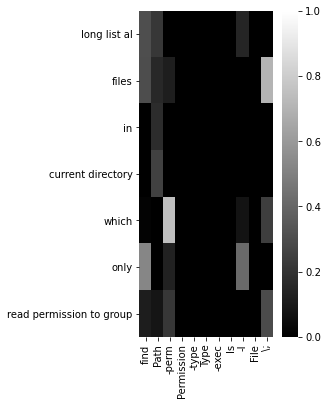

['find', 'Path', '-perm', 'Permission', '-type', 'Type', '-exec', 'ls', '-l', 'File', '\\;']
['find', 'Path', '-name', 'Regex']


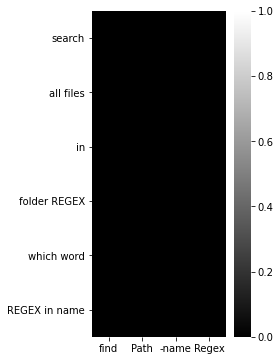

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-type', 'Type', '-size', 'Size', '-exec', 'ls', '-l', '-h', 'File', '\\;', '|', 'awk', 'Program']


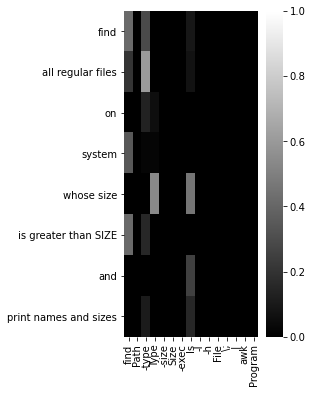

['find', 'Path', '-type', 'Type', '-size', 'Size', '-exec', 'ls', '-l', '-h', 'File', '\\;', '|', 'awk', 'Program']
['find', 'Path', '-amin', 'Quantity']


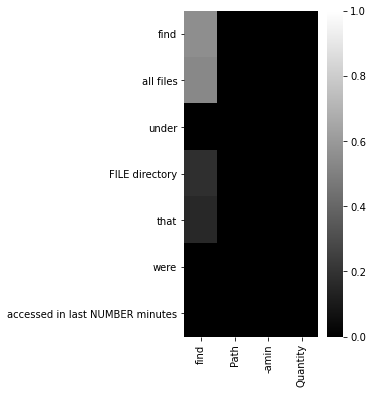

['find', 'Path', '-amin', 'Quantity']
['readlink', '-f', 'File']


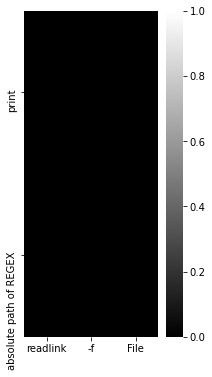

['readlink', '-f', 'File']
['find', 'Path', '-name', 'Regex']


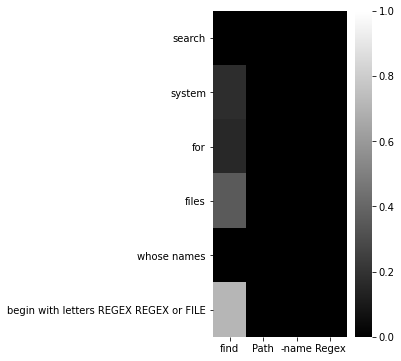

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-type', 'Type', '\\(', '-name', 'Regex', '-or', '-name', 'Regex', '\\)']


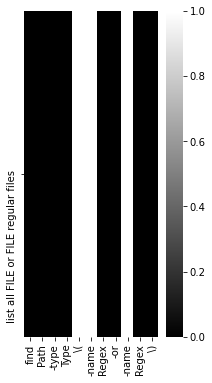

['find', 'Path', '-name', 'Regex', '-type', 'Type']
['find', 'Path', '-name', 'Regex']


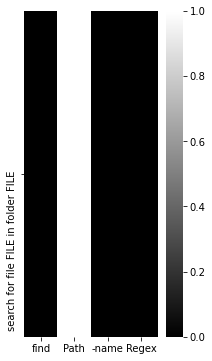

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-type', 'Type', '-perm', 'Permission']


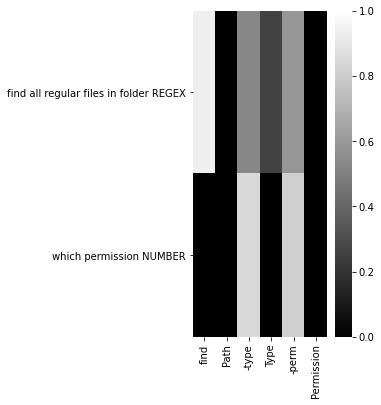

['find', 'Path', '-type', 'Type', '-perm', 'Permission']
['diff', '-y', 'File', 'File']


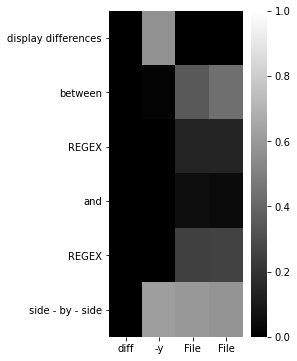

['diff', '-y', 'File', 'File']
['chgrp', 'Regex', 'File']


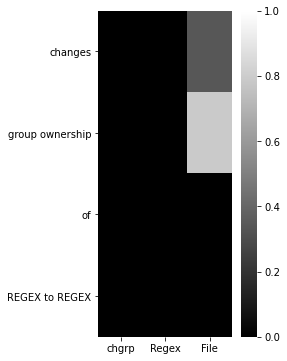

['chgrp', 'Regex', 'File']
['ifconfig', 'Regex', '|', 'grep', 'Regex']


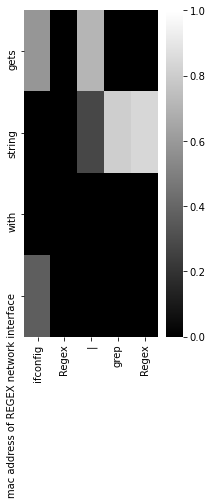

['ifconfig', 'Regex', '|', 'grep', 'Regex']
['rsync', '-u', '-r', '--delete', 'File', 'File']


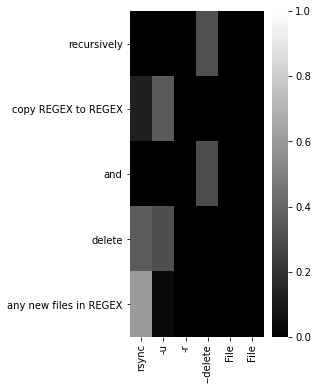

['rsync', '-u', '-r', '--delete', 'File']
['find', 'Path', '-type', 'Type']


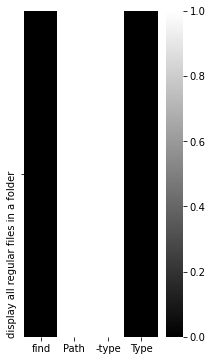

['find', 'Path', '-type', 'Type']
['find', 'Path', '-name', 'Regex', '-exec', 'rm', 'File', '\\;']


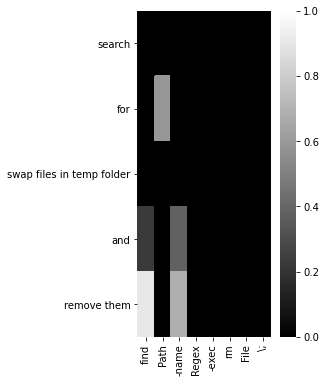

['find', 'Path', '-name', 'Regex', '-exec', 'rm', 'File', '\\;']
['find', 'Path', '-name', 'Regex', '|', 'grep', '-f', '<(sed', 'Program', 'File)']


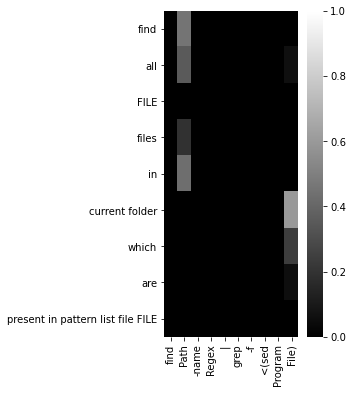

['find', 'Path', '-name', 'Regex', '|', 'grep', '-f', '<(sed', 'Program', 'File)']
['find', 'Path', '-type', 'Type']


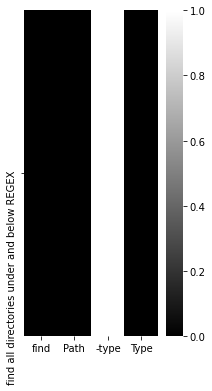

['find', 'Path', '-type', 'Type']
['chgrp', '-R', 'Regex', 'File']


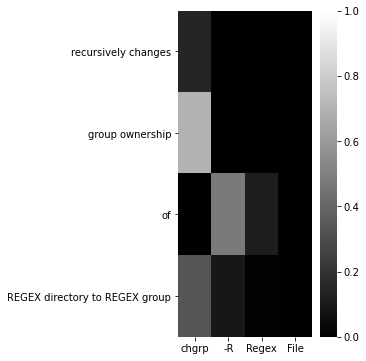

['chgrp', '-R', 'Regex', 'File']
['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']


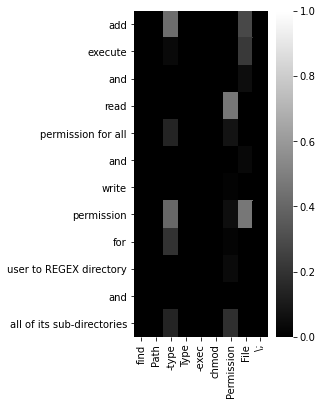

['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']
['readlink', '-f', 'File']


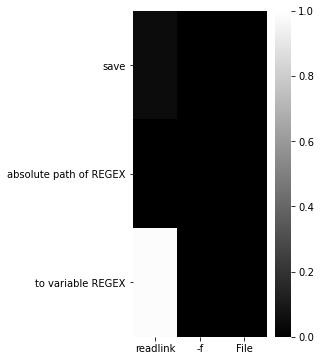

['readlink', '-f', 'File']
['find', 'Path', 'Path', '-name', 'Regex', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']


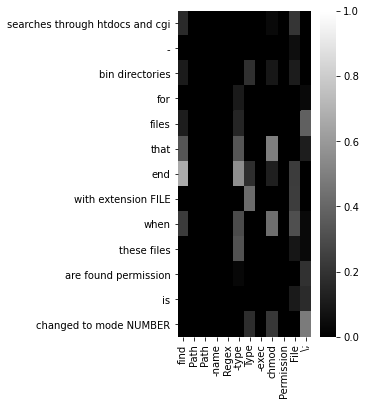

['find', 'Path', '-name', 'Regex', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']
['find', 'Path', '-user', 'Regex']


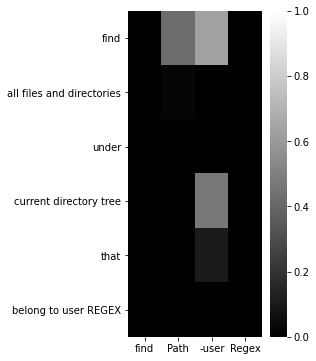

['find', 'Path', '-user', 'Regex']
['find', 'Path', '-size', 'Size']


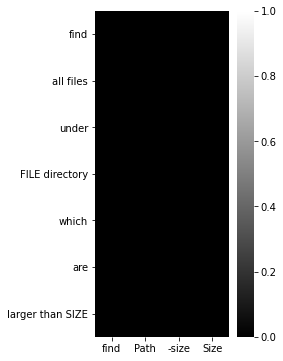

['find', 'Path', '-size', 'Size']
['find', 'Path', '!', '\\(', '-name', 'Regex', '-prune', '\\)', '-type', 'Type', '-mtime', 'Timespan', '-print0']


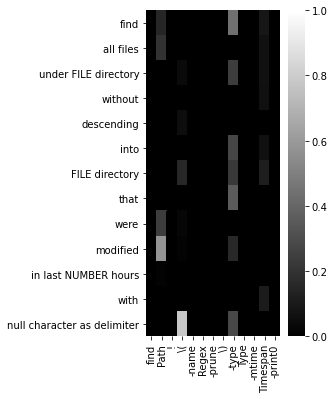

['find', 'Path', '-name', 'Regex', '-prune', '-or', '\\(', '-type', 'Type', '-mtime', 'Timespan', '-print0', '\\)']
['chown', 'Regex', 'File']


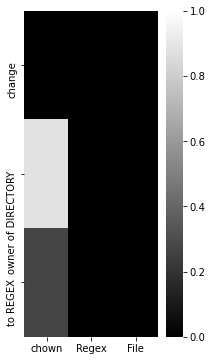

['chown', 'Regex', 'File']
['ln', '-s', 'File', 'Regex']


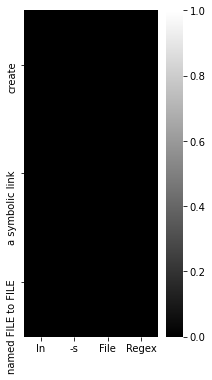

['ln', '-s', 'File', 'Regex']
['echo', '$(pwd)', '|', 'crontab']


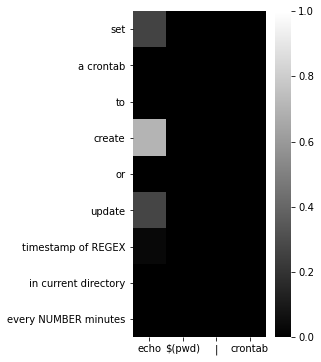

['echo', '$(pwd)', '|', 'crontab']
['shopt', '-s', 'Option']


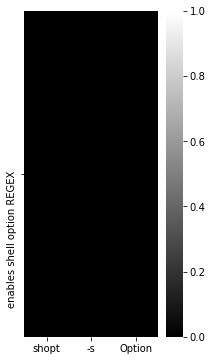

['shopt', '-s', 'Option']
['uname', '-a']


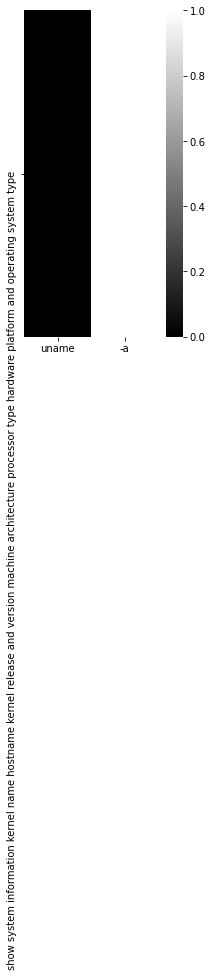

['uname', '-a']
['find', 'Path', '-mmin', 'Quantity']


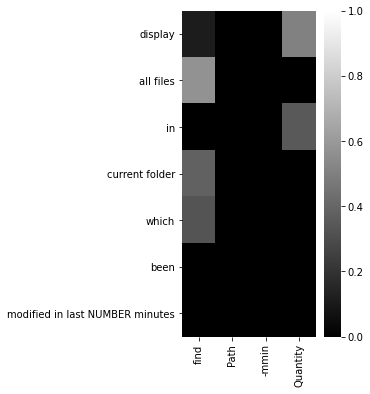

['find', 'Path', '-mmin', 'Quantity']
['find', 'Path', '-name', 'Regex']


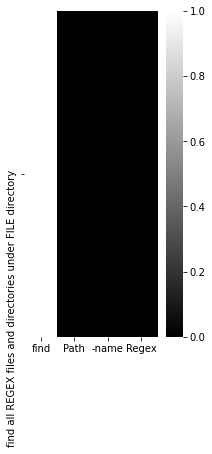

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-mtime', 'Timespan']


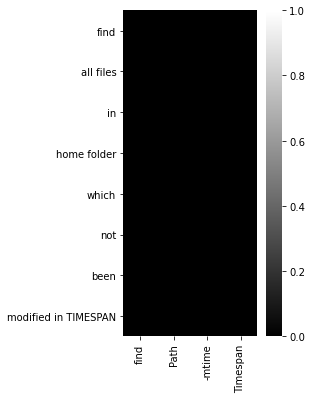

['find', 'Path', '-mtime', 'Timespan']
['ln', '-s', 'File', 'Regex']


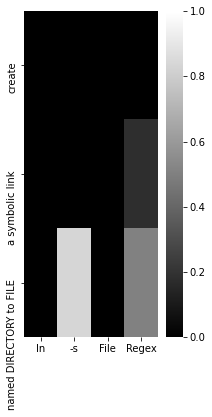

['ln', '-s', 'File', 'Regex']
['find', 'Path', '-not', '\\(', '-path', 'Regex', '-or', '-path', 'Regex', '-prune', '\\)', '-type', 'Type']


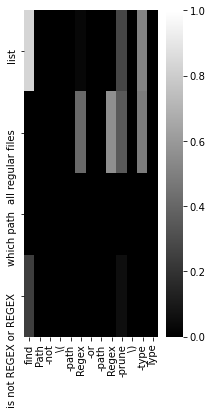

['find', 'Path', '!', '-path', 'Regex', '-type', 'Type']
['find', 'Path', '-inum', 'Quantity', '-exec', 'rm', 'File', '\\;']


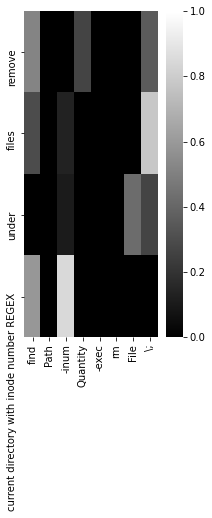

['find', 'Path', '-inum', 'Quantity', '-exec', 'rm', 'File', '\\;']
['split', '-l', 'Quantity', 'File', 'Regex']


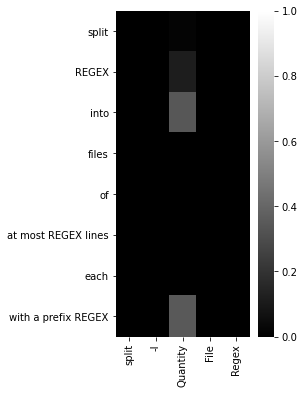

['split', '-l', 'Quantity', 'File', 'Regex']
['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']


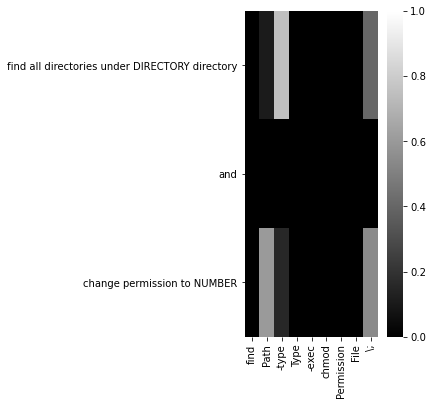

['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']
['find', 'Path', '!', '-name', 'Regex', '-print']


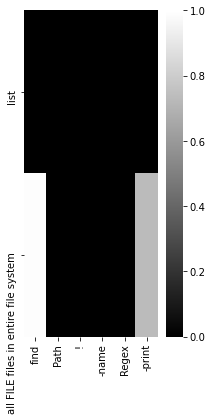

['find', 'Path', '-name', 'Regex', '-print']
['find', 'Path', '-perm', 'Permission']


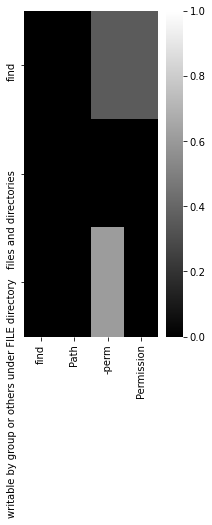

['find', 'Path', '-perm', 'Permission']
['find', 'Path', '-user', 'Regex', '-exec', 'chown', 'Regex', 'File', '\\;']


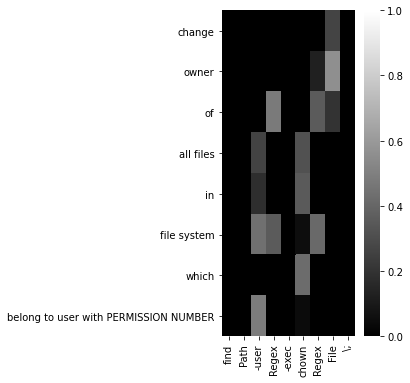

['find', 'Path', '-user', 'Regex', '-exec', 'chown', 'Regex', 'File', '\\;']
['curl', 'Regex', '|', 'sh']


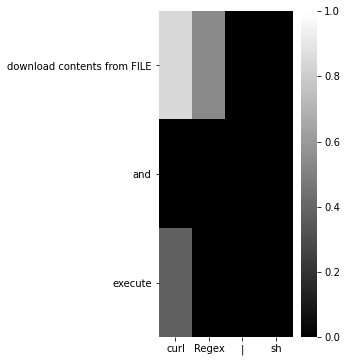

['curl', 'Regex', '|', 'sh']
['find', 'Path', '-name', 'Regex']


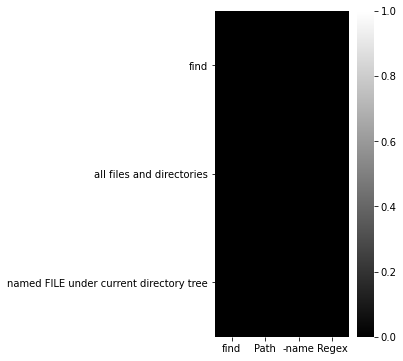

['find', 'Path', '-name', 'Regex']
['ifconfig', 'Regex', '|', 'awk', 'Program']


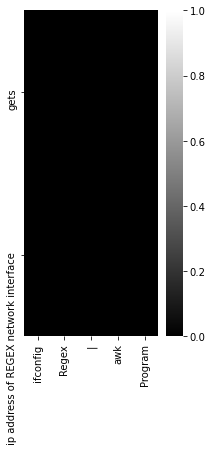

['ifconfig', 'Regex', '|', 'awk', 'Program']
['find', 'Path', '-newerct', 'Regex', '-print']


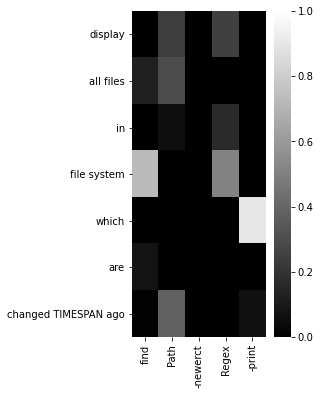

['find', 'Path', '-newerct', 'Regex', '-print']
['find', 'Path', '-type', 'Type', '-perm', 'Permission', '-print', '-exec', 'chmod', 'Permission', 'File', '\\;']


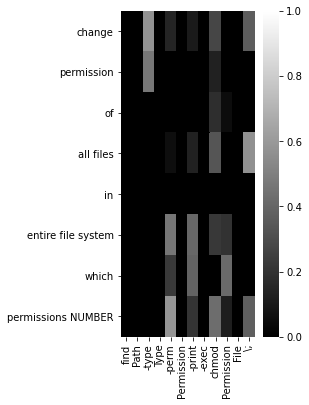

['find', 'Path', '-type', 'Type', '-perm', 'Permission', '-print', '-exec', 'chmod', 'Permission', 'File', '\\;']
['find', 'Path', '-name', 'Regex', '-maxdepth', 'Quantity']


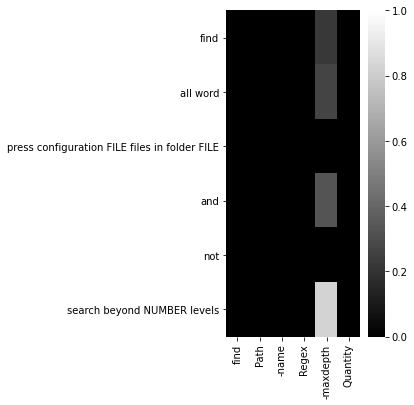

['find', 'Path', '-maxdepth', 'Quantity', '-name', 'Regex']
['find', 'Path', '-type', 'Type', '-mtime', 'Timespan']


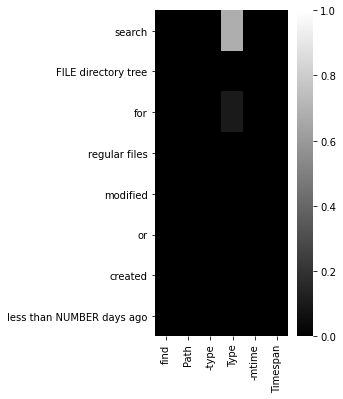

['find', 'Path', '-type', 'Type', '-mtime', 'Timespan']
['find', 'Path', '-type', 'Type', '-mtime', 'Timespan', '-exec', 'gzip', 'Regex', '\\;']


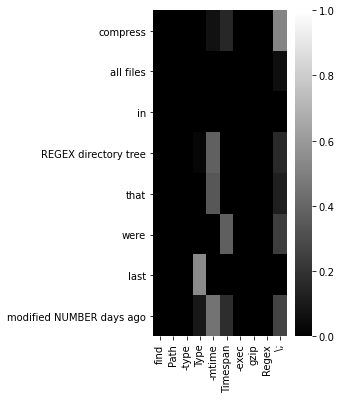

['find', 'Path', '-type', 'Type', '-mtime', 'Timespan', '-exec', 'gzip', 'Regex', '\\;']
['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '+']


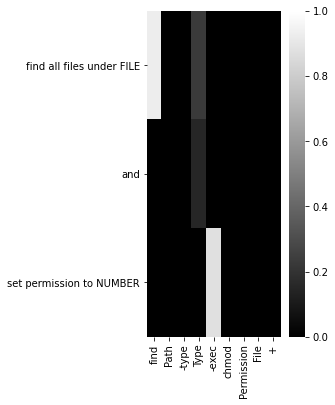

['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '+']
['basename', '--', 'Regex']


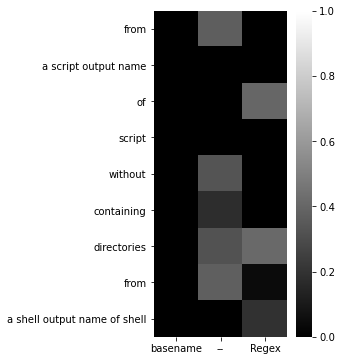

['basename', 'Regex']
['find', 'Path', '-perm', 'Permission']


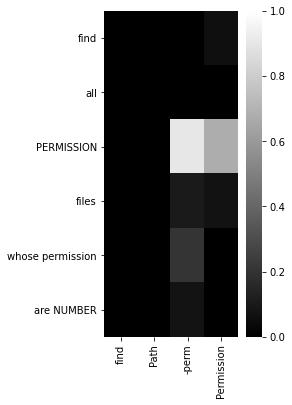

['find', 'Path', '-perm', 'Permission']
['chown', '-R', 'Regex', 'File']


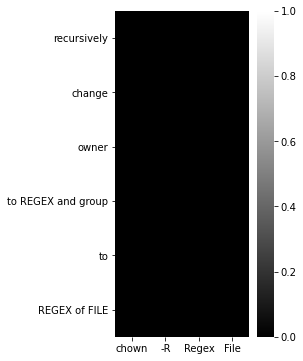

['chown', '-R', 'Regex', 'File']
['grep', 'Regex', 'File', '|', 'sort', '-u', '|', 'wc', '-l']


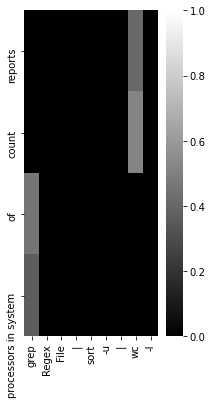

['grep', 'Regex', 'File', '|', 'sort', '-u', '|', 'wc', '-l']
['find', 'Path', '-name', 'Regex']


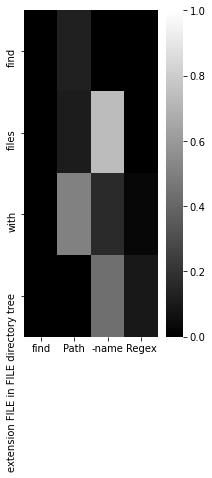

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-type', 'Type', '-mtime', 'Timespan', '-exec', 'rm', 'File', '\\;']


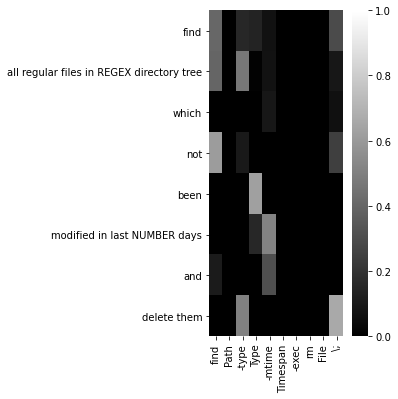

['find', 'Path', '-type', 'Type', '-mtime', 'Timespan', '-exec', 'rm', 'File', '\\;']
['find', 'Path', '-perm', 'Permission']


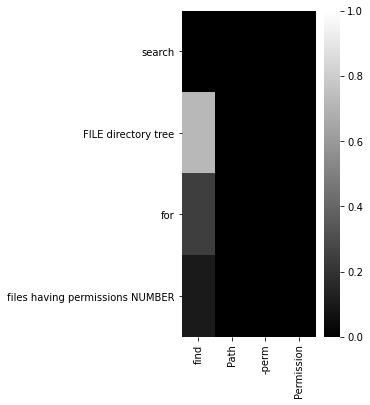

['find', 'Path', '-perm', 'Permission']
['chown', 'Regex', '-R', 'File']


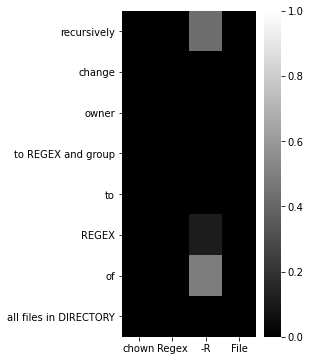

['chown', '-R', 'Regex', 'File']
['chown', 'Regex', 'File', 'File']


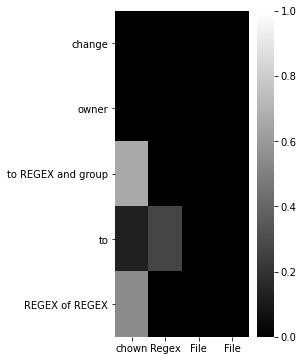

['chown', 'Regex', 'File']
['find', 'Path', '-name', 'Regex', '-printf', 'Format', '|', 'sort', '-u']


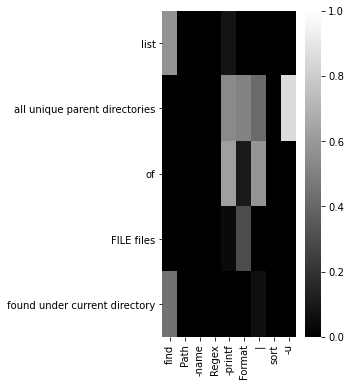

['find', 'Path', '-name', 'Regex', '-printf', 'Format', '|', 'sort', '-u']
['find', 'Path', '-type', 'Type', '-exec', 'grep', '-l', 'Regex', 'File', '\\;']


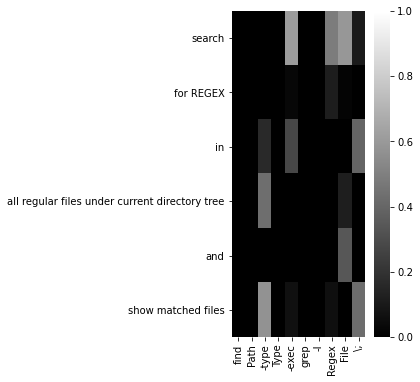

['find', 'Path', '-type', 'Type', '-exec', 'grep', '-l', 'Regex', 'File', '\\;']
['find', 'Path', '-mtime', 'Timespan', '-type', 'Type']


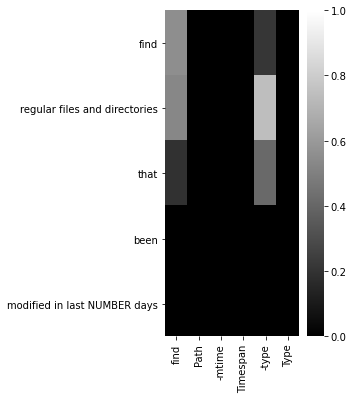

['find', 'Path', '-mtime', 'Timespan', '-type', 'Type']
['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']


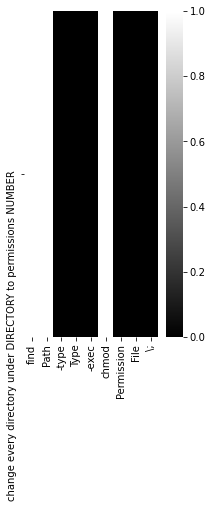

['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']
['find', 'Path', '-name', 'Regex']


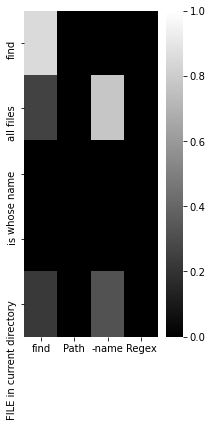

['find', 'Path', '-name', 'Regex']
['mv', 'File', 'File']


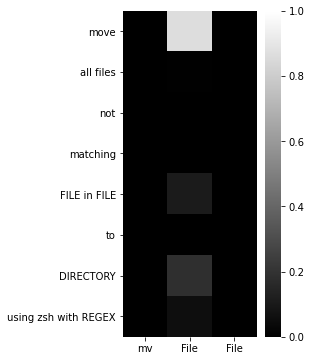

['mv', 'File', 'File']
['find', 'Path', '-perm', 'Permission']


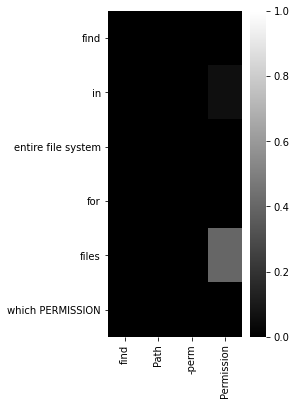

['find', 'Path', '-perm', 'Permission']
['source', '$(dirname', 'Regex)']


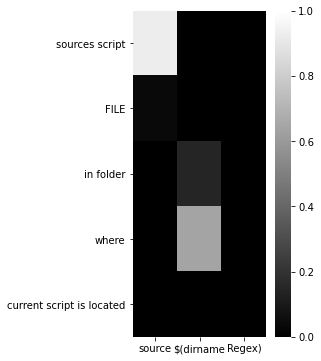

['source', '$(dirname', 'Regex)']
['rename', 'Regex', 'Regex']


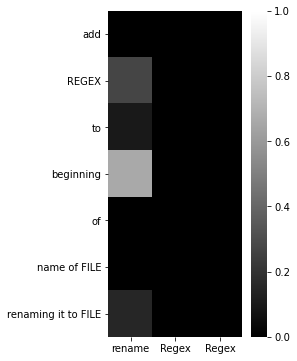

['rename', 'Regex']
['find', 'Path', '-name', 'Regex', '-type', 'Type']


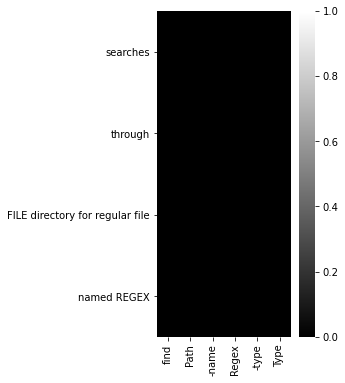

['find', 'Path', '-name', 'Regex', '-type', 'Type']
['find', 'Path', '-name', 'Regex', '-and', '-not', '-name', 'Regex']


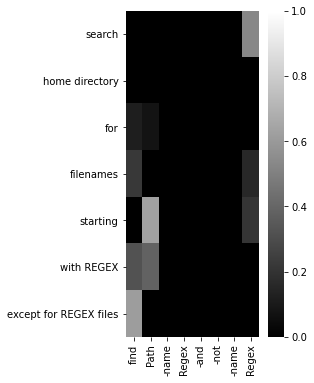

['find', 'Path', '!', '-name', 'Regex']
['chmod', 'Permission', 'File']


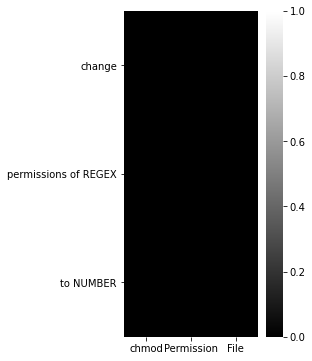

['chmod', 'Permission', 'File']
['find', 'Path', '-name', 'Regex']


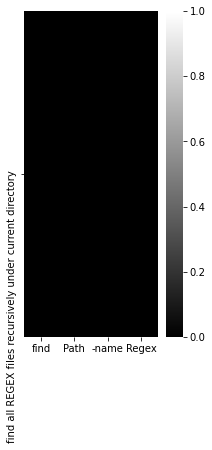

['find', 'Path', '-name', 'Regex']
['mv', 'File', 'File']


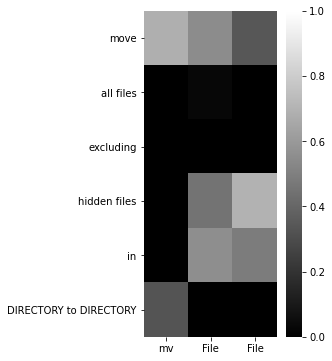

['mv', 'File']
['find', 'Path', '-name', 'Regex', '-exec', 'mv', 'File', 'File', '\\;']


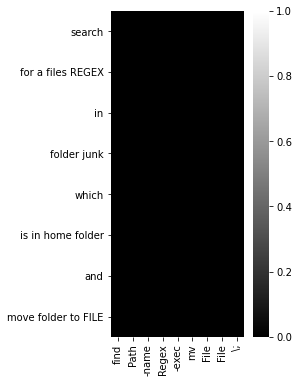

['find', 'Path', '-name', 'Regex', '-exec', 'mv', 'File', '\\;']
['find', 'Path', '-name', 'Regex', '-print']


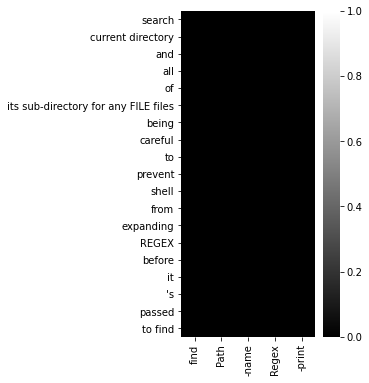

['find', 'Path', '-name', 'Regex', '-print']
['find', 'Path', '-type', 'Type']


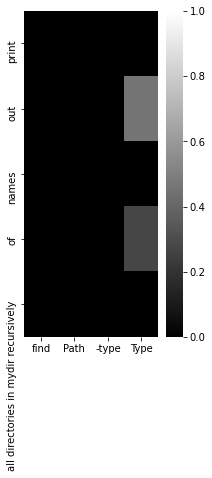

['find', 'Path', '-type', 'Type']
['find', 'Path', '-type', 'Type', '-iname', 'Regex']


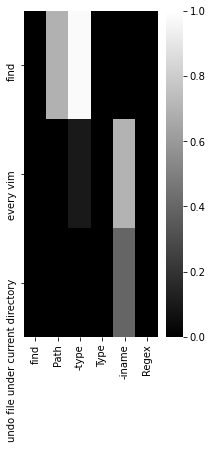

['find', 'Path', '-type', 'Type', '-iname', 'Regex']
['chown', 'Regex', 'File']


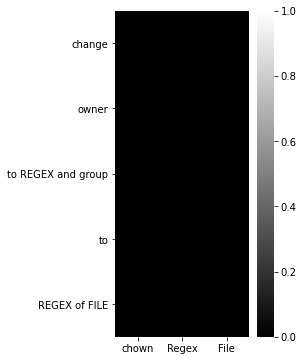

['chown', 'Regex', 'File']
['find', 'Path', '-name', 'Regex', '-prune', '-or', '-type', 'Type', '-print']


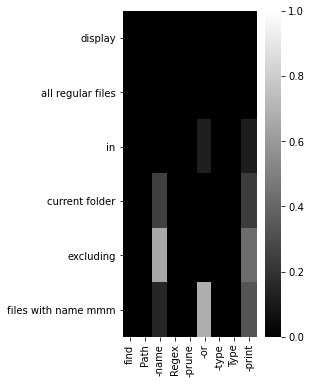

['find', 'Path', '-name', 'Regex', '-prune', '-or', '-type', 'Type', '-print']
['find', 'Path', '-type', 'Type', '-name', 'Regex']


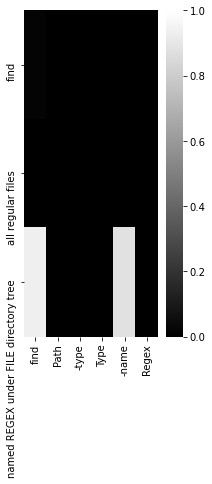

['find', 'Path', '-type', 'Type', '-name', 'Regex']
['echo', 'Regex', '|', 'rev', '|', 'cut', '-d', 'Regex', '-f', 'Number', '|', 'rev']


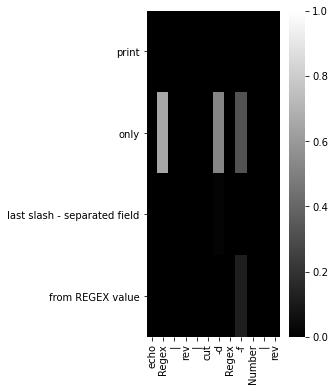

['echo', 'Regex', '|', 'rev', '|', 'cut', '-d', 'Regex', '-f', 'Number', '|', 'rev']
['find', 'Path', '-group', 'Regex', '-exec', 'chgrp', 'Regex', 'File', '\\;']


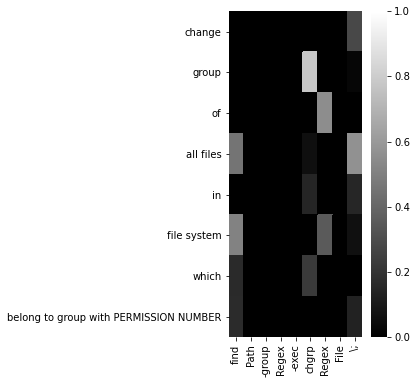

['find', 'Path', '-group', 'Regex', '-exec', 'chgrp', 'Regex', 'File', '\\;']
['find', 'Path', '-newer', 'File']


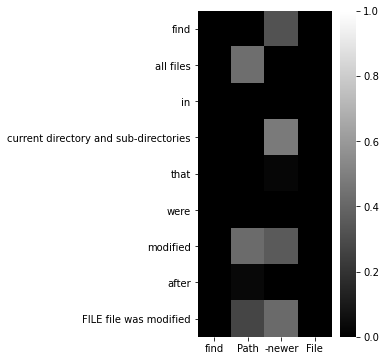

['find', 'Path', '-newer', 'File']
['chmod', 'Permission', 'File']


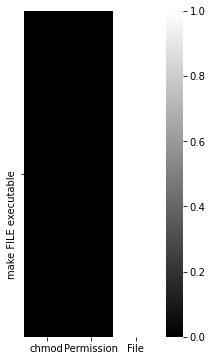

['chmod', 'Permission', 'File']
['find', 'Path', '-name', 'Regex']


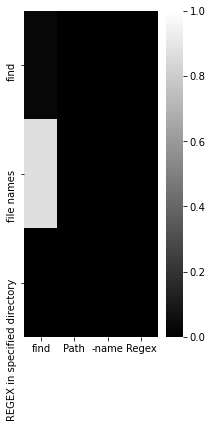

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-mtime', 'Timespan', '-mtime', 'Timespan']


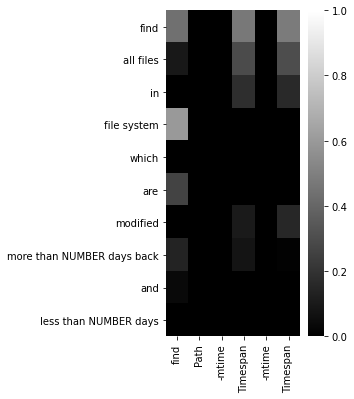

['find', 'Path', '-mtime', 'Timespan']
['find', 'Path', '-perm', 'Permission']


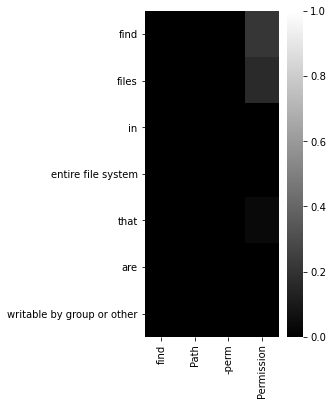

['find', 'Path', '-perm', 'Permission']
['find', 'Path', '-type', 'Type', '-atime', 'Timespan']


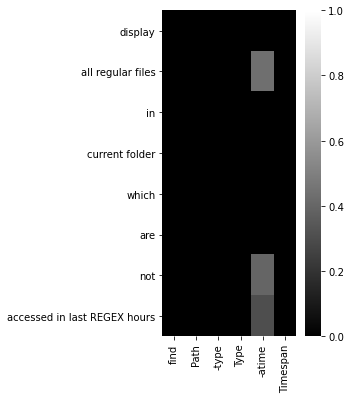

['find', 'Path', '-type', 'Type', '-atime', 'Timespan']
['chown', '-R', 'Regex', 'File']


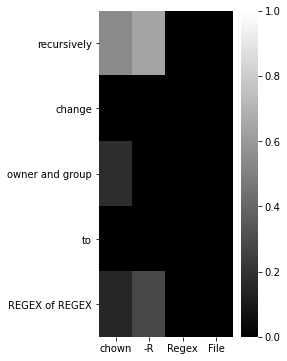

['chown', '-R', 'Regex', 'File']
['find', 'Path', '-name', 'Regex']


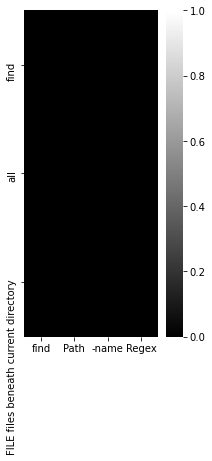

['find', 'Path', '-name', 'Regex']
['which', 'Regex']


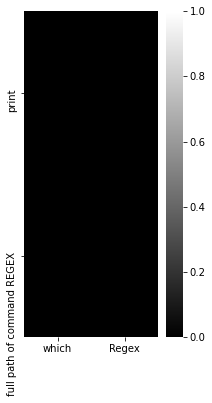

['which', 'Regex']
['find', 'Path', '-depth', '-name', 'Regex', '-execdir', 'rename', 'Regex', 'Regex', 'File', '\\;']


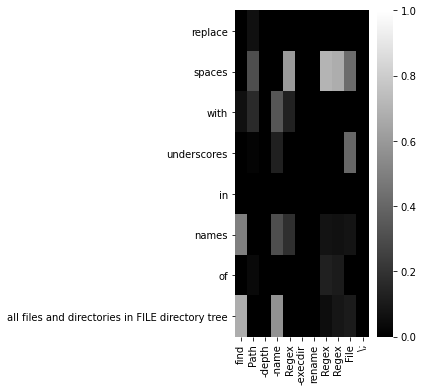

['find', 'Path', '-depth', '-name', 'Regex', '-execdir', 'rename', 'Regex', '\\;']
['echo', '$(basename', 'Regex)']


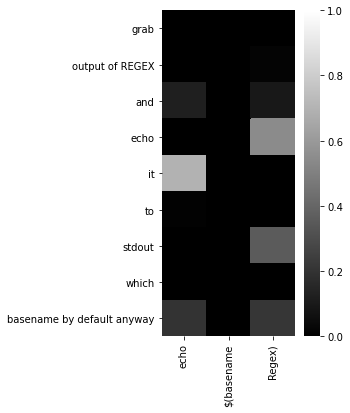

['echo', '$(basename', 'Regex)']
['find', 'Path', '--version']


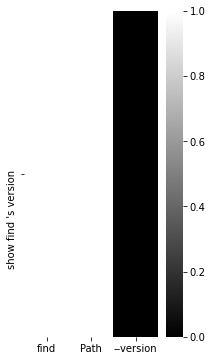

['find', 'Path', '--version']
['cd', 'Directory']


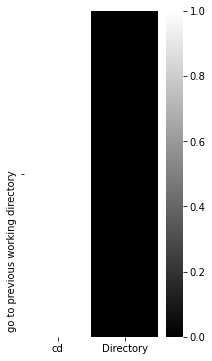

['cd', 'Directory']
['find', 'Path', '-name', 'Regex']


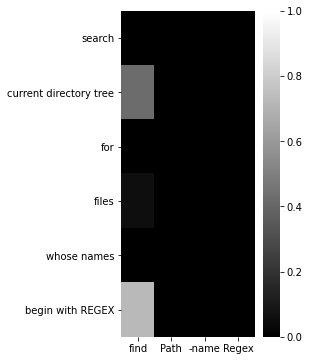

['find', 'Path', '-name', 'Regex']
['mktemp']


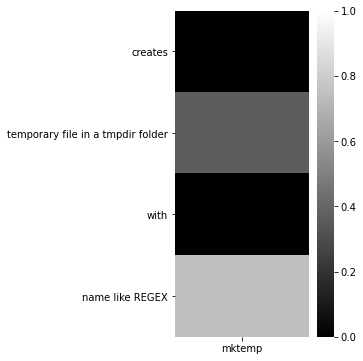

['mktemp', 'Regex']
['cp', '-R', 'File', 'File']


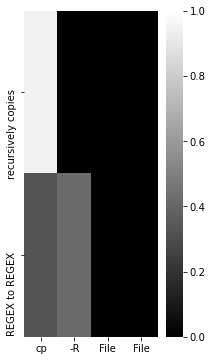

['cp', '-R', 'File']
['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']


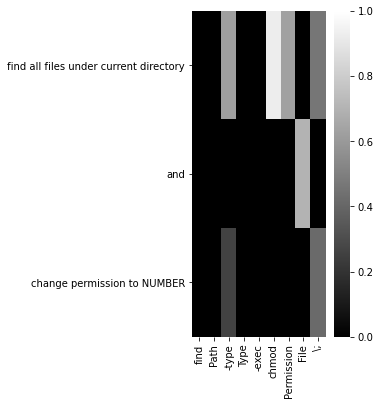

['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']
['find', 'Path', '-name', 'Regex', '-maxdepth', 'Quantity', '-print0', '|', 'xargs', '-0', '-I', 'ReservedWord', 'mv', 'ReservedWord', 'File']


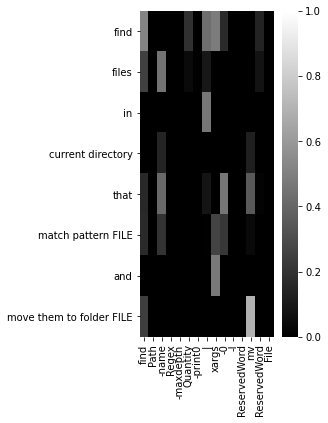

['find', 'Path', '-name', 'Regex', '-maxdepth', 'Quantity', '-print0', '|', 'xargs', '-0', '-I', 'ReservedWord', 'mv', 'ReservedWord', 'File']
['find', 'Path', '-size', 'Size']


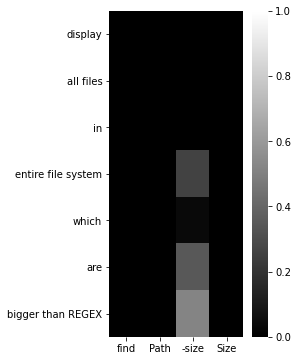

['find', 'Path', '-size', 'Size']
['find', 'Path', '-mtime', 'Timespan', '-or', 'Path', 'Path']


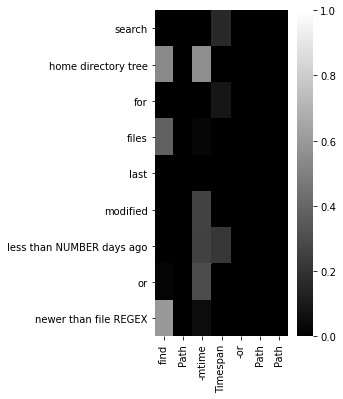

['find', 'Path', '-mtime', 'Timespan']
['find', 'Path', '-type', 'Type', '|', 'wc', '-l']


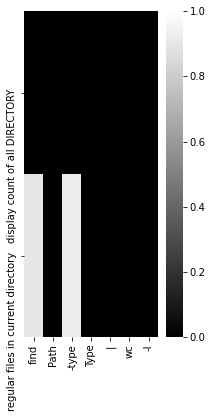

['find', 'Path', '-type', 'Type', '|', 'wc', '-l']
['find', 'Path', 'Path', '-f', '-ctime', 'Timespan']


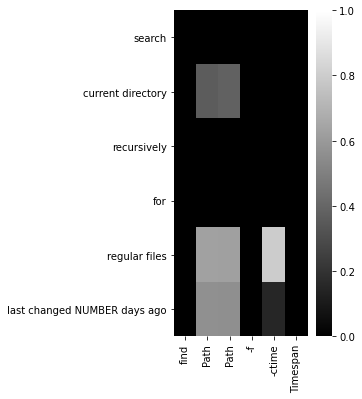

['find', 'Path', '-f', '-ctime', 'Timespan']
['find', 'Path', 'Path', '-name', 'Regex', '-type', 'Type']


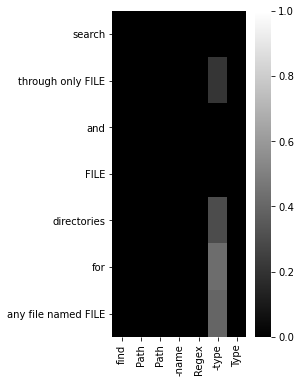

['find', 'Path', '-name', 'Regex', '-type', 'Type']
['find', 'Path', '-name', 'Regex']


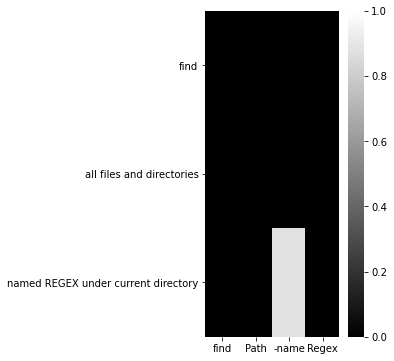

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-type', 'Type', '-atime', 'Timespan']


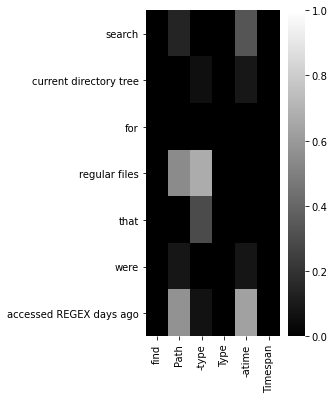

['find', 'Path', '-type', 'Type', '-atime', 'Timespan']
['mount', '-t', 'Option', 'Regex', 'Regex']


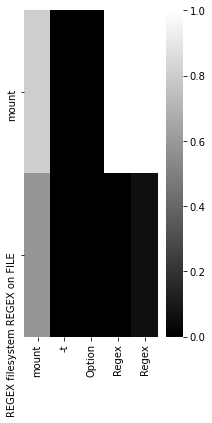

['mount', '-t', 'Option', 'Regex']
['find', 'Path', '-name', 'Regex']


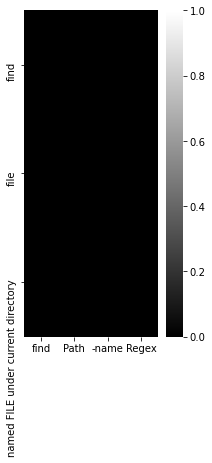

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-maxdepth', 'Quantity', '-mindepth', 'Quantity', '-type', 'Type', '-printf', 'Format']


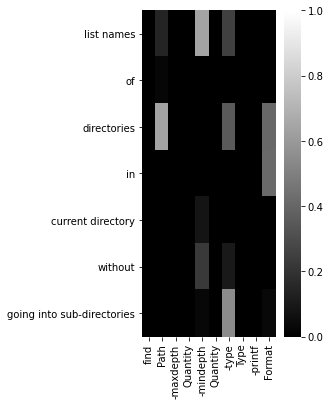

['find', 'Path', '-mindepth', 'Quantity', '-maxdepth', 'Quantity', '-type', 'Type', '-printf', 'Format']
['cp', '-r', 'File', 'File']


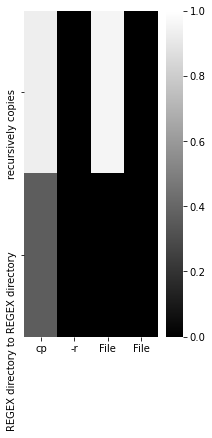

['cp', '-r', 'File', 'File']
['shopt', '-s', 'Option']


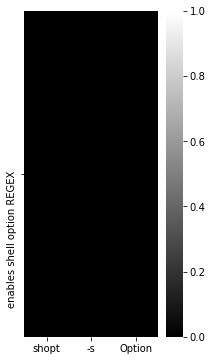

['shopt', '-s', 'Option']
['find', 'Path', '-name', 'Regex']


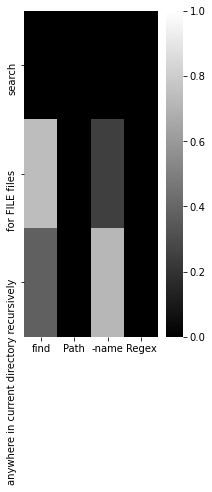

['find', 'Path', '-name', 'Regex']
['chown', 'Regex', 'File']


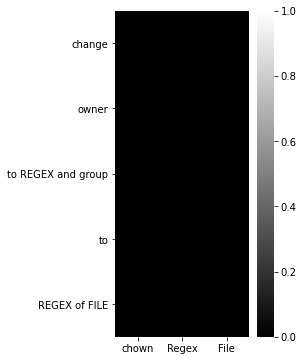

['chown', 'Regex', 'File']
['find', 'Path', '-name', 'Regex']


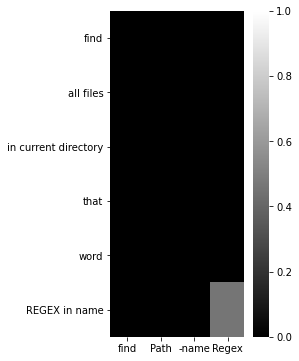

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-name', 'Regex', '-mmin', 'Quantity']


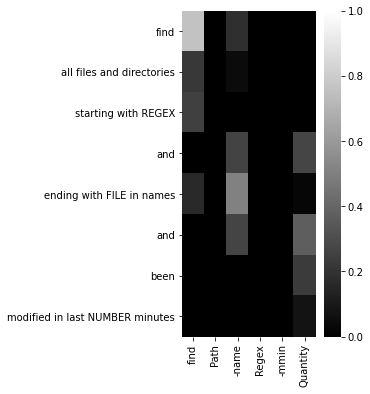

['find', 'Path', '-mmin', 'Quantity', '-name', 'Regex']
['find', 'Path', '-group', 'Regex', '-type', 'Type']


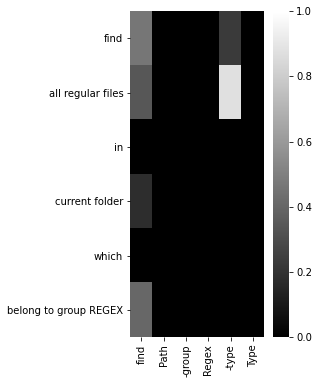

['find', 'Path', '-type', 'Type', '-group', 'Regex']
['chown', '-R', 'Regex', 'File']


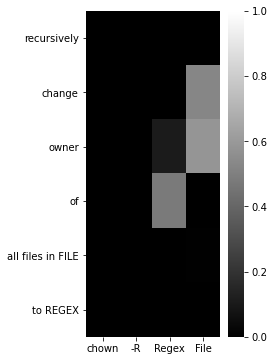

['chown', '-R', 'Regex', 'File']
['find', 'Path', '-type', 'Type', '|', 'xargs', '-I', 'Regex', 'chmod', '-v', 'Permission', 'File']


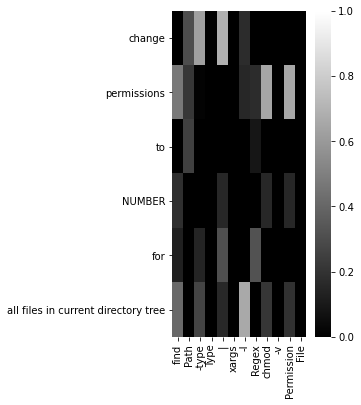

['find', 'Path', '-type', 'Type', '|', 'xargs', '-I', 'ReservedWord', 'chmod', '-v', 'Permission', 'ReservedWord']
['find', 'Path', '-name', 'Regex']


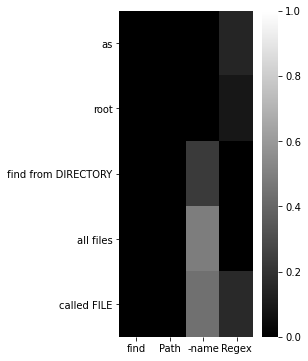

['find', 'Path', '-name', 'Regex']
['find', 'Path', 'Path', '-type', 'Type']


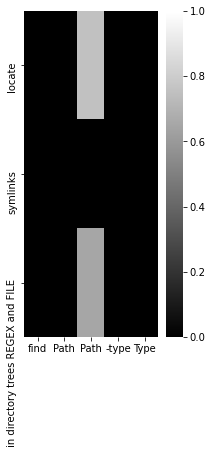

['find', 'Path', '-type', 'Type']
['find', 'Path', '-cmin', 'Quantity']


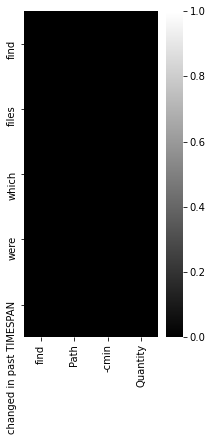

['find', 'Path', '-cmin', 'Quantity']
['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']


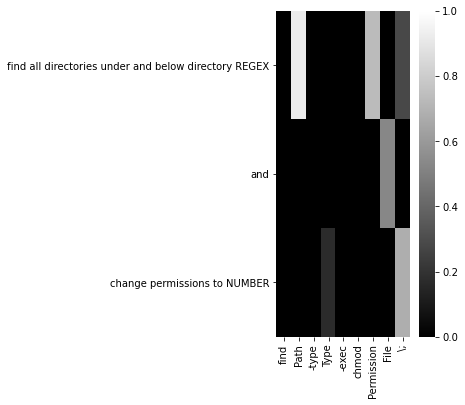

['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']
['sed', '-i', 'Program', 'File']


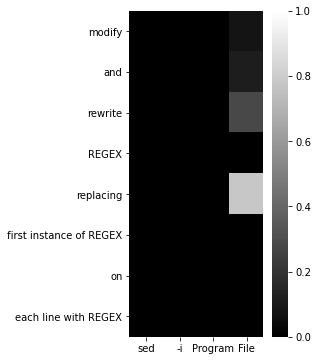

['sed', '-i', 'Program', 'File']
['find', 'Path', '!', '-type', 'Type', '-printf', 'Format', '|', 'awk', 'Program']


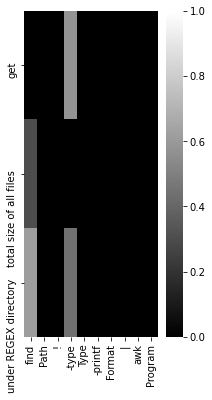

['find', 'Path', '!', '-type', 'Type', '-printf', 'Format', '|', 'awk', 'Program']
['md5sum', '$(which', 'Regex)']


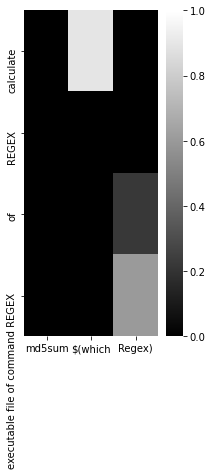

['md5sum', '$(which', 'Regex)']
['find', 'Path', '-type', 'Type', '-empty']


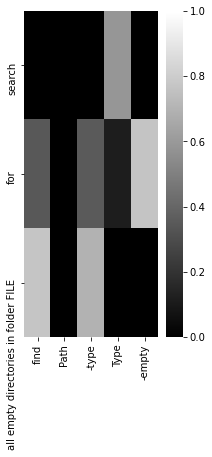

['find', 'Path', '-type', 'Type', '-empty']
['find', 'Path', '-name', 'Regex']


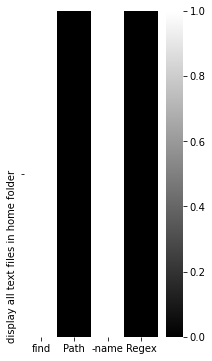

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-newer', 'File']


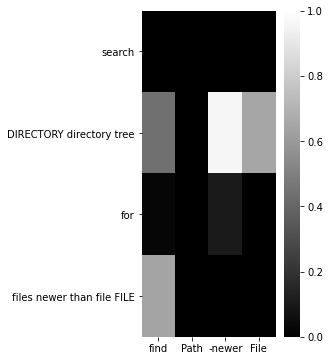

['find', 'Path', '-newer', 'File']
['find', 'Path', '-path', 'Regex', '-print']


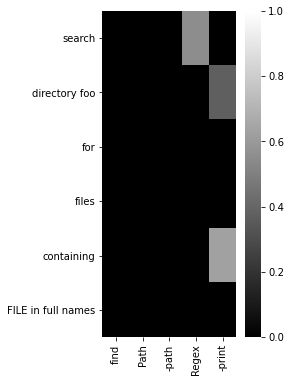

['find', 'Path', '-path', 'Regex', '-print']
['find', 'Path', '-mtime', 'Timespan', '-exec', 'rm', 'File', '\\;']


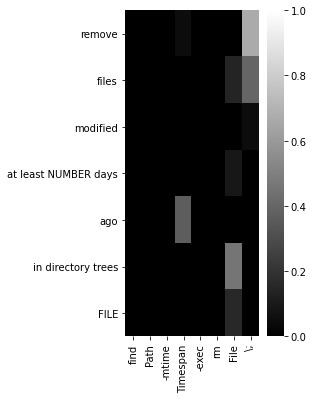

['find', 'Path', '-mtime', 'Timespan', '-exec', 'rm', 'File', '\\;']
['man', 'Regex']


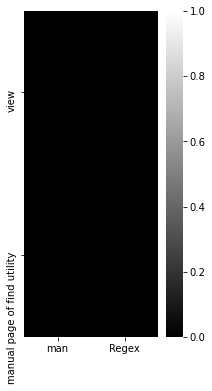

['man', 'Regex']
['info', 'Regex', 'Regex']


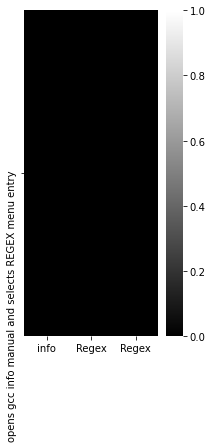

['info', 'Regex']
['find', 'Path', '-type', 'Type', '-name', 'Regex']


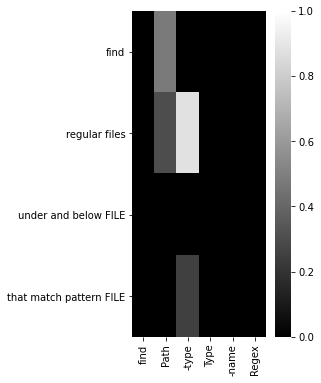

['find', 'Path', '-type', 'Type', '-name', 'Regex']
['find', 'Path', '-name', 'Regex', '-type', 'Type']


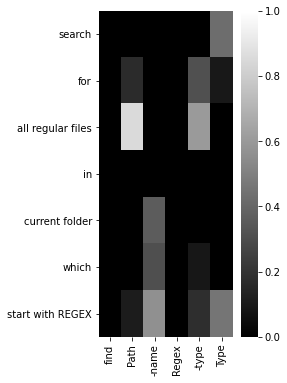

['find', 'Path', '-type', 'Type', '-name', 'Regex']
['find', 'Path', '-type', 'Type', '-and', '-atime', 'Timespan']


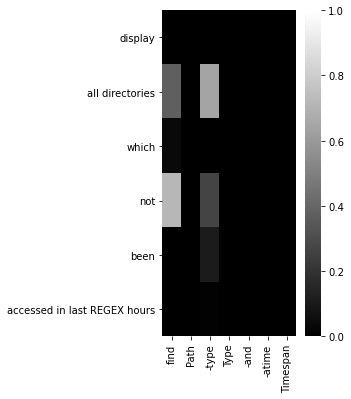

['find', 'Path', '-type', 'Type', '-atime', 'Timespan']
['bzip2', '-k', '-v', 'File']


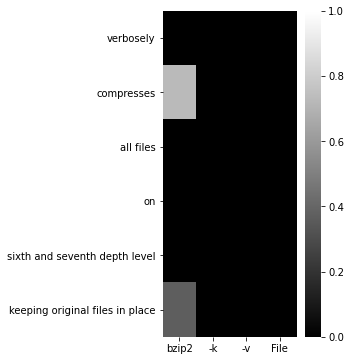

['bzip2', '-k', '-v', 'File']
['find', 'Path', '-mtime', 'Timespan', '-mtime', 'Timespan', '|', 'head']


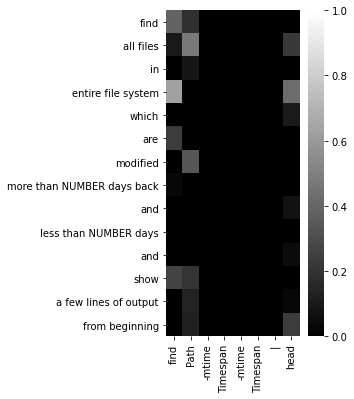

['find', 'Path', '-mtime', 'Timespan', '|', 'head']
['find', 'Path', '-regex', 'Regex']


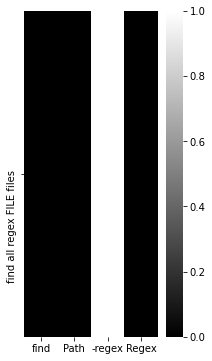

['find', 'Path', '-regex', 'Regex']
['kill', 'Regex']


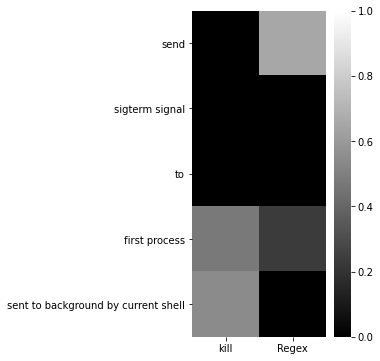

['kill', 'Regex']
['ping', '-c', 'Quantity', '-q', 'Regex', '|', 'grep', '-o', '-P', 'Regex']


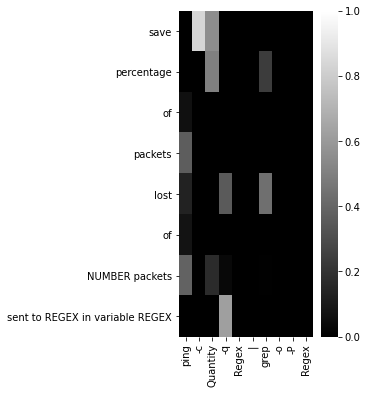

['ping', '-c', 'Quantity', '-q', 'Regex', '|', 'grep', '-o', '-P', 'Regex']
['find', 'Path', '-type', 'Type', '-empty']


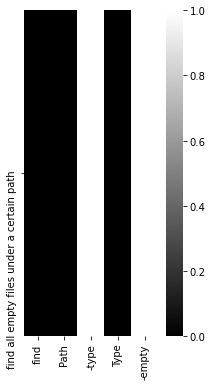

['find', 'Path', '-type', 'Type', '-empty']
['find', 'Path', '-name', 'Regex', '-exec', 'awk', 'Program', 'Program', '\\;']


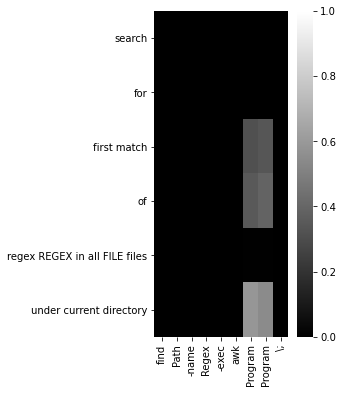

['find', 'Path', '-name', 'Regex', '-exec', 'awk', 'Program', '\\;']
['df', '-k']


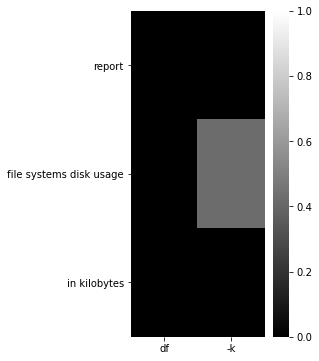

['df', '-k', 'File']
['bzip2', '-k', '-v', 'File']


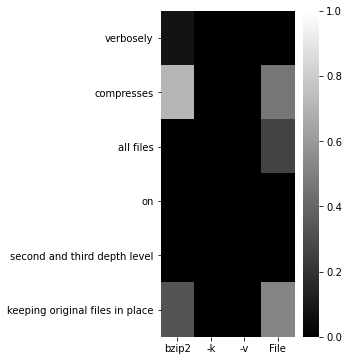

['bzip2', '-k', '-v', 'File']
['find', 'Path', '-size', 'Size']


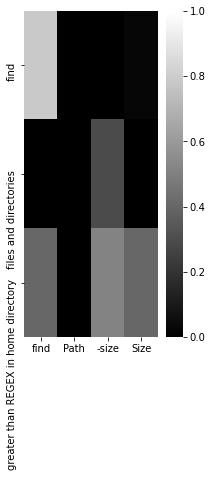

['find', 'Path', '-size', 'Size']
['chgrp', 'Regex', 'File']


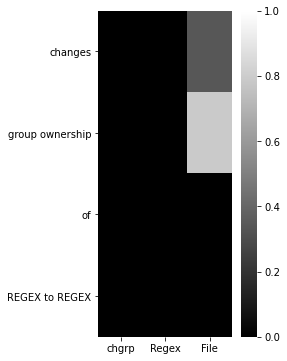

['chgrp', 'Regex', 'File']
['find', 'Path', '-name', 'Regex']


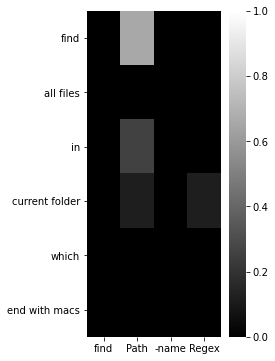

['find', 'Path', '-name', 'Regex']
['find', 'Path', '-regex', 'Regex']


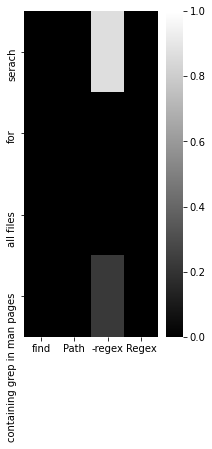

['find', 'Path', '-regex', 'Regex']
['find', 'Path']


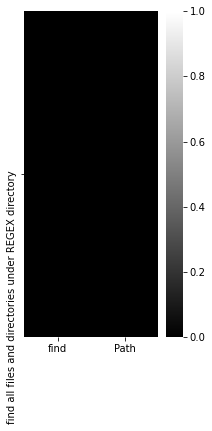

['find', 'Path']
['sort', 'File', '|', 'uniq', '-c', '|', 'sort', '-n', '-r']


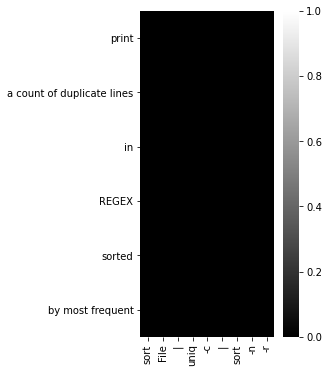

['sort', '|', 'uniq', '-c', '|', 'sort', '-n', '-r']
['find', 'Path', '-type', 'Type', '-exec', 'sed', '-i', 'Program', 'File', '+']


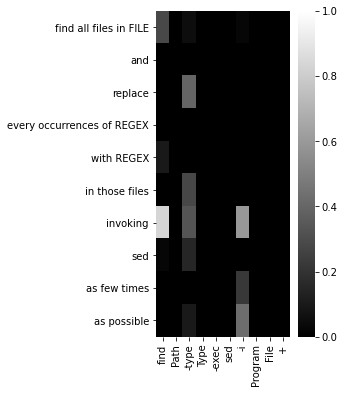

['find', 'Path', '-type', 'Type', '-exec', 'sed', '-i', 'Program', 'File', '+']
['find', 'Path', '-name', 'Regex', '-ok', 'rm', 'File', '\\;']


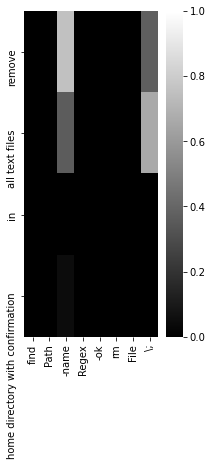

['find', 'Path', '-name', 'Regex', '-ok', 'rm', 'File', '\\;']
['find', 'Path', '-perm', 'Permission']


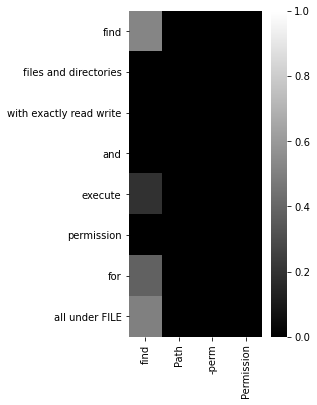

['find', 'Path', '-perm', 'Permission']
['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']


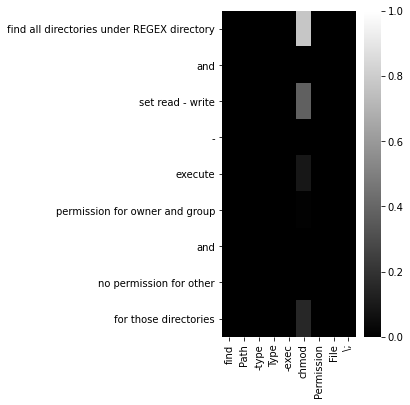

['find', 'Path', '-type', 'Type', '-exec', 'chmod', 'Permission', 'File', '\\;']
['cd', '$(dirname', '$(which', 'Regex))']


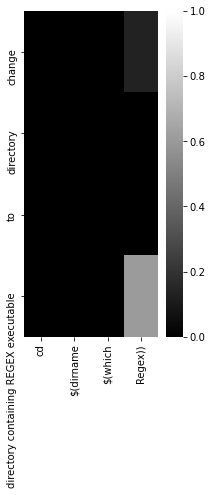

['cd', '$(dirname', '$(which', 'Regex))']
['find', 'Path', '-size', 'Size']


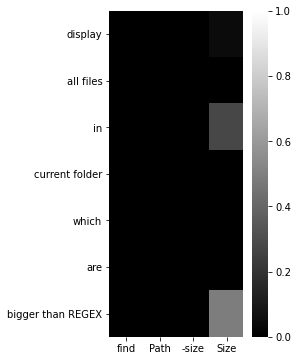

['find', 'Path', '-size', 'Size']
['find', 'Path', '-type', 'Type']


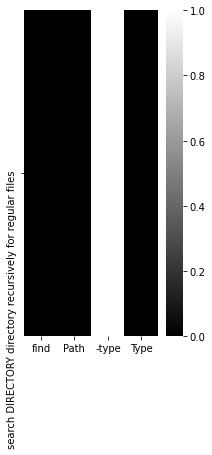

['find', 'Path', '-type', 'Type']
['mkdir', 'Directory']


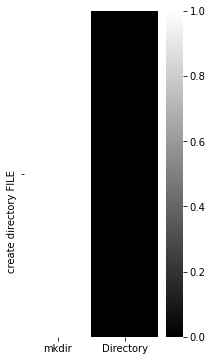

['mkdir', 'Directory']
['find', 'Path', '-type', 'Type', '-regex', 'Regex']


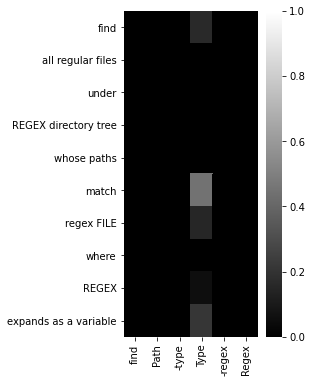

['find', 'Path', '-type', 'Type', '-regex', 'Regex']
['df', '-k', 'File']


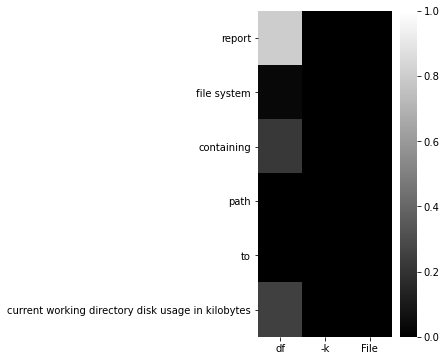

['df', '-k', 'File']
['readlink', '-f', 'File']


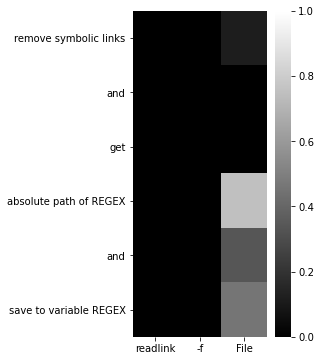

['readlink', '-f', 'File']
['find', 'Path', '-iname', 'Regex']


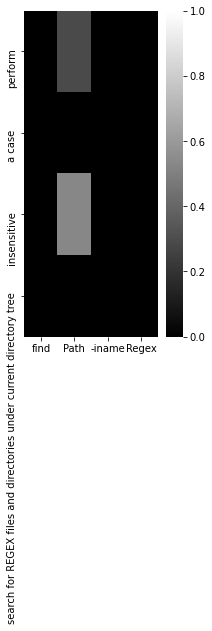

['find', 'Path', '-iname', 'Regex']
['find', 'Path', '-name', 'Regex']


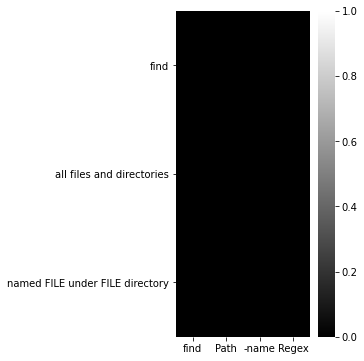

['find', 'Path', '-name', 'Regex']


In [75]:
for idx in range(len(attr_records)):
    plot_fig(idx)
    print(pred_full_data[idx])
    print('==='*30)

In [ ]:
 cherry = [14,]

In [8]:
import pickle
dirpath = '/home/shikharb/HSE-Translation/run/attribution/test_attr'
import os
test_attrs = []
for filename in os.listdir(dirpath):
    if not filename.startswith('test5k_attr'):
        continue
    with open(os.path.join(dirpath,filename),'rb') as  f:
        test_attrs.append(pickle.load(f))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [7]:
len(test_attrs)

0

In [34]:

#nested :: batch over full data ---> timestep over batch max timestep-1 --> each element is tuple(attr,err,translation) == attr
# attr shape is [batch_size, max_phrase_count, max_phrase_len]

def organize_attribution_data(attr_records):
    attr_full_data = []
    err_full_data = []
    invocation_phrases_full_data = []
    cmd_full_data = []

    for attr_record_batch in attr_records:
        attr_ex_ts = None
        err_ex_ts = None
        for attr_record_ts in attr_record_batch:
            attr, err, trans = attr_record_ts
            batch_size =  attr.shape[0]
            if attr_ex_ts is None:
                attr_ex_ts = [[] for b in range(batch_size)] #list of list of attributions per example per time step
                err_ex_ts = [[] for b in range(batch_size)]
            for b in range(batch_size):
                attr_i = attr[b] #attr for bth example in batch at time step ts
                attr_ex_ts[b].append(attr_i)
                err_ex_ts[b].append(err[b].detach().cpu().item())
        attr = [create_attribution_matrix(A) for A in attr_ex_ts]  
        attr_full_data.extend(attr)
        err_full_data.extend(np.array(err_ex_ts))
        #####
        invocation_phrases_full_data.extend([T.inv_phrasing for T in trans])
        cmd_full_data.extend([T.truth[0] for T in trans])
    #     print('=='*30)
    return attr_full_data, err_full_data, invocation_phrases_full_data, cmd_full_data

In [35]:
train_attr_full_data, train_err_full_data, train_invocation_phrases_full_data, train_cmd_full_data = organize_attribution_data(train_attrs)

['decompress and archive FILE']
[[ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]]
(10, 1) 1 9


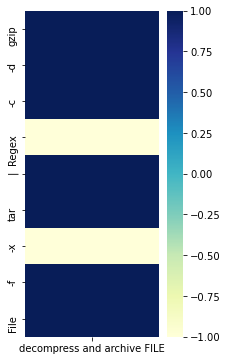

In [43]:
plot_fig(6,attr_full_data = train_attr_full_data,err_full_data = train_err_full_data,invocation_phrases_full_data=train_invocation_phrases_full_data,cmd_full_data=train_cmd_full_data)